# Modèle nul

In [98]:
Vmu = 5
w2  = 10
rho = 1
Tmax = 1000
th = GenerateEnvironment(time = Tmax*nbsteps,r=rho)
listmu = [0]*(Tmax+1)
listth = [0]*(Tmax+1)
for t in range(Tmax):
    thnow = np.mean(th[t*tau:(t+1)*tau])
    listmu[t+1] = listmu[t] + (thnow-listmu[t])*Vmu/(w2+Vmu)
    listth[t+1]   = thnow

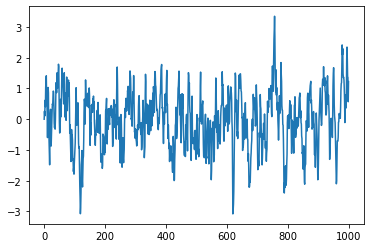

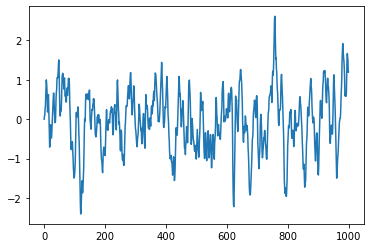

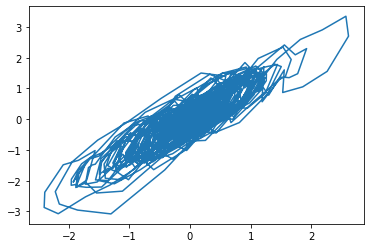

In [99]:
plt.plot(listth)
plt.figure()
plt.plot(listmu)
plt.figure()
plt.plot(listmu,listth)

# Plasticity in bet-hedging

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pdb
from statsmodels.tsa.arima_process import ArmaProcess

In [58]:
x0       = (1,0.1) #Initial conditions. The first term is the mean genetic value of z, the second term is the parameter of sensitivity to maternal environment m
tau      = 100 #Lifespan
nbsteps  = 20#Number of selective episodes in an organism’s lifetime
w2       = 10*tau #Inverse selection strength (constant)

Vgenetic = (0.5,0.01) #Genetic variance
h2       = 0.3 #This is the heritability, it only matters for m

rho      = 0.5 #Autocorrelation of the environment, careful exprho = exp(-rho delta) for delta the discretization step in time and rho the continuous autocorrelation used in the text
sig2_e   = 1 #Variance in the environment

Tmax     = 500000

In [72]:
def GenerateEnvironment(r=rho, s2=sig2_e, n = nbsteps*Tmax, time=tau*Tmax):
    """This function, for a given autocorrelation r and environmental standard deviation s, generates an AR[1] sequence of length n
    Keep in mind that a discretized (in steps of size dt) O-U process with parameters (r,s2) is an AR[1] process with parameters (exp(-rho dt), sqrt(s2(1-exp(-2rho dt))))"""
    x= ArmaProcess([1,-np.exp(-r*time/n)]).generate_sample(n,scale=np.sqrt(s2*(1-np.exp(-2 * r *time/n))))
    return x

In [4]:
def LogFitnessSingleGeneration(z,th,w):
    """Discrete implementation of our formula for LogFitness"""
    return -1/(2*w**2)*np.sum((z-th)**2)

In [5]:
#Here the perception of maternal instability is a trait of the offspring
x        = x0
th       = GenerateEnvironment(rho,sig2_e,nbsteps*Tmax,time=tau*(Tmax+1)) #Complete time series
thprev   = th[0:tau]

listx = [[0,0,0]]*Tmax
for t in range(Tmax):
    thnow   = th[(t+1)*tau:(t+2)*tau]
    varprev = np.var(thprev)
    meannow = np.mean(thnow)
    
    sigma2 = w2/tau + Vgenetic[0] + varprev*(x[1]**2+Vgenetic[1]) #the total variance in z after selection
    newgrad = Vgenetic[1] * varprev/sigma2 * (-1 + (x[0]-meannow)**2/sigma2) 
    #Logfitness of the mean genotype of the population in environment th:
    r       = -1/2 * (np.log(sigma2*tau/w2)  +  tau/w2 * np.var(thnow) +
                1/sigma2 * (x[0]-meannow)**2)
    newx    = (x[0]  -  Vgenetic[0]/sigma2 * (x[0]-meannow),
                x[1] *(1 + newgrad))
    thprev  = thnow
    mprev   = x[1]
    x       = newx
    listx[t]= [x[0],x[1],r,meannow]

Text(0.5, 0, 'Generations')

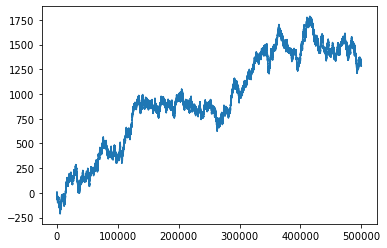

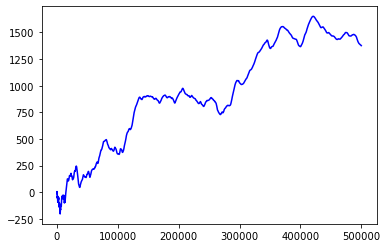

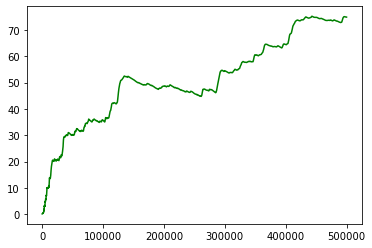

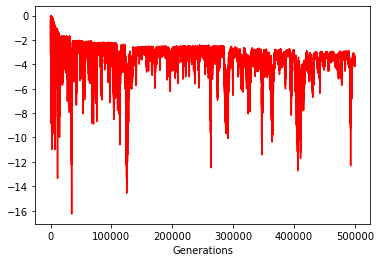

In [6]:
listmu, listm, listr, listth = np.transpose(listx)
plt.plot(listth)
plt.figure()
plt.plot(listmu,color="b")
plt.figure()
plt.plot(listm,color="g")
plt.figure()
plt.plot(listr,color="r")
plt.xlabel("Generations")

In [7]:
#Here we implement the formula for maternal inheritance
x        = x0
mprev    = x0[1] #We need as an initial condition the mother’s environment and sensitivity to it
mstarprev= x0[1]
th       = GenerateEnvironment(rho,sig2_e,nbsteps*Tmax,time=tau*(Tmax+1))
thprev   = th[0:tau]

listx = [[0,0,0]]*Tmax
for t in range(Tmax):
    thnow   = th[(t+1)*tau:(t+2)*tau]
    varprev = np.var(thprev)
    meannow = np.mean(thnow)
    
    sigma2 = w2/tau + Vgenetic[0] + varprev*(mstarprev**2+Vgenetic[1]/h2)*(x[0]-meannow)**2 #the total variance in z after selection
    
    #Logfitness of the mean genotype of the population in environment th:
    r       = -1/2 * (np.log(sigma2*tau/w2)  +  tau/w2 * np.var(thnow) +
                1/sigma2 * (x[0]-meannow)**2)
    
    #New values for the genotype: first we calculate for m, since it is quite complicated
    newgrad = (
        Vgenetic[1] * (2-h2) - (1-h2)*(1/h2-2)*mprev*(x[1] - mprev)
    ) * mstarprev * varprev/sigma2 * ((x[0]-meannow)**2/sigma2 - 1)
    mstarprev   = x[1] + newgrad/h2
    thprev  = thnow
    mprev   = x[1]
    newx    = (x[0]  -  Vgenetic[0]/sigma2 * (x[0]-meannow),
                x[1] + newgrad)
    x       = newx
    listx[t]= [x[0],x[1],r,meannow]

Text(0.5, 0, 'Generations')

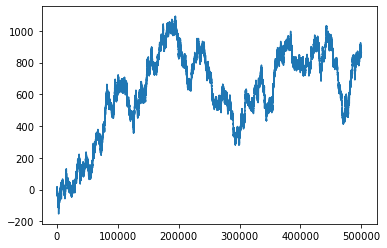

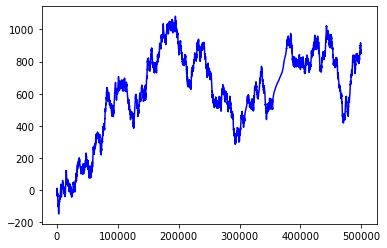

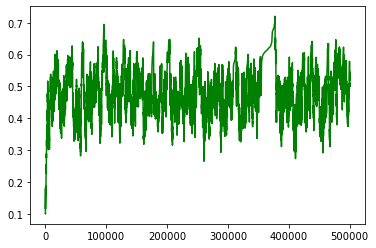

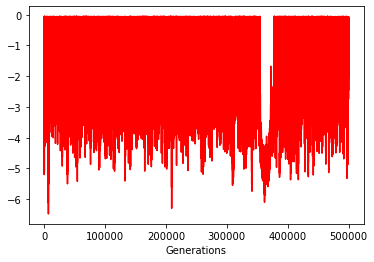

In [8]:
listmu, listm, listr, listth = np.transpose(listx)
plt.plot(listth)
plt.figure()
plt.plot(listmu,color="b")
plt.figure()
plt.plot(listm,color="g")
plt.figure()
plt.plot(listr,color="r")
plt.xlabel("Generations")

In [9]:
def GenerateTrajectory(x0=x0,Tmax=Tmax,tau=tau,nbsteps=nbsteps,w2=w2,Vgenetic=Vgenetic,rho=rho,sig2_e=sig2_e):
    """This function generates the trajectory of a population """
    x        = x0
    mprev    = x0[1] #We need as an initial condition the mother’s environment and sensitivity to it
    mstarprev= x0[1]
    th       = GenerateEnvironment(rho,sig2_e,nbsteps*Tmax,time=tau*(Tmax+1))
    thprev   = th[0:tau]

    listx    = [[0,0,0]]*Tmax
    for t in range(Tmax):
        thnow     = th[(t+1)*tau:(t+2)*tau]
        varprev   = np.var(thprev)
        meannow   = np.mean(thnow)

        sigma2    = w2/tau + Vgenetic[0] + varprev*(mstarprev**2+Vgenetic[1]/h2) #the total variance in z after selection

        #Logfitness of the mean genotype of the population in environment th:
        r         = -1/2 * (np.log(sigma2*tau/w2)  +  tau/w2 * np.var(thnow) +
                    1/sigma2 * (x[0]-meannow)**2)

        #New values for the genotype: first we calculate for m, since it is quite complicated
        newgrad   = (
            Vgenetic[1] * (2-h2) - (1-h2)*(1/h2-2)*mprev*(x[1] - mprev)
        ) * mstarprev * varprev/sigma2 * ((x[0]-meannow)**2/sigma2 - 1)
        mprev     = x[1]
        mstarprev = x[1] + newgrad/h2
        thprev    = thnow
        newx      = (x[0]  -  Vgenetic[0]/sigma2 * (x[0]-meannow),
                    x[1] + newgrad)
        x         = newx
        listx[t]  = [x[0],x[1],r,meannow]
    return np.transpose(listx)

Text(0.5, 0, 'Generations')

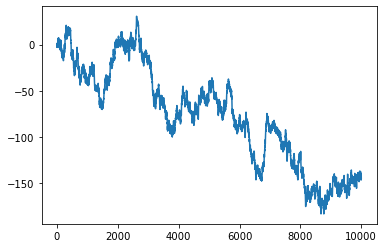

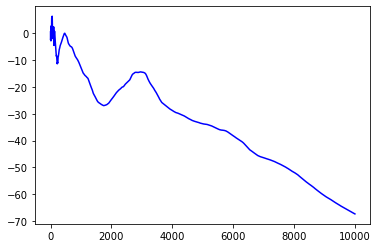

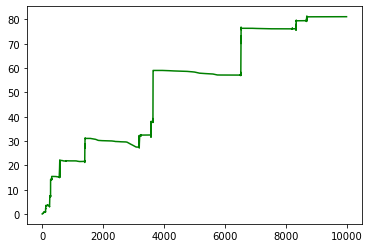

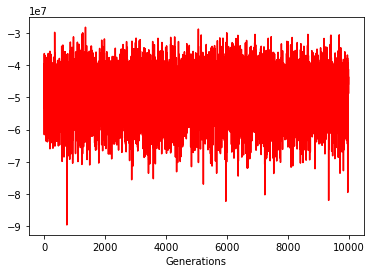

In [10]:
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * 0.01
Tmax   = 10000


listmu, listm, listr, listth = GenerateTrajectory(sig2_e = sig2_e,tau=tau,rho = rho,Tmax=Tmax,w2=w2)
plt.plot(listth)
plt.figure()
plt.plot(listmu,color="b")
plt.figure()
plt.plot(listm,color="g")
plt.figure()
plt.plot(listr,color="r")
plt.xlabel("Generations")

Something excitingly weird is going on
thnow=8.94857944749703, thprev=[ 8.62145554  8.15726623  9.16183789  9.19297567  9.72251177  8.50799705
  7.36328112  8.55797617 10.73546648  9.8488602   9.42096259  7.13468619
  8.82360755  8.26235299 10.1334888   8.23902785  7.63864149  8.58654075
  8.39089149  7.30799074  8.10367104  8.03907005  8.76693109  8.93110106
  7.6500406   8.7574423   9.13050038  9.12237737  8.70698303  8.89980838
  8.86678271  8.68697014  9.69484348  8.67735888  7.97843419  8.43978327
  9.01804847 10.74526273  9.36946532  7.89546784  8.20614049  7.94504752
  7.36388597  9.39508256  9.14319575  9.4012733   9.2912954   9.38218268
 10.01719135  9.95075345 11.44917579 10.5623176   9.38716579  8.7084922
  8.48454294  8.72048995  8.58474303  8.68260618  9.62709373  9.15928553
  7.40640761  8.22943712  8.60742498  9.46718574  7.80902015  9.27334218
  9.01572146  8.70234606  8.60169792  8.77833249  8.54751794 10.96518307
 10.26855642 10.73444578 10.00480812  9.284002    8.957

Something excitingly weird is going on
thnow=-251.72569198284657, thprev=[-253.31216071 -253.81534499 -253.56467841 -251.54143667 -249.88225899
 -251.62081326 -250.48759773 -250.95785062 -251.4449198  -251.3060564
 -250.91119586 -251.99806661 -252.16033523 -251.72726318 -252.54024443
 -252.25914953 -251.16545153 -251.79013216 -250.65498054 -251.1574557
 -252.14703847 -253.15780475 -252.01324319 -252.4380107  -252.7731217
 -252.1088068  -251.22905224 -251.03006685 -250.48379517 -250.78633244
 -250.72863626 -250.69899025 -252.64406881 -251.85828661 -252.80186824
 -250.5850666  -251.89804792 -251.23182954 -253.36856571 -252.50071234
 -252.66540643 -252.63269724 -251.04462826 -250.76584256 -251.38879931
 -251.3601034  -250.73166542 -252.30078726 -252.29481251 -250.29543447
 -251.09886122 -251.7781536  -251.98908621 -252.08955485 -251.79952363
 -251.7141718  -251.13954606 -253.08998155 -250.65990416 -252.34139626
 -252.60612722 -251.17427565 -250.86706833 -252.95984746 -252.14614883
 -250.2

Something excitingly weird is going on
thnow=5.283891898992111, thprev=[4.04647285 5.07230161 6.37091809 6.16318621 4.66950548 3.42535771
 4.76650606 6.51625894 4.5591405  4.7237477  4.66383046 4.28473406
 6.80602133 4.69308245 6.8868725  5.90448703 5.7793695  6.39246287
 4.97013331 6.45151224 4.50985675 3.64110044 6.51108265 5.15522578
 4.77325797 3.87049918 5.58840029 6.1371778  7.89345956 6.99102449
 6.10411295 6.16918073 4.95766402 3.75679077 3.21479736 5.38584473
 5.52285175 6.01622032 7.34586999 5.92393161 6.69274802 5.65434188
 4.4632671  4.80826717 5.05238559 6.20215014 4.99932191 4.63449446
 5.30367876 6.56390784 4.30811996 4.70007539 4.93325766 5.56129491
 5.75127024 5.90963013 6.03042161 4.88061469 5.10348304 5.01332546
 5.921829   4.31971499 4.82624035 4.21067851 5.8105402  5.99772232
 4.63713378 5.40776863 4.52227698 4.081979   4.954335   4.05020406
 4.68927856 5.76509732 5.71850756 5.76087203 4.68541188 5.96583012
 5.68603929 4.66272476 4.21665216 4.15468927 4.62036059 4.

Something excitingly weird is going on
thnow=-16.11904444318404, thprev=[-15.54836542 -16.16075102 -17.07863679 -17.03046283 -16.05943454
 -16.65201273 -17.23893226 -16.3952715  -16.59836837 -16.12224327
 -16.07521839 -16.46697473 -16.60498241 -16.21787325 -15.51344112
 -15.91033861 -16.53784207 -15.47125548 -16.28939453 -16.50918929
 -16.73376018 -16.23290285 -16.29603971 -16.83819475 -18.12265182
 -16.96342    -15.5570153  -16.64189993 -16.51440341 -16.91377826
 -17.3076356  -15.94161686 -16.31379756 -16.1403227  -16.19527274
 -16.08570221 -16.0882344  -15.01384234 -14.70192475 -15.08543924
 -14.90630545 -14.92119902 -16.30146796 -16.32573952 -15.41273982
 -16.55660878 -15.07569286 -15.87748781 -16.08197232 -16.63117895
 -15.34487042 -14.8116076  -16.06904576 -15.38392699 -16.07450626
 -16.60178164 -15.84482021 -16.73262089 -17.49219127 -16.41602002
 -15.46699771 -15.56952863 -15.47999815 -15.11847229 -15.23488256
 -16.3277192  -17.29181636 -16.39063319 -15.99614726 -15.1213465
 -16.

Something excitingly weird is going on
thnow=-59.84775245489916, thprev=[-59.73218115 -60.46924459 -59.80972354 -60.15205743 -61.08761419
 -60.09150671 -58.77349428 -59.11554758 -60.31490707 -59.5969266
 -59.7172108  -61.33304377 -59.55423862 -59.80474412 -61.04737255
 -60.34136573 -60.17761155 -60.61971584 -59.22836494 -59.64013544
 -60.43215898 -60.37042256 -61.19526469 -61.19155239 -59.14955221
 -59.31637424 -59.48444574 -59.55099215 -59.99160549 -59.25719415
 -59.76177617 -59.29143425 -58.32007505 -59.67909929 -59.04622318
 -58.28067422 -58.54720877 -58.79715868 -59.69859481 -59.3736348
 -59.45956095 -61.84780925 -60.13918663 -60.20840429 -59.69429796
 -57.8020701  -60.1055973  -60.06208411 -59.88098541 -58.84957444
 -59.54934536 -60.02010553 -59.9515604  -59.86837488 -60.2582208
 -59.97893681 -60.93203816 -62.52401356 -60.62027212 -59.6625756
 -60.23962522 -60.33784816 -61.88777565 -60.24610374 -60.03299531
 -60.68704018 -60.87796921 -62.18968798 -61.06676102 -61.08105962
 -61.029

Something excitingly weird is going on
thnow=4.456336239771662, thprev=[5.20013145 5.49516104 6.46967766 5.15276766 4.56276908 4.19608127
 4.24329925 5.27914409 4.43660537 3.9463639  4.15031455 4.53981155
 4.88312807 5.49595812 5.06253004 4.89918006 4.71356423 4.52210692
 4.3445653  2.70737127 3.20487024 4.36652479 5.39034039 4.32204932
 4.3394074  3.30936848 5.31056559 4.74652231 4.67289454 3.85075663
 4.25335546 4.6341626  4.61363151 4.2360349  4.49510226 5.17665148
 3.98053685 5.05061726 3.61018814 3.81978714 3.97676545 4.77884836
 3.94546025 6.68841167 5.68697452 4.93722115 5.87006705 4.70935753
 5.11765918 5.42797058 3.21895966 2.88697094 3.56935264 5.04924763
 6.28139278 5.43071734 5.62085016 4.21785261 4.51415653 1.23477754
 3.23658567 4.95970609 4.04480963 3.70026543 3.96442805 3.54490293
 4.08443432 3.31870216 2.92913562 4.36416046 2.59903474 3.96992356
 4.30946954 6.22992953 4.43455422 5.21771961 4.84009943 3.92971919
 4.92887594 4.06767584 4.46239494 3.2488012  3.39472587 4.

Something excitingly weird is going on
thnow=-96.96397938953628, thprev=[ -96.5866145   -97.26248111  -96.29554439  -97.72016855  -97.27119548
  -95.3719226   -96.80631078  -98.08191816  -97.101737    -96.71132052
  -95.85153923  -96.53745323  -96.57666738  -96.18752234  -96.82323425
  -97.65999291  -97.58473287  -96.4195382   -96.27778003  -95.11289767
  -96.52582807  -97.26897918  -97.01080511  -96.03446358  -96.65218197
  -96.81187122  -96.62499905  -96.56500357  -97.3303698   -99.30061236
  -98.00160673  -98.5272476   -97.06327238  -97.50033253  -97.3899151
  -96.67186371  -96.39345975  -94.60331299  -94.80526623  -96.67937734
  -98.96756031  -98.93761452  -97.95949548  -96.60350309  -98.17700468
  -96.29026267  -96.52892699  -96.40871337  -95.00767859  -95.72206179
  -95.33782991  -97.77902298  -97.64528934  -97.00201573  -97.60809234
  -97.70201809  -98.68796899  -99.02334444  -96.57925479  -95.97824077
  -97.07867538  -97.60131843  -96.36365513  -96.36273498  -97.23186694
  -95.

Something excitingly weird is going on
thnow=-8.026833737006706, thprev=[ -7.25592817  -8.21810411  -8.68710681  -7.9151571   -7.04801438
  -8.65769874  -8.41072413  -7.47128064  -9.28277344  -8.13509189
  -8.09346322  -7.19370128  -7.35213208  -9.27531454  -8.71481553
  -7.09681601  -7.46442079  -9.79539512  -8.33069634  -6.82946077
  -7.24007655  -7.9954032   -9.3270936   -9.6768973   -6.63693762
  -6.85268072  -9.28069384  -9.37779778  -7.78846424  -7.0527132
  -8.3159093   -7.89121194  -7.24578437  -7.74479932  -7.77479517
  -6.95487202  -8.88172086  -7.71940248  -8.02363007  -7.71010229
  -6.19767745  -6.15587223  -8.8696566   -5.84915681  -6.62229846
  -8.88090502  -7.27190781  -8.20475242  -7.92745262  -8.68842731
  -8.33217233  -8.58526854  -9.04338871  -8.69150738  -8.17459262
  -5.63063416  -7.9144437   -7.04557231  -8.33628493  -8.16056827
  -8.68579433  -8.44327101 -10.12861167  -7.74633203  -6.41028976
 -10.27380507  -8.38651498  -8.62401161  -7.90375944  -7.16859819
  -8.

Something excitingly weird is going on
thnow=-136.4192695839031, thprev=[-136.35321561 -137.57206462 -135.88236886 -135.89817332 -136.83282567
 -136.26976501 -136.2165278  -136.61479919 -136.56060965 -135.89661803
 -137.19048379 -136.18843704 -134.84430055 -135.95680548 -134.05264972
 -136.15008933 -136.91905409 -137.85679509 -138.00485978 -137.91825345
 -134.23544375 -136.80924921 -137.25944357 -136.62740188 -137.42598072
 -136.81407037 -136.46740544 -134.89489775 -134.95332778 -136.05908387
 -136.7743971  -137.2887485  -136.62956782 -137.90151765 -137.14775382
 -138.3170008  -135.55551858 -136.47572462 -137.03436049 -137.19007382
 -136.13720985 -136.68147301 -136.26306275 -136.28469018 -136.57934629
 -134.94282182 -134.9355183  -134.988407   -135.26883113 -136.47797393
 -135.24647362 -135.02654514 -137.13507165 -136.24212991 -136.34629453
 -136.85294205 -134.86938177 -134.92147034 -136.66795052 -136.18597263
 -136.12144511 -137.06676625 -137.47124882 -136.30222142 -137.65734162
 -135

Something excitingly weird is going on
thnow=-264.63966212675035, thprev=[-264.73617489 -263.66981654 -264.21469862 -265.64852712 -264.94306056
 -263.56739859 -263.39462831 -264.78947883 -264.29067365 -263.85399469
 -264.99898995 -263.62692196 -263.61800387 -263.03721242 -263.58068636
 -263.52370636 -262.95455932 -262.82985926 -264.26604523 -265.19581109
 -263.85432815 -264.74305541 -264.70805413 -266.26521077 -265.9268768
 -265.8826809  -264.50757836 -265.7610857  -265.16526587 -265.21532263
 -265.06299739 -265.11458873 -263.89778123 -265.17659142 -265.32341848
 -266.4110672  -266.24635001 -265.78129892 -265.98506516 -266.59467504
 -267.91528178 -266.15989911 -264.39248876 -265.58469742 -266.15418665
 -266.44859102 -266.02580827 -265.94548272 -264.32440378 -265.27599256
 -265.63910411 -265.16002879 -263.50545551 -261.94655639 -263.18086736
 -265.62484236 -263.99681976 -264.81059853 -263.83967527 -265.28478167
 -263.91468946 -263.36065718 -265.0957173  -263.55514481 -265.04740091
 -263

Something excitingly weird is going on
thnow=-161.94051278430462, thprev=[-162.63477032 -161.11552711 -161.41788569 -161.53471737 -162.64550251
 -163.14196778 -164.12234501 -162.39574284 -161.88653748 -162.44275422
 -161.0703342  -162.56701523 -162.19422427 -161.27608722 -161.2232817
 -161.13342841 -162.16141917 -163.67512195 -162.56070893 -162.05620665
 -160.3032768  -159.71753555 -162.12055516 -161.70331697 -163.60342683
 -161.86817239 -161.16796365 -162.29795009 -161.15433134 -161.57301623
 -161.760344   -161.7051958  -162.06956252 -163.02396357 -159.90838647
 -161.03996352 -159.36040221 -160.34620919 -161.00460603 -160.43315997
 -162.12437991 -161.51208922 -161.07046522 -161.41739389 -161.34229541
 -162.48917535 -160.98724928 -161.45642627 -161.63752649 -162.93091741
 -161.74889369 -161.55321213 -161.68333681 -160.94888678 -161.09548817
 -161.02490598 -161.34384732 -160.6341437  -161.95086714 -163.43529413
 -165.14604517 -163.66520994 -162.24024294 -161.90484884 -163.81573112
 -163

Something excitingly weird is going on
thnow=-31.92826931703255, thprev=[-32.44494486 -32.19091664 -33.85859688 -32.58480802 -31.46930269
 -31.68287579 -30.73413912 -30.91550662 -30.88651555 -32.61217691
 -32.79291815 -31.2536016  -30.76062668 -31.44684947 -33.1886944
 -31.42972477 -31.04604155 -30.04743195 -31.67071111 -33.47199626
 -32.16674732 -31.76149021 -31.27935953 -33.61366498 -32.22196761
 -33.86610161 -33.52107106 -33.07594534 -32.91122319 -31.06680602
 -30.91884938 -32.3913501  -31.62893389 -31.07989701 -31.15085201
 -30.4485858  -30.7727371  -30.18873254 -31.71498159 -31.87889895
 -32.81169621 -31.76015484 -31.94771318 -30.48838157 -31.5451444
 -32.17681235 -32.96811876 -31.42717385 -31.89749087 -32.26730748
 -30.98248249 -32.01755826 -31.70984821 -32.53299608 -30.93044944
 -30.22991647 -32.97394376 -31.51895051 -30.79982419 -31.14642662
 -32.96346416 -32.52706292 -32.6398563  -34.24960776 -31.83386446
 -30.63107469 -31.28693556 -33.78859429 -33.0109343  -32.73972133
 -31.7

Something excitingly weird is going on
thnow=47.166035769877354, thprev=[46.17219691 46.49062638 47.6385333  46.78183432 46.51448126 47.56327689
 48.03665537 47.5259603  47.30589738 48.02237391 47.21702821 45.75301153
 45.96807624 46.2740568  46.50187149 44.55129446 46.71941024 45.86627505
 47.10047206 48.44476227 48.53513985 48.21943387 47.54106585 47.13198557
 47.85312798 47.75763946 46.24702733 46.50979975 45.90660431 47.56234498
 47.57664107 47.06157332 47.3287019  45.64910863 47.97630519 46.62929159
 47.46842976 47.71138689 47.8287296  47.03915972 47.64607465 49.81954858
 47.74525083 48.60051101 48.73264374 49.14092144 48.67355694 48.17138392
 47.01119606 46.57969851 48.70508666 47.98412124 48.30224178 47.32794701
 46.48799418 45.74697377 46.87426485 47.5646571  46.84361622 44.67481623
 45.32822871 45.69478926 47.1744406  46.86403557 46.35530619 48.04558774
 48.03547034 47.48992758 46.31873816 47.72340584 47.67127364 47.26788017
 47.09408666 45.53283092 45.71088655 45.50066062 45.

Something excitingly weird is going on
thnow=-314.7705418793223, thprev=[-313.90934513 -313.90044229 -314.70434741 -313.21081938 -312.90401652
 -314.80715676 -314.03455672 -313.5791909  -315.04630398 -313.99210839
 -313.89570981 -313.74010509 -313.92478691 -315.50765928 -315.527
 -315.00648006 -314.98169326 -314.12153163 -314.40509734 -316.00778382
 -315.03688995 -317.45894512 -315.13858064 -313.82830142 -314.47122564
 -314.1927463  -314.35003322 -315.81709275 -315.2389967  -314.18222584
 -315.55744297 -315.65349086 -314.60735245 -315.49765159 -314.92301626
 -315.60952986 -316.067704   -315.54800015 -315.9923884  -315.50442935
 -316.2174968  -315.62310524 -315.43547925 -315.09228565 -316.20513697
 -313.69191726 -314.95929189 -314.0279223  -314.40720432 -315.51974319
 -314.12691454 -314.03263993 -314.59077355 -316.24793156 -314.84812632
 -315.40520971 -314.2285886  -315.49692463 -315.80872986 -316.14519945
 -313.34711139 -315.58526828 -314.52404148 -317.35670204 -315.45990956
 -313.5853

Something excitingly weird is going on
thnow=15.61842937366182, thprev=[15.38967868 13.87338977 15.55414743 15.08893829 14.91361005 16.02023101
 15.48793089 16.19497318 15.57967872 14.95108894 15.22273412 16.72687962
 15.56171441 14.96062496 15.4880551  15.83735431 14.90880097 16.84853325
 15.87711731 15.55579561 15.32824696 16.3400871  17.39071198 15.81358639
 15.28091727 16.00463514 16.75199083 15.81060674 16.32298551 15.83193497
 15.95614113 14.07735157 15.19317171 16.18319797 17.09613827 14.81648327
 16.52941641 15.94775082 15.8037732  16.58891737 16.49526369 17.00659096
 15.62532023 14.43367724 16.65014287 15.63330745 16.53751205 16.50208366
 16.60399213 16.7863561  16.70194992 15.38057122 16.16987155 15.16783281
 13.7281569  13.46011304 16.39128194 17.55245483 17.41520445 15.93012638
 16.88109076 16.93744409 15.84609803 14.58408611 15.27131924 14.05308107
 15.13035924 15.13064052 12.96536154 14.25820806 15.10845147 17.9752176
 15.78776686 16.0109039  15.66805383 15.80154182 16.46

Something excitingly weird is going on
thnow=41.99723054672238, thprev=[41.86184746 42.10638821 43.54165395 42.81974415 42.7014641  41.00213401
 39.80834645 41.35563845 42.65402253 43.22140833 41.04750576 41.38995307
 42.39613829 41.4120151  40.43802275 42.07879491 42.08067656 42.19352143
 42.10222037 42.56602145 40.63058495 42.58941888 42.07476315 41.25514588
 42.04519724 41.4329594  41.55592309 43.71691652 42.65437365 42.17082329
 41.86012787 43.11860424 42.55313184 43.58188368 44.52324162 43.87336505
 42.91175372 41.44745818 41.48868868 42.36837303 41.57346173 40.91474394
 40.85498324 42.0255926  43.13499953 41.52305789 41.43594817 40.99961278
 40.57705271 43.27340833 42.71974985 40.62906651 41.14712171 40.89033641
 40.72756282 41.82741838 42.18448167 42.08542965 43.66323013 40.82760786
 41.83804881 41.64188379 42.71463134 42.79908053 41.93994199 43.01926922
 42.22173645 41.55167036 40.31119458 40.59496183 40.6433163  40.86626181
 41.65987201 40.53488614 41.36395461 41.51083724 41.6

Something excitingly weird is going on
thnow=158.02094177792205, thprev=[159.14149646 157.98406103 157.6573338  157.68192999 158.28538827
 157.6232212  156.15062634 157.11598558 159.14309759 158.93671614
 158.66950668 160.39398167 159.77093128 156.43638767 157.78609362
 157.57965218 158.20623289 159.592928   158.27123267 158.08410503
 157.70712535 159.39833189 158.28512727 158.11253973 157.41429731
 156.97545167 157.79956712 157.69144124 158.46831253 158.62868593
 157.44945258 159.53163879 159.46745938 158.03231277 157.9341656
 155.85476282 157.54502856 158.12586454 156.60020527 156.15307488
 158.23582367 157.43784675 158.03239262 157.29780287 157.82554581
 158.03077996 158.58276537 156.75180807 157.22279466 157.09627306
 157.54375675 157.79641407 158.70916753 156.82378431 157.14527569
 158.07527923 157.85153399 158.48643788 159.12603349 158.60809862
 159.2177472  158.53200754 157.50724286 158.72080811 160.36912353
 159.33210968 160.46276952 158.43775143 160.6556374  158.18469199
 157.

Something excitingly weird is going on
thnow=215.13366812352695, thprev=[213.53705683 215.03053243 215.50773192 214.21992067 214.58887375
 216.38181598 216.57417681 216.12247497 215.19411608 216.4626477
 215.26974775 218.10940415 215.83530358 213.98723945 214.79852018
 217.342957   214.81834403 215.0507658  215.73150017 217.27884872
 217.4369579  216.63566296 216.62773595 215.49983983 215.490878
 214.60800661 215.24976814 214.61067146 214.79565311 215.63292661
 214.6938062  215.91192122 215.32891931 214.35849706 214.64932389
 214.41910827 215.13005951 216.26113698 214.73553357 214.05477756
 214.53518772 215.07032671 216.57177523 216.29892698 215.66085252
 214.98755449 215.43492348 215.83565541 215.12883752 214.39956107
 215.4627078  215.46817754 215.05654518 213.479465   214.54725919
 214.2352162  212.25553525 215.44591193 214.92320882 213.84448208
 211.97230501 214.58586606 216.9794611  214.06999012 214.77938036
 215.65032854 213.8107689  214.62141068 215.27646902 215.97460596
 216.49

Something excitingly weird is going on
thnow=-27.88213479767299, thprev=[-28.67799251 -27.76606873 -26.83520381 -27.48223102 -27.5612518
 -29.30639413 -29.37846886 -26.73468942 -26.26111641 -27.74615988
 -28.76888291 -28.620722   -27.87663394 -26.3752681  -27.6655905
 -28.47958021 -29.09827428 -29.69892847 -27.17719011 -26.09466076
 -28.71186122 -28.99511545 -29.07013166 -27.21710569 -29.21715705
 -27.89014659 -29.08402205 -26.40084585 -27.53250841 -26.16480148
 -27.32236024 -27.51141073 -27.67063676 -27.37496274 -28.6158109
 -28.08502503 -28.5885648  -29.12380402 -28.33866288 -27.57505731
 -27.70005981 -27.87491001 -30.18711546 -28.52025507 -28.02551575
 -27.09660852 -27.31741586 -27.87954354 -27.83475657 -27.45861907
 -27.19642421 -28.78561652 -27.14910788 -28.07426709 -27.75808564
 -27.63237659 -27.32802583 -27.15190339 -26.75326971 -28.83849531
 -26.9067122  -26.10951073 -27.95606026 -27.89172234 -28.96050473
 -28.52065592 -29.0006024  -26.64126011 -27.8073898  -26.87646015
 -24.98

Something excitingly weird is going on
thnow=-12.046146613113894, thprev=[-11.68735853 -11.8991741  -11.85114138 -12.55248454 -10.41315986
 -11.77560791 -11.98796481 -12.48908783 -11.95216386 -11.54083829
 -11.57608963 -11.29204908 -11.7282693  -10.80187796 -10.6592119
 -10.77591594 -12.15592967 -13.78764956 -13.26946815 -11.84858716
 -12.94291143 -12.26312089 -13.69778977 -12.93133519 -11.84822438
 -11.52789612 -11.19622892 -11.83762172 -12.22103304 -12.40711928
 -11.24544217 -12.79893327 -11.68923564 -11.12163889 -12.72716877
 -14.89619398 -13.09840329 -12.54975353 -13.17106003 -12.70369668
 -13.72339032 -13.38605687 -13.43474688 -12.51657116 -12.14663368
 -13.19087855 -12.57411111 -13.26498376 -10.17518262  -9.6863107
 -11.80682622 -14.1888193  -12.06255452 -11.76811661 -10.22968722
 -11.20378925 -11.92490638 -12.03589324 -11.15802617 -13.18967951
 -12.51566788 -12.77278226 -12.74885578 -12.92903312 -12.77747658
 -13.2751851  -13.11954274 -11.91384173 -12.14119313 -11.394429
 -10.30

Something excitingly weird is going on
thnow=-20.1113446059055, thprev=[-18.8752644  -20.2508158  -19.95190069 -20.83553059 -22.74521606
 -21.05992544 -19.96497279 -20.52845156 -20.8192506  -18.74687056
 -19.55869759 -18.86760415 -19.42783717 -20.31362294 -18.57293454
 -19.09557253 -21.0742769  -21.06158916 -21.60032961 -22.07365326
 -19.1785384  -19.96689587 -20.56159117 -20.17131452 -20.43052016
 -22.42490213 -21.88337787 -22.41872017 -20.83023169 -21.5654208
 -20.33584667 -20.1215562  -19.9400043  -19.19451596 -19.3309173
 -19.66880475 -19.91638052 -21.09373253 -20.64140589 -19.5414961
 -18.98635537 -19.70342814 -20.4798939  -21.35884596 -20.15938701
 -18.42569494 -17.68938944 -19.45252288 -19.27094125 -18.19254496
 -17.61095712 -20.23738003 -19.07221287 -19.55244931 -20.32237809
 -19.65585567 -20.89908874 -19.51127224 -21.60443458 -19.83159346
 -18.91030943 -19.50930992 -19.63212719 -19.15912138 -19.38843426
 -18.97799025 -20.38627037 -19.68084173 -19.2719587  -17.81587167
 -18.875

Something excitingly weird is going on
thnow=-35.549039750973215, thprev=[-35.76574287 -36.95351733 -36.06397425 -35.03232402 -36.6140834
 -34.53614791 -36.09076661 -34.78429963 -35.16449182 -35.68056997
 -35.8116799  -35.8924918  -35.22842254 -34.74312333 -35.19171845
 -36.41855499 -34.80900851 -34.49214716 -35.75729333 -35.7241674
 -35.26607415 -36.84355851 -35.8081045  -36.24993674 -34.96651951
 -35.59847778 -35.66523141 -35.70468007 -33.20496543 -34.18707842
 -33.78680188 -33.94258575 -34.00568711 -34.55286443 -35.02026694
 -36.40024271 -38.55626206 -35.70376007 -35.66779153 -35.66263883
 -36.86873636 -36.22989902 -35.44960981 -35.99068513 -35.58192093
 -35.66977615 -36.78564293 -36.05487437 -35.12916891 -34.9510494
 -34.75607706 -36.76201264 -35.90635904 -35.60556945 -36.09298402
 -38.48154745 -37.85290736 -36.03710727 -35.52117923 -35.5420717
 -35.61491459 -35.08759328 -35.00459882 -35.36490004 -35.05495661
 -35.78783074 -34.81419747 -34.20492618 -36.59079595 -37.21748958
 -35.54

Something excitingly weird is going on
thnow=-71.44821127831248, thprev=[-71.19800348 -71.79225757 -70.49140923 -70.78916589 -71.58659899
 -70.93409438 -71.70371646 -69.88615034 -71.47694178 -73.99503055
 -71.6003725  -69.8952734  -70.01609016 -71.12390717 -71.85855623
 -71.98471422 -70.81143113 -72.39820295 -71.84201671 -72.01775941
 -72.16559348 -72.13022823 -72.07649064 -72.02305076 -70.65641991
 -72.37107948 -72.99499834 -72.19183124 -71.75280295 -71.19243647
 -70.57818719 -73.15629997 -73.25892366 -72.09364452 -70.75594808
 -71.85162209 -72.27491114 -71.55633817 -72.02543045 -71.08257492
 -69.84672152 -71.38578219 -70.96246784 -72.85489198 -71.52717532
 -70.9793787  -70.84939445 -69.91873601 -71.54670845 -70.90792585
 -70.57826584 -71.3831497  -73.16606161 -72.25009568 -71.39232598
 -71.22106726 -72.69913887 -72.31921299 -70.56434008 -70.21051225
 -71.95916135 -70.28622439 -72.3643429  -72.14446426 -72.98499606
 -71.17306221 -71.09433765 -71.77420204 -73.2720573  -70.97807964
 -71

Something excitingly weird is going on
thnow=-78.26241467361967, thprev=[-76.68571185 -77.03227059 -79.20337321 -79.09774902 -77.43395805
 -79.87953532 -78.85497804 -78.90284929 -79.70622579 -79.36485623
 -79.1833617  -77.01460189 -78.74533591 -76.83726243 -76.68732066
 -77.29497783 -79.35503609 -80.25099673 -77.12148473 -76.48519935
 -76.29281698 -78.02442945 -78.53567906 -77.74552261 -77.38858696
 -79.81041685 -78.24880448 -78.80119986 -76.86051519 -77.93222416
 -78.55392196 -80.17891727 -77.82057456 -75.82443001 -78.04010752
 -77.58103757 -79.34921612 -78.86368694 -78.90703927 -77.62074224
 -76.51431803 -79.11476506 -77.79200541 -76.7687576  -77.04741875
 -78.15674282 -78.0206641  -77.06758572 -76.85395951 -78.59475751
 -79.56740038 -78.64239058 -79.16647306 -77.38075824 -81.41623135
 -78.50374004 -77.29675001 -78.26893849 -78.0907798  -78.23670864
 -78.75715288 -78.9798899  -78.79706035 -76.95129949 -77.82228505
 -77.27774031 -76.6764687  -77.95913135 -77.51398307 -78.50205157
 -77

Something excitingly weird is going on
thnow=-264.21121538682956, thprev=[-263.58204304 -263.81967346 -265.58121331 -264.30964734 -263.83594439
 -264.5960368  -263.99926408 -264.14913721 -265.05297515 -265.50673073
 -265.79059881 -264.99557246 -264.49351075 -263.46391137 -263.16457589
 -263.16891109 -263.53817032 -264.85074672 -263.65933563 -265.42996608
 -266.07064094 -263.60728151 -262.50217237 -262.50133642 -263.78587836
 -264.40021423 -264.55815219 -263.02974639 -263.05289929 -262.73808282
 -263.34762648 -264.44546047 -264.26431578 -263.36478172 -264.07742475
 -264.06671483 -262.90515668 -266.12436249 -263.48172154 -263.87122091
 -263.39984471 -263.4635533  -264.14399597 -264.53452102 -265.27173404
 -264.97835691 -264.39397294 -263.77439226 -262.8131887  -263.51128232
 -263.85041803 -262.97696625 -264.7756336  -264.8795498  -265.02005509
 -266.26286339 -264.79339745 -265.37780513 -263.62017788 -265.05679323
 -264.13281107 -266.21683173 -264.23609128 -263.65185713 -263.69308132
 -26

Something excitingly weird is going on
thnow=13.38852932519768, thprev=[12.39101668 13.70098906 13.66715422 13.51553392 14.77008903 14.00567732
 15.36182313 15.45429837 15.37465471 13.61967922 13.29020704 12.69268108
 11.76333009 12.71548167 12.63892348 11.68890107 13.85028711 14.00484399
 14.35017462 14.24840605 14.97607281 14.47976247 13.65361865 13.84528681
 14.00243133 12.16568194 14.36812606 14.27951512 13.25631229 13.61951299
 13.43862983 12.33405386 12.71355942 13.93497187 14.89849209 12.51933075
 13.0560897  13.70403765 12.48348877 13.4942321  13.07319009 15.29391354
 13.60672874 12.11512178 14.30565485 12.09092239 12.04108511 12.63531016
 11.65896683 13.12082682 14.26984203 13.29390425 12.38668424 12.94932431
 13.51949946 11.91687482 12.71748159 14.34969358 13.27649572 14.27596651
 11.99146222 13.88726031 12.33970578 13.00715715 13.67571482 12.65434102
 13.02498836 13.03241348 13.46874859 13.56335796 13.365177   11.4620158
 12.83589505 11.45762606 13.28841116 12.6114206  13.26

Something excitingly weird is going on
thnow=6.9234157553980245, thprev=[6.36575383 7.088896   4.53532876 7.11614001 6.42180191 5.88641848
 8.30318842 8.25394005 8.20630834 9.4578307  7.1310322  6.70591191
 5.40180819 7.09035491 7.78720895 8.60609932 8.4575912  8.53494685
 8.38306094 6.91303303 6.41978691 6.98672762 7.28032245 7.69543455
 6.7917003  7.46924857 8.58084208 9.05985666 7.07307841 7.49574898
 8.74734095 8.92758369 8.23461792 5.65187447 5.57797789 5.628929
 5.4473466  5.91194969 7.01414174 5.12408936 5.22767628 6.35624788
 5.87637316 5.96005841 7.8696766  6.45481722 7.8577367  6.54651221
 6.18695952 6.53876727 6.74921427 7.61743442 6.94439427 7.50496728
 6.75699285 6.5809746  6.82699527 6.18105844 7.08707065 6.98429413
 7.51899379 7.61554762 6.00770543 6.26384846 7.0410428  6.34543373
 6.48643132 7.03643207 6.63717144 6.25353571 6.12161902 7.01912814
 8.40196809 8.49785197 6.71118175 7.38490869 7.70064254 7.7916216
 7.67820446 6.79503128 6.45377741 5.53147263 5.06671165 7.73

Something excitingly weird is going on
thnow=-1.279768499616239, thprev=[-0.62604254 -0.74473723 -2.05124332 -1.36631053 -2.82661041 -1.68780979
  0.25462503 -2.57208789 -2.51530212 -2.39972858 -2.02725941 -1.05266827
 -2.73547987 -0.754356   -1.8174633  -0.8783927  -1.75894469 -1.77734183
 -0.1679915  -0.90666369  0.52472574  0.39850489 -1.37547398 -1.35159442
 -0.70178136 -0.37192119 -0.81644388 -0.71003582 -1.2754619  -0.89108305
 -0.57196551 -1.05200036 -0.45461778  0.74007343 -0.48781643 -1.12844337
 -1.69241091 -0.56304821 -0.3813693  -1.0199669  -0.32175417 -2.81171074
 -2.20764673 -1.83764609 -2.10422174 -1.28699495 -1.47330595 -2.0059613
 -1.72539759 -2.91622413 -2.36300115 -3.08321749 -1.58067679 -1.39622325
 -1.49818863 -1.01580359 -0.61792574 -1.57575565  0.05743181 -0.88377834
 -1.06660182 -1.55052453 -3.10367441 -1.35998707  0.30682879  0.15924082
 -0.06610569 -1.4147125  -1.95691316 -1.01151231 -2.16569415 -1.72102909
 -0.77826359 -1.5352104  -0.28416836 -2.06327221 -2.0

Something excitingly weird is going on
thnow=123.02864634690931, thprev=[124.46328891 124.70999711 123.97411498 122.78336749 121.99161834
 123.38396234 122.91692383 122.60816298 122.88307013 123.70674725
 123.17350097 122.57945474 122.22070406 122.47554354 123.94151918
 123.3637704  122.51327408 121.42278227 124.09333137 122.29026029
 123.74996716 123.74972171 124.36459269 123.23702272 123.10427591
 123.20326741 122.48547297 122.37232285 122.88216584 122.83299042
 122.40837651 122.04173837 121.17764901 121.90164629 122.52905953
 123.26225026 123.02783624 123.47616275 123.68003596 122.57432487
 121.08264776 121.77223841 122.67944255 123.41524709 123.31306239
 122.16785614 121.44943366 122.14181583 123.57181768 122.22328765
 123.71718825 124.68120208 124.39206694 123.47616215 122.80824805
 123.70288467 122.84890316 123.47046787 122.46525771 124.25085825
 122.92517371 123.74282085 121.76176713 123.49961991 121.94320299
 122.67143237 121.73794306 122.15581921 121.41903562 122.65681729
 120

Something excitingly weird is going on
thnow=81.59646478936159, thprev=[80.69746138 80.8175302  80.6385099  81.62382431 80.76704239 81.97008819
 80.50384519 79.79163522 80.84291746 81.75404915 84.16924991 82.68031652
 82.89205383 82.51778542 80.56249157 81.06490389 82.65986047 81.03806636
 81.90464206 82.64668875 82.37161214 82.93048792 84.12700368 83.6970887
 82.58885419 81.53001403 80.41122029 81.39633495 81.04183369 79.05788007
 81.6472061  80.99108861 83.07386236 82.49961685 82.97464192 82.83109396
 82.26045062 81.5062414  81.85530814 80.39910141 81.81143407 80.52122093
 81.70911076 82.07329819 81.72288232 80.16044765 80.71349353 81.54407458
 81.50116595 82.72172904 81.65767062 82.12834318 79.30914681 81.23618572
 81.69551065 81.07862687 79.76395572 80.73277396 83.17245158 83.40657809
 82.30260132 82.79685051 82.37239381 82.74915346 80.94874775 80.36867445
 81.15455825 81.92389311 82.60342981 82.37845647 81.3336631  81.44858985
 81.74849894 83.17940428 81.29751747 81.58793865 80.46

Something excitingly weird is going on
thnow=47.138675344932835, thprev=[47.41415164 48.34880315 48.40663611 47.74980323 48.67899606 48.21560602
 47.259426   47.62640154 48.00751479 47.03044566 48.55992145 47.98811973
 47.29788445 47.12832695 47.15662814 46.6169409  46.224941   45.755149
 47.18684328 46.80733652 48.14240804 47.93563042 47.57270927 47.28702198
 44.60489981 46.57669023 47.33998145 47.24109178 48.12455815 47.68899225
 46.66933884 46.81496635 48.15754954 47.32566357 47.29381279 46.28238587
 44.62745452 46.38626549 47.1141914  47.36916424 47.35872996 47.46973695
 46.23732233 46.75562866 46.93312459 48.24286974 47.02813192 46.58584888
 45.37456285 47.40706637 47.54069781 48.05716757 46.96459018 45.80314213
 47.05848859 47.33102488 47.87427846 48.02972931 45.7799843  46.20763828
 45.99738293 48.1296889  48.08930229 45.69233702 47.40158306 47.27452241
 48.77679709 46.69647378 45.97973593 46.5208206  47.61841715 46.02215934
 47.58336237 46.71153115 48.61407716 47.63397333 47.43

Something excitingly weird is going on
thnow=-48.21438403519788, thprev=[-47.57857338 -48.40162426 -48.79363288 -49.2194556  -48.11782984
 -47.82548123 -49.09880597 -48.94164236 -49.15973623 -48.02494463
 -48.24210065 -47.97161993 -48.73416346 -48.34629192 -49.23051833
 -49.44830054 -50.95578637 -49.00299053 -49.528252   -46.84392224
 -47.05641675 -47.17184344 -48.29291643 -47.87530651 -49.16860507
 -47.46728982 -49.49206271 -48.53572294 -49.873669   -47.08054337
 -46.09589002 -47.98182963 -48.11838071 -49.36726013 -49.05956585
 -47.18174388 -47.99682032 -46.85247775 -47.94365675 -47.58394791
 -48.90490114 -49.1614666  -46.92872316 -48.11531108 -47.27483835
 -48.58881151 -46.75606901 -46.96639618 -47.47525465 -47.56953811
 -50.33144178 -48.88175166 -48.21318827 -49.14832887 -49.22924452
 -50.13973072 -48.4416435  -47.29450707 -47.97614795 -49.18673521
 -46.8686697  -46.30662563 -47.59729917 -47.57089879 -47.76201357
 -48.94752388 -47.84759264 -47.57153603 -48.47659667 -49.5277434
 -51.

Something excitingly weird is going on
thnow=-13.114638154356529, thprev=[-12.46012336 -11.56387637 -12.64112014 -12.37224417 -15.55409266
 -14.28151931 -12.67190668 -12.20942452 -12.18463973 -12.68821928
 -12.84455408 -13.6200884  -15.7684158  -14.51640439 -13.50230836
 -11.44952126 -12.01396142 -12.19187088 -12.44136892 -11.69031783
 -12.92467003 -12.8849394  -12.53809452 -13.37734969 -15.35999792
 -14.03484231 -15.18551448 -13.05210091 -14.00570961 -13.33013109
 -14.55399356 -12.9440891  -13.05926529 -13.20923013 -12.5347245
 -11.91918024 -14.30684405 -14.24633639 -13.56675887 -12.71959528
 -13.96690012 -12.24406831 -13.10084471 -12.65729671 -13.80518664
 -11.64493123 -12.93171989 -13.93444318 -13.30984938 -13.05748898
 -12.84290707 -12.175306   -12.27980948 -12.84116773 -12.978007
 -14.22680873 -12.77904655 -14.49929357 -12.69662019 -12.26129369
 -12.61597902 -12.01794694 -12.77204704 -13.22138866 -12.76314637
 -11.67550681 -13.6225076  -12.74696217 -13.07908195 -12.75225404
 -13.0

Something excitingly weird is going on
thnow=27.958459337525184, thprev=[27.91067954 28.72011761 27.27971471 27.98985413 28.34887601 28.91802318
 29.10422775 27.26111595 25.82342808 28.49235191 26.59505485 28.0727202
 27.7862457  27.86941025 28.223618   27.91781157 27.86933802 27.83018266
 27.5844578  26.21973301 27.39807596 28.07470035 28.58700993 26.92656573
 28.56946599 27.48719671 28.57596885 28.38128357 29.32988757 28.02542808
 26.13688858 24.87383073 27.26913871 27.40446146 27.51950652 27.94144471
 25.99329496 28.4988413  27.9402152  27.40102055 28.99999143 27.55542082
 27.89805298 28.4216295  28.98620492 28.45642542 28.17048095 27.87358179
 28.90053947 28.53615026 27.78434176 27.9803998  27.38511279 28.78988957
 28.23975718 28.48305683 27.71867581 28.29263534 28.41996714 26.85526161
 28.33296405 30.04399715 28.020737   29.12720238 28.37958647 27.761947
 27.9912794  27.80989918 27.54642869 27.00145243 28.08633295 27.02565812
 28.3823305  28.46937685 28.50354946 28.94176168 28.263

Something excitingly weird is going on
thnow=-24.193538301137746, thprev=[-23.10837911 -23.5462325  -23.49990636 -23.86047965 -24.69866051
 -25.11795311 -23.77776853 -24.53476809 -25.08254852 -23.84251544
 -23.92096864 -22.76529916 -23.19112701 -23.3822042  -22.93830803
 -22.75361087 -23.75814963 -23.78435064 -24.23901716 -24.85645096
 -25.14458422 -25.70215124 -24.27665982 -25.73154296 -25.20596552
 -24.90123525 -24.35576654 -24.23954454 -23.94960317 -24.09080193
 -24.57211541 -24.15850843 -22.11485775 -24.27697388 -23.19482756
 -22.64632183 -24.22843531 -25.18511618 -24.8937474  -23.30024204
 -25.9929563  -23.94062305 -23.91232046 -23.97736443 -25.09284279
 -24.69208805 -23.83103645 -22.41599791 -23.6955302  -25.0474032
 -23.22351321 -23.54779745 -26.38708863 -25.53115524 -24.60579659
 -23.43370553 -23.04703827 -22.61587519 -21.53411321 -24.10409935
 -23.05921839 -23.67405703 -23.74371836 -24.37930103 -23.41857349
 -24.47439772 -25.96882595 -24.4792623  -25.78125488 -24.97742058
 -25

Something excitingly weird is going on
thnow=187.00257783310929, thprev=[186.85424046 186.79302983 186.54523831 187.07427015 187.45859807
 186.16681701 185.60172654 186.05906165 187.10678344 188.47706208
 187.78783747 187.1618537  188.43057107 187.14918721 188.04833136
 187.41574971 186.83730976 187.65669528 186.9339302  187.07988923
 185.60198569 185.44446767 185.86575279 185.29443135 185.47279352
 187.51505804 188.09972001 188.32321453 188.73699638 188.09744212
 187.47518634 189.28876021 187.73485415 186.06439831 186.01697608
 185.69942124 185.16230978 187.22722593 186.99191443 186.67746007
 187.26440517 188.05901962 188.43203216 186.07999477 186.89026898
 186.70837085 187.87526082 188.29435034 187.81723072 187.14333866
 186.0365516  186.46218712 187.64385154 187.69551166 187.78364152
 187.17088229 186.00265607 186.13664076 186.59359378 188.30284597
 186.8147231  187.23998678 187.27966699 186.37894969 186.22633541
 187.59213466 187.40736648 187.55307405 186.96724479 188.10052147
 186

Something excitingly weird is going on
thnow=81.01224683155783, thprev=[83.69701836 81.61638994 82.65815055 80.60248462 80.2690123  79.93575552
 80.71513738 81.32779976 80.27608168 80.29020535 79.61447717 81.55317245
 81.41340503 81.31973567 81.04927422 80.70405203 80.19608458 80.52406967
 79.71634722 81.71837277 82.41748014 80.66407386 80.57134468 79.0351429
 78.92837926 80.08894918 82.76594833 82.33004566 80.99776352 80.89204104
 80.29531471 79.02271274 79.87794154 82.32143853 82.51938195 81.01654275
 81.56553193 81.46576801 80.0539998  81.57910829 82.53886895 81.6817431
 82.10540192 81.32223084 80.3164692  80.50393746 82.4174043  81.77859927
 81.29345596 81.07444517 80.55712606 81.94507521 80.892364   82.40096669
 83.64245533 81.04477832 80.76083904 80.45099923 81.18565743 80.81298036
 79.21162805 79.50046461 80.18888966 81.40698114 79.7456824  80.4620784
 81.26464459 81.30294974 82.03914311 82.62946422 82.24789974 81.04205116
 79.91161327 79.15673468 82.02431636 81.68853157 79.4705

Something excitingly weird is going on
thnow=-46.08092208300766, thprev=[-45.3506554  -44.43209631 -45.49650297 -44.91673792 -44.52176154
 -45.75378451 -47.53996543 -48.75947591 -48.3541983  -47.45760211
 -46.54789686 -45.88748027 -48.56596241 -45.46241081 -45.54146772
 -46.90299199 -45.29648678 -45.92978835 -45.08267188 -45.25690923
 -46.58051532 -47.78887756 -46.41499783 -46.12451162 -44.60908002
 -46.23932281 -46.05327271 -47.04626427 -46.54480685 -46.33127582
 -44.9796371  -46.716415   -47.44081244 -46.90203023 -45.62176509
 -46.91214455 -48.09805489 -46.24875497 -47.56023706 -45.67282856
 -45.40619285 -45.71772496 -45.79236107 -45.75448799 -46.68064457
 -45.56242945 -45.92280752 -45.30401785 -47.30759134 -46.38068146
 -45.42942815 -46.00668941 -45.8693284  -43.43330462 -44.12884058
 -46.02315404 -46.61787399 -46.52282486 -47.25339948 -46.38516064
 -47.55116421 -46.03617391 -46.06949414 -46.35564769 -45.81445546
 -42.97207512 -46.06797478 -45.84490627 -45.33871704 -45.51442996
 -46

Something excitingly weird is going on
thnow=-48.305287148583744, thprev=[-49.27018006 -48.50331088 -49.033129   -48.90177784 -47.34830517
 -48.18336611 -49.23802265 -48.62013823 -47.72867976 -46.52295162
 -47.42588047 -47.8977405  -48.15198335 -48.72587446 -50.21601151
 -50.24673298 -49.64941294 -49.19815421 -48.48020011 -47.61685313
 -48.20257296 -49.65498539 -47.34601261 -47.95020629 -47.61732382
 -47.31083958 -47.2836398  -48.85706248 -48.91633791 -49.66429132
 -48.08016877 -49.31829883 -48.16843311 -46.69406429 -47.9561573
 -46.15775919 -46.99779196 -46.1635394  -47.11324163 -48.46088296
 -48.00143805 -49.0837882  -48.81189192 -47.49700614 -47.6214134
 -47.93218294 -48.20680116 -49.00292705 -49.3430816  -47.57637574
 -48.96434746 -48.21834389 -47.98204725 -47.83602367 -49.5862321
 -48.99287277 -47.73863424 -46.6925329  -47.99090466 -46.35293202
 -48.56196159 -46.84071691 -48.96221818 -47.62914199 -48.51947936
 -47.68123667 -48.66839872 -48.56346883 -48.31333744 -49.73426428
 -48.7

Something excitingly weird is going on
thnow=26.91213842381263, thprev=[27.39333493 25.58148874 26.12280546 27.29441335 26.4766094  27.32286018
 27.00898064 28.18680615 27.5306283  26.63857838 25.30824104 26.6253739
 27.43240104 26.18346018 26.40068073 26.73441931 27.39752186 27.29887438
 25.63940497 25.79896968 27.04518084 28.40429303 26.86856565 28.23718024
 27.7419833  26.77086012 26.69553095 26.49197349 26.28911737 26.75981801
 25.84068449 25.8241972  27.19277396 27.27428166 26.31543389 27.62471952
 26.66305314 27.52244362 28.4076015  27.74864393 25.35067613 24.76207635
 25.91903511 25.41755091 27.24136946 27.31477844 27.96781921 27.98785796
 27.39664149 29.18959338 28.1265001  27.1239054  26.80785566 28.03409528
 26.90474291 28.48895716 28.07847558 26.07046479 25.98880052 25.52530326
 25.82095299 26.09929968 26.64197596 27.68394391 26.60850882 26.21507142
 25.71312946 25.7035466  25.77825404 25.7756946  25.90180445 26.55260413
 27.12976915 25.39094188 27.28106524 26.85256828 26.03

Something excitingly weird is going on
thnow=-5.141651710810257, thprev=[-5.7177761  -6.89359403 -4.2736802  -7.12491068 -6.35877523 -5.32292015
 -5.49260176 -3.29488488 -3.59939961 -2.59304313 -3.782006   -5.48773816
 -5.99326313 -7.1680615  -6.98457935 -7.16340849 -6.04054    -6.15718872
 -6.00979864 -5.90581939 -3.75036447 -5.84919875 -5.19323561 -3.99177295
 -4.81243918 -5.52265068 -5.21768048 -4.76753148 -5.07946605 -6.42502915
 -6.19961811 -6.51265324 -6.04501874 -6.25026087 -5.49553885 -4.28842972
 -4.94075534 -6.00536114 -5.46842535 -3.83821453 -3.92003614 -5.27494079
 -4.75979593 -2.75923143 -4.44459947 -6.5086563  -5.76337341 -5.06874814
 -4.21690712 -4.33548045 -3.45499134 -2.80101407 -3.8456917  -4.51056551
 -4.80696365 -5.48498288 -3.74077284 -6.25963092 -4.99487214 -5.33454222
 -5.22776349 -4.99907199 -5.37059376 -4.17409958 -5.24262633 -5.98370842
 -6.59597369 -5.15046331 -5.82000579 -4.85495884 -6.14104815 -5.02292556
 -4.21903717 -5.12442273 -5.49605808 -3.84569002 -2.

Something excitingly weird is going on
thnow=246.73579499358894, thprev=[247.4400136  247.09440482 245.50848182 245.93026911 247.31101318
 247.73080183 246.25319309 247.55352294 246.63230758 246.64755453
 245.86014561 246.79671919 247.11494074 247.84734043 246.79172714
 247.81384793 246.07209467 247.24618583 246.51257094 245.03507305
 245.43481121 245.44487251 247.34208824 246.48863425 246.51537761
 247.15869995 246.5482999  248.75557762 246.97041583 246.70525411
 246.7074153  247.07050724 248.11120556 247.69905815 245.5189494
 247.07962723 246.90947053 244.79749816 246.33974851 247.11558754
 246.37803344 245.86618955 248.20264056 245.32654781 245.20239609
 246.79141784 247.09521565 247.53114106 247.04326297 247.02017853
 247.35985774 247.80682226 246.31525536 247.09609758 247.14191492
 246.60936041 246.47859549 246.6473807  246.59011031 246.1683031
 247.02731349 245.40122336 247.9158129  245.69317845 245.99238394
 245.83234901 246.48370497 246.46608647 247.16846016 244.91400778
 247.5

Something excitingly weird is going on
thnow=29.244970216658388, thprev=[29.55086645 28.84052336 28.30198147 28.13910658 29.36523796 30.45274206
 29.52584304 28.0330539  28.93095763 30.58008163 28.99425155 29.07983605
 27.77174973 28.58935908 30.40556868 31.4099886  30.45482902 29.63863448
 29.42374434 28.86347217 29.78082097 27.91745435 29.47669541 29.46937076
 28.49924918 29.27597675 27.98547728 29.51914833 29.18433863 29.02722263
 31.95114602 32.12882958 30.56897974 29.62296208 27.76034214 28.23338905
 29.72436783 30.87757243 29.50702576 27.83367121 29.63490835 29.47003184
 28.20904675 29.19005202 29.82190392 28.88803813 30.24754276 29.1501111
 29.77997394 29.64574234 30.04793572 27.92107055 28.06935649 27.16498244
 27.84035232 28.46494913 26.48420682 29.27887954 30.93160493 29.94706232
 28.74178268 28.19787714 29.12246798 28.66496042 28.71633659 28.30381226
 30.4309044  27.61658731 28.37872658 29.83355382 30.17901267 31.49963039
 30.49031831 30.51816092 31.1632117  29.53657618 30.9

Something excitingly weird is going on
thnow=-281.5539540031574, thprev=[-282.49012186 -281.18708377 -280.79503064 -282.39501799 -281.36890269
 -282.1590888  -281.6833352  -281.27394598 -281.58934325 -280.47951049
 -280.27588066 -280.92737227 -282.57805257 -283.37107591 -283.89420589
 -283.05136151 -281.57971451 -281.14698385 -281.54971916 -282.38185107
 -282.06327668 -280.72716581 -280.2679424  -282.22485879 -282.55466433
 -281.19836988 -281.38406283 -282.63581166 -281.34616107 -280.95901728
 -280.50354475 -282.53992082 -280.70051694 -282.25847742 -281.5713823
 -281.8403934  -282.16678719 -281.45841546 -280.1105915  -280.0449015
 -279.66884031 -279.48747273 -281.09235067 -282.46903745 -282.72612546
 -282.86924281 -280.55652697 -281.58757139 -281.93926679 -281.50522239
 -281.28215006 -282.70989072 -284.05552713 -281.73897353 -282.02591997
 -282.300687   -281.494144   -280.61942738 -282.97880367 -282.06436979
 -282.66381001 -283.11496989 -282.09662155 -280.25722562 -281.03143393
 -282.8

thnow=39.73448155221861, thprev=[39.53181227 40.25218014 39.66310848 40.25542389 41.44431548 40.81465791
 40.85312427 40.11045242 42.35430164 40.92186608 40.04065066 39.10844111
 39.72709158 41.34446313 39.99776576 41.25088518 39.56064903 39.52258571
 40.38218488 40.6449258  41.12654974 39.85990662 39.74088537 39.92590312
 39.63393692 40.24919877 38.92391731 40.35409464 39.49347808 40.65490335
 41.2111629  39.7951967  40.35566324 38.3332349  40.15275877 39.25501887
 38.88854244 37.46600763 39.10193109 40.23886659 37.2051687  37.8171994
 39.46844185 40.73650164 39.91309294 37.63938055 39.62053101 39.50408768
 38.73830173 39.65314883 38.66146201 40.37163797 41.3487429  39.36909891
 39.15495425 39.2794725  40.58639925 39.47751905 39.7908234  37.32430829
 39.12886589 39.61180708 38.79019921 39.36891442 39.97725061 38.73055148
 39.71828771 38.41484091 42.27723274 41.01628404 39.37157963 38.29788115
 38.32266936 38.51185055 39.56002143 38.68712352 38.5537942  39.36636565
 41.78395166 40.9485

Something excitingly weird is going on
thnow=-93.18341213560092, thprev=[-93.21807825 -93.53461285 -94.06303157 -93.04210615 -93.54074577
 -94.57282069 -95.00774373 -93.99119529 -92.1425459  -92.63509517
 -92.38837969 -92.58337354 -93.58888241 -92.86039926 -94.0441911
 -92.3899008  -94.25211099 -93.62368505 -92.7946731  -93.07782182
 -93.4516908  -93.66795182 -92.8006748  -93.16238537 -91.93673813
 -91.75151714 -91.96943186 -92.76497579 -93.38098437 -93.13031769
 -91.79385956 -92.71965803 -94.02294037 -93.20166354 -92.9078967
 -91.48685895 -92.80294673 -92.71928199 -92.01874903 -93.66881596
 -92.48363047 -91.06600945 -91.1440934  -93.01371029 -93.36533484
 -92.73711464 -92.15840893 -92.26606456 -94.0872971  -94.12439038
 -93.7507184  -93.17253434 -93.34833679 -93.4285954  -91.9486792
 -92.91307252 -92.2871292  -93.47123877 -92.74774022 -92.80990616
 -92.26416272 -93.60736268 -93.76236271 -93.21582678 -94.24378095
 -93.00397778 -93.84532302 -93.79371885 -92.07961743 -93.03154723
 -93.04

Something excitingly weird is going on
thnow=-42.31659581839659, thprev=[-41.14850503 -41.42768924 -41.19160226 -41.96612682 -42.93621548
 -42.02023146 -42.74565524 -40.99747583 -41.28080521 -43.04613409
 -42.21220097 -43.79731909 -43.29456033 -42.51896195 -42.11107561
 -43.01039146 -42.62932909 -42.42438965 -43.26161123 -43.22546816
 -42.15456513 -41.4975205  -42.00898985 -41.59602031 -42.5338969
 -42.16340333 -44.12131959 -44.12457972 -43.54045859 -41.55935274
 -42.31731302 -42.76720496 -42.4035746  -42.43825791 -42.41083826
 -41.80156145 -42.82357019 -43.39224646 -41.14274958 -42.97839944
 -42.51008984 -43.47791405 -41.95067653 -40.7422907  -42.06738898
 -41.40327026 -42.9774267  -42.57001934 -43.5036826  -42.05836003
 -42.04994598 -41.88620837 -43.77332653 -40.94368494 -41.52227581
 -41.25812133 -42.98327779 -42.71959749 -42.07385376 -43.84946433
 -41.39767144 -42.06755995 -41.77780246 -41.92251204 -43.28742225
 -42.07371566 -42.51345013 -42.09395574 -41.14936249 -41.16903591
 -41.

Something excitingly weird is going on
thnow=104.96695050026672, thprev=[103.13697732 105.14131502 105.94650542 106.33993491 106.53713285
 104.54761638 105.38020024 105.23600692 106.17672784 105.56774094
 105.50279042 104.21204771 104.65229626 103.70697646 104.71843065
 105.20424274 105.01196659 106.54453154 106.00974406 105.36396833
 104.4511721  105.81792125 106.21044834 106.63682741 105.39534796
 105.45663892 105.98054542 106.12828314 105.14466946 103.30384348
 103.66690396 105.34463371 105.27163705 106.8380123  105.74990429
 105.61044615 103.8620236  103.95084169 104.43272181 104.025736
 105.62021679 105.064318   104.98681687 103.81354924 103.61106436
 103.93435408 103.24263531 102.58071507 104.02408229 105.36754093
 106.18013168 104.73066899 105.81573669 104.63965347 104.77834925
 105.01135311 104.32859529 104.99464031 105.81621718 106.97490023
 103.71145469 103.99142867 104.69390395 104.2012108  106.33039188
 104.41920323 105.65236647 104.73000426 104.81400408 106.18751529
 104.6

Something excitingly weird is going on
thnow=55.29051558820119, thprev=[54.49931231 54.60128831 54.55401649 55.73453223 57.57644268 55.76459025
 55.70329312 55.91782176 54.69059485 54.56067473 54.30644178 53.095143
 54.27151307 54.77363523 54.84083147 54.5069777  55.31706099 54.33417616
 54.38650408 55.70374067 56.5189168  58.68340637 55.56880265 56.26744969
 55.78494864 56.65979926 55.31615515 56.31794256 54.69104261 54.72081255
 56.28819787 56.41678464 54.99689695 54.74084876 55.77855295 55.15571716
 55.78336855 56.34865015 53.95942925 54.26746687 54.17180182 55.11353163
 55.70075197 56.12139872 54.31182124 54.80281496 55.38310249 55.91921303
 56.45821905 55.33986276 55.74507627 55.53318279 55.33245058 54.83709955
 55.85752171 55.53113311 56.95389838 56.70079387 55.5112569  56.85615994
 55.94693443 55.22626038 55.03054178 54.8357848  55.2114516  55.61957051
 55.45777562 55.68096652 55.73365449 56.02565639 55.94803147 54.68173942
 54.46236931 54.70478285 53.55207072 54.813742   54.047

Something excitingly weird is going on
thnow=-18.275694972412968, thprev=[-16.13294757 -16.32849799 -18.24734786 -20.23782584 -18.67412822
 -17.61522459 -20.83142568 -19.26103057 -18.03426993 -18.45520546
 -17.67603376 -18.1087923  -17.42598398 -17.27170488 -18.46545722
 -17.98339579 -17.29736529 -17.42245608 -18.83782991 -18.70849225
 -18.39832326 -18.58356696 -17.72844779 -18.49787397 -20.16188401
 -20.2774639  -17.57816556 -18.28554752 -17.94475663 -18.45006519
 -19.56120636 -18.5602894  -18.72849668 -17.94423576 -19.30875802
 -18.1326876  -18.07614157 -17.96564065 -19.85615652 -18.80642137
 -18.7854542  -16.83405309 -17.33315073 -17.31638675 -18.43812277
 -19.13201736 -16.782281   -17.17510878 -17.89951894 -17.61029224
 -17.09880424 -18.24115808 -19.03531359 -19.90584423 -19.36731839
 -17.57939358 -17.12616917 -18.81712913 -17.82932684 -17.99848898
 -17.53146155 -18.5271799  -17.91381443 -16.19522671 -16.80254855
 -18.98861098 -18.44253472 -19.79970298 -18.06054839 -18.88794722
 -1

Something excitingly weird is going on
thnow=-6.423737816599852, thprev=[-5.83793466 -6.30295271 -5.06451521 -5.43239066 -6.55928179 -5.29311272
 -5.82435566 -5.52417249 -6.09526433 -5.74236462 -5.50574834 -6.08858326
 -7.07763471 -6.92553781 -6.92434575 -7.9487126  -6.30849324 -5.85238654
 -5.93269763 -5.83959566 -6.57658799 -5.62891866 -7.18893775 -5.26260516
 -6.34208813 -7.59667153 -7.39228481 -6.57849596 -7.20912054 -5.13811749
 -6.51020666 -6.10695731 -6.79822462 -7.08073642 -6.41676809 -4.77379338
 -5.26514847 -5.04375383 -6.95426628 -7.38296327 -6.79469514 -6.72284959
 -4.99397657 -5.63724406 -6.81037024 -7.14841144 -7.62723018 -6.9457037
 -6.27307737 -7.09877346 -5.16395982 -7.77852646 -5.486287   -6.07994345
 -4.95030084 -6.37995703 -6.37576771 -8.47379267 -6.74981011 -8.83699883
 -6.94428008 -5.84395791 -6.98584207 -6.89406102 -5.21690637 -6.44665884
 -6.34448866 -5.82539088 -5.73120918 -6.71260928 -7.08988256 -7.09272511
 -5.79182425 -5.69007853 -6.4001174  -7.54120475 -5.1

Something excitingly weird is going on
thnow=94.92276665910413, thprev=[93.24876485 94.26544678 94.98075109 93.04386601 94.3458861  94.31005215
 93.93357399 95.27506558 96.37449453 96.01342466 95.95950428 95.95523418
 96.37885227 92.28434258 94.62545062 95.38494315 95.8753968  96.0386529
 95.6831347  95.22596583 95.68573617 95.921195   95.03685111 95.96265987
 95.27618876 95.87430862 97.27402352 96.97295086 94.33322979 94.26688677
 93.59749438 94.25463005 93.73387713 94.78388659 94.27300616 95.29934449
 94.99101048 94.21370822 94.56636661 95.53388093 96.15304887 95.73262856
 96.17382199 95.74818413 96.53178587 95.61195155 95.61090549 95.20935162
 94.59922501 95.78141455 94.377486   95.34586921 94.67705188 94.50862852
 94.4080222  94.99609667 95.91906596 97.2295115  93.91652489 93.46743657
 92.71786822 95.97623078 94.34986966 92.71372137 93.84653216 94.23627832
 94.83038718 95.11766605 94.29398502 95.33870376 95.583842   93.17317934
 93.66214915 93.79781002 94.48453061 94.39832378 95.06

Something excitingly weird is going on
thnow=-2.26716095064781, thprev=[-3.03446755 -2.14046101 -1.71757641 -3.25448506 -2.97683933 -2.6198947
 -2.09643749 -2.60542512 -2.34754959 -1.29813547 -1.1529139  -0.69378023
 -2.29770631 -2.1848584  -2.16516234 -5.32532108 -3.62952849 -3.88519685
 -2.50771012 -2.19997962 -3.0036732  -4.33464215 -3.59497784 -3.29681511
 -2.89145635 -3.53610592 -2.32418224 -1.45882939 -1.27613443 -1.37564521
 -1.59425327 -2.48063338 -3.1946611  -2.59955644 -2.48692231 -3.1179772
 -2.48982173 -1.80813836 -2.26113944 -2.08581049 -2.84630002 -3.15043229
 -1.66673723 -1.33518299 -2.76760121 -2.28019758 -1.59582684 -1.90403476
 -0.39011198 -1.50297427 -2.64589123 -3.45161376 -4.25327223 -4.21394176
 -1.90315921 -2.76607114  0.63258094 -1.66002901 -2.58427914 -0.74311976
 -1.36590605 -2.28642898 -1.90109699 -2.04920234 -0.05140593 -1.5377818
 -2.46128406 -3.15158361 -3.25727471 -1.75725524 -4.61819425 -1.57478463
 -0.89282349 -0.412607   -0.7525749  -2.58767079 -1.0033

Something excitingly weird is going on
thnow=10.162889616398267, thprev=[ 9.202041   10.1701663  10.03681508 10.10014198 11.28326823 11.35369219
 10.77414277 11.94546414 10.67630519 10.19220927  9.82197566  9.52906736
  9.9308671   8.30503549  9.99671852  9.2535991   9.68182708  9.3754926
  9.10515115 10.27561822 11.63856692  9.59798648  9.5115009  11.18810489
  9.75554331  9.14808822  8.84391938 10.3554689  10.72908547 10.84802282
 11.13191756 11.41691895 12.90734291 11.27708226 11.14182815 10.04026267
  9.68889001  9.17129241  9.65892275 10.69666693  9.94576689 10.09265403
  9.71370644 10.19362386 11.26554414 10.93925781 11.70949503  9.76296707
 11.4345406  11.01505603 10.33965332  9.92540087  9.62296874 10.37706509
  9.17105527  9.80526061  9.16636549  9.14229267 10.01762566 11.10482987
 11.6590472  10.06903815 10.27665044 10.60275439 11.53536757 10.6779269
 11.83330103 10.93802893 10.5743994   8.38382454 10.37253416 11.11451636
 10.72152298  9.52221799  9.60869578  8.49178111 10.79

Something excitingly weird is going on
thnow=-75.13102368176865, thprev=[-75.43068389 -74.84484635 -73.82105889 -75.19020164 -74.23384685
 -72.88454969 -74.53862163 -76.11560319 -75.02141444 -76.61819387
 -74.45661913 -74.29331893 -73.71651845 -74.2911016  -74.96313091
 -75.40080652 -75.90502909 -75.57619302 -75.22624504 -73.31365712
 -74.85785216 -74.69805666 -75.3141068  -75.18445117 -75.48579472
 -75.12222263 -75.86544853 -75.89499065 -76.76737815 -76.81584977
 -76.64795231 -75.64020103 -75.33429049 -75.82491132 -77.35838856
 -75.39741752 -74.43588779 -74.23698098 -75.56576721 -76.73354044
 -76.16377307 -74.97233958 -75.56067174 -77.3227859  -75.21142713
 -74.18190412 -75.28497337 -76.19846262 -77.32346508 -76.19767481
 -74.42890211 -76.61105258 -75.87245701 -75.56350234 -74.77194108
 -74.75482245 -73.96883217 -75.72108729 -74.34516226 -73.72861404
 -75.47348541 -75.02203496 -75.6841099  -75.06367973 -73.69479386
 -74.80986269 -74.17011818 -73.428051   -74.07615559 -75.47292898
 -77

Something excitingly weird is going on
thnow=-70.05807547366967, thprev=[-70.11701846 -70.98192225 -71.32772343 -69.88966675 -71.54076116
 -71.12660033 -69.32833078 -69.59407545 -69.47996983 -69.08643211
 -69.34071203 -69.66198108 -70.50870298 -71.42425645 -71.00677561
 -70.53471012 -70.28650459 -70.76789484 -68.90305791 -69.90025869
 -71.96853666 -72.01949938 -71.61628392 -70.46006917 -70.34407936
 -69.83138207 -70.82351737 -70.88871342 -71.43957137 -71.79487986
 -69.88027819 -68.75753019 -68.47194992 -69.46343847 -68.59701639
 -67.34370797 -67.73125979 -70.36057551 -72.18485075 -71.10255321
 -70.96374618 -70.93303645 -69.13706059 -69.95578508 -69.46167565
 -68.03276243 -68.93085374 -70.53439199 -70.16485712 -70.43051384
 -69.24742101 -69.77658843 -71.36780912 -69.53515191 -70.36359979
 -70.30221289 -69.86133647 -71.24279625 -69.36441056 -68.82803024
 -69.58630601 -69.64898364 -70.62153085 -69.55854904 -68.08542544
 -69.61301422 -70.07275649 -70.10730358 -70.66789463 -69.44785718
 -69

Something excitingly weird is going on
thnow=81.63797218107034, thprev=[81.50685205 80.73658327 80.42069019 82.84822269 80.62046967 81.56197248
 80.99245101 80.58860555 80.6090766  81.4876889  81.57108163 82.34256849
 81.60633244 80.63696117 80.56880118 82.91263891 81.27685564 80.80678655
 80.42359309 81.70517629 83.50984597 81.85880956 82.46912617 82.8301371
 81.43130375 81.28452486 80.80303806 81.12382275 79.90098948 81.57623095
 81.30254945 81.81347805 81.41845043 82.79838903 82.59937753 81.56108828
 82.48012542 83.13118053 82.03012106 81.74690852 82.3375763  82.52485679
 80.51494448 79.58306309 81.39948474 81.78001836 82.86035401 80.55351451
 81.71704884 82.72111907 81.31113225 80.21260201 81.10046016 82.79420122
 81.88940401 82.67930607 81.16557059 79.9005895  81.37904183 81.42529128
 81.33216958 81.47246939 82.80212347 81.62912039 83.47426074 82.43452514
 83.01261316 80.67387659 81.24093085 80.62864654 81.10405417 81.71500829
 81.46150785 81.39452901 81.5873246  80.52105322 80.67

Something excitingly weird is going on
thnow=30.362308266528387, thprev=[30.91954725 29.79131464 29.95847686 29.94842095 31.62834679 31.44742409
 32.07009587 31.7850428  31.91800835 29.00277637 29.15394012 29.43852083
 30.65310184 30.7001165  32.02800852 30.88425398 31.17733554 29.90114584
 30.06694035 27.16278961 30.02429909 30.53432513 31.12701407 29.94633884
 28.92695511 29.93790469 28.69949959 29.4046938  30.97111049 30.58236061
 29.80398655 32.81329441 30.19514487 29.70388206 30.47705331 31.35241689
 29.80353055 29.81258813 30.25554604 30.47951169 30.44818551 28.2565847
 27.87123538 31.67883036 29.98872431 30.4073423  30.18707975 30.64630749
 29.17074376 31.68423811 31.18874705 29.40918481 29.3846437  30.52056029
 30.39438237 31.55769156 31.37215098 30.36240402 28.77117352 29.15367929
 30.18196866 31.74033693 31.61803517 30.49005349 31.00864111 29.01237957
 29.27546966 30.16111402 29.81257102 30.42863215 29.75830758 30.29012768
 31.81951213 31.6379743  29.80579464 30.90980943 31.5

Something excitingly weird is going on
thnow=-30.256117368607075, thprev=[-31.15679885 -31.35172622 -31.2829684  -29.3680681  -29.49341204
 -31.28942863 -30.80743612 -30.29805141 -31.34701405 -31.16050289
 -29.72519023 -28.78088212 -29.69582854 -30.49436186 -29.84020289
 -29.36446125 -30.96020991 -30.75000702 -30.83251651 -29.05315307
 -29.7440788  -30.49878512 -30.20911971 -28.35674865 -29.74031091
 -29.99255329 -29.41774584 -30.40453278 -30.60926043 -30.2755803
 -29.33001372 -31.53446182 -30.53005408 -30.90011382 -30.42905598
 -32.01333395 -30.29292628 -30.46299153 -30.4569187  -30.42866413
 -30.48714342 -30.75271082 -30.46787829 -28.73884193 -30.13335264
 -29.82529358 -30.76062933 -31.07429258 -29.98525475 -30.06444132
 -29.57450966 -29.55294497 -28.90435292 -29.98266353 -30.9206581
 -32.09241831 -30.37570019 -29.74777197 -29.2411472  -29.99370281
 -29.49539168 -30.43441634 -29.51596895 -28.76143492 -28.86276936
 -30.73067227 -29.56354055 -28.37729802 -29.89538564 -29.56757626
 -30.

Something excitingly weird is going on
thnow=38.538697350651745, thprev=[39.18635146 41.04635761 38.39624116 40.44780297 39.32923679 38.15772235
 39.06519247 37.83039831 37.87326619 37.56857541 38.55999026 38.95152515
 39.08818017 38.06585182 38.7306915  37.57700828 37.11658428 37.03142733
 39.53367981 39.29744338 38.53778053 38.72447431 40.23701153 39.93916429
 37.99520339 38.66977746 37.74881376 37.42163    37.03456629 38.33496672
 37.84071645 38.04503835 37.68750401 38.64833457 39.24056277 38.16453764
 37.97864666 38.7629815  39.00133168 38.40723525 37.29342906 38.08457537
 38.07209022 38.13705957 40.71693784 39.04649389 40.84306018 39.79506466
 38.71798309 39.21860779 38.70610218 38.88390671 38.36094868 38.82978502
 38.47002609 38.82938584 40.05579248 39.07754241 39.01508424 38.39524602
 38.24097237 38.17904145 40.21719455 37.71886178 37.00421886 38.7137836
 39.55343764 37.5240328  37.05282602 37.4739001  36.97327088 39.18805081
 39.01143063 37.59668736 39.16327453 39.9045448  37.7

Something excitingly weird is going on
thnow=25.39032170516227, thprev=[25.37667546 26.23655345 27.33959899 24.58985029 26.17347161 25.87305276
 24.65547043 24.93067393 27.3532269  26.16664541 26.11498837 26.47095599
 26.16818998 25.60510999 23.90679777 24.53721101 24.93754896 24.06831496
 25.66482261 26.43943984 25.6766131  26.30817215 25.70792948 27.18650113
 27.02935894 24.69040257 24.82886318 23.72575485 23.27693603 25.1431682
 25.19896835 26.90969302 27.46161486 25.62490306 24.80720529 26.85412512
 26.18414363 25.7165035  24.33002968 26.09720548 25.82327341 26.46496244
 25.82100783 26.02887245 24.99628613 25.350416   27.11833498 27.28735521
 27.36342495 25.88108967 24.41274701 25.34082044 25.57174441 24.90731492
 25.09013563 25.58444662 23.97809326 26.41623305 25.65583364 25.25526997
 23.38954112 24.57763694 23.1099292  23.69859405 24.23910456 22.75438884
 25.14558846 26.2644894  25.92221711 25.45778422 25.13063883 25.28278584
 25.19206813 25.86053539 24.93843446 26.04303193 23.35

Something excitingly weird is going on
thnow=-24.09776387117596, thprev=[-22.77573831 -24.52265307 -24.88000283 -24.4881441  -24.49698786
 -24.75142173 -23.70459804 -24.59454726 -24.28975615 -24.57581427
 -24.11479447 -24.57106553 -24.00957451 -24.1610216  -25.88516716
 -25.32434875 -24.35014561 -23.96022493 -25.22275529 -23.89934989
 -24.0700687  -23.55975027 -24.0145505  -22.89699922 -23.43945698
 -23.36954247 -22.87071638 -22.60841177 -23.80765753 -23.89932884
 -25.13701805 -24.89231893 -23.34185598 -23.93271881 -23.274117
 -23.57240346 -24.58341629 -22.84291543 -23.72019829 -24.88468284
 -23.37629922 -22.26851424 -23.29554233 -24.01629973 -25.13408014
 -25.82793342 -22.87099768 -22.24010483 -24.69771174 -24.83277452
 -24.01955385 -23.90583179 -23.59119894 -24.39026169 -23.63668193
 -24.2503844  -24.36047107 -24.26956163 -25.03969776 -25.28325357
 -23.82764246 -23.91271601 -23.612584   -25.37971528 -25.205805
 -25.48615045 -24.15333617 -26.29321316 -23.82009329 -25.17106828
 -24.908

Something excitingly weird is going on
thnow=110.38186359953579, thprev=[109.59113723 109.38928054 108.19216592 111.15993237 109.34422809
 110.36673977 111.0576435  110.45301939 110.09314492 109.98408811
 111.76068097 110.71096503 110.16630654 110.26082124 109.52555489
 109.43748169 110.2637616  110.73939477 110.44364092 110.57559784
 109.67688993 109.91098789 110.44102035 109.55176255 111.56302022
 111.86149428 111.73662622 110.6934753  111.70833532 110.93515006
 111.69460968 111.29081283 111.59437329 111.01449416 109.12158242
 109.05044847 111.15610903 110.4479566  109.90218533 110.42020118
 110.41276008 110.39863118 111.29926355 108.766534   109.15621195
 109.29287623 108.86367376 110.68968515 110.89856362 110.55923047
 109.99301715 111.06444068 112.15617405 112.05641923 111.23543656
 108.42742083 109.87090808 109.72781435 111.46762358 109.47188822
 109.9791208  111.71185318 109.10416178 109.97198796 112.16818149
 111.22086112 109.81928247 108.73693535 110.98280263 110.5219847
 110.

Something excitingly weird is going on
thnow=-60.11381749673897, thprev=[-59.69962121 -59.1140777  -59.72645655 -59.61129993 -61.39573031
 -61.43067378 -59.29554745 -58.99562025 -59.56646981 -59.2775731
 -59.11310536 -60.17133614 -58.78814328 -58.38145114 -59.59865991
 -59.61995913 -59.71896982 -60.27205    -59.90531134 -59.02075869
 -59.90415016 -61.52791633 -60.06250066 -60.35163928 -58.92422287
 -60.41488536 -58.67220184 -60.12900282 -60.83253402 -60.43192272
 -59.24973125 -59.18481084 -59.87805459 -61.15122378 -62.21009235
 -60.31857627 -59.72852689 -59.21668676 -60.36094901 -60.45402477
 -61.23107724 -60.10928343 -59.4020915  -59.06051602 -58.18881752
 -61.89168023 -60.49524407 -60.98306399 -61.0245685  -60.61142857
 -60.03005959 -58.69423311 -59.85887182 -59.31124351 -60.51336136
 -61.39288598 -62.04318467 -59.5675929  -59.49843711 -58.60104557
 -60.16570589 -58.42684715 -59.59673976 -61.5732074  -59.90371128
 -60.73843786 -60.33133878 -59.38261792 -59.28419473 -62.12709881
 -61.

Something excitingly weird is going on
thnow=40.21321663274551, thprev=[40.94989342 40.4324597  40.39505283 39.6119873  38.37655435 40.56950148
 41.7444362  39.8527177  38.85365302 39.77822199 38.61679184 41.62083156
 39.89418413 38.93743764 39.14766307 39.90812958 40.02044527 41.37268753
 40.4287075  41.3416993  39.16909873 41.14998679 40.43371468 40.31459097
 38.636513   38.4317041  38.47418821 37.60868113 39.31625684 39.77579633
 41.67333426 38.81995426 39.6856751  39.43329841 38.09224038 38.82111996
 40.92308209 41.32236564 40.8327555  39.33577134 40.283667   40.65918983
 40.11918071 42.27586024 41.3544803  40.58391359 38.89349475 39.85537572
 41.39752315 40.26867158 41.78856497 41.09625546 40.33163631 42.07059784
 40.93758301 41.86883226 40.93923943 40.33128578 40.4885502  39.79715917
 39.79860653 38.95656876 38.15885137 41.13268919 39.49133397 39.83483108
 40.55149852 41.42855505 41.95794342 41.09044166 41.28047674 40.13168238
 39.9585869  40.67389123 39.92239861 39.95446493 38.5

Something excitingly weird is going on
thnow=-167.13067782528526, thprev=[-165.85659347 -167.49855014 -166.44104377 -166.8613914  -168.03691925
 -167.34325091 -167.78612483 -167.33284302 -166.79639642 -164.69811143
 -164.97108534 -166.0464001  -167.76403604 -169.52229298 -169.11713108
 -168.31571066 -166.46795593 -166.95574666 -167.23265524 -167.42335382
 -168.3701153  -167.22614624 -165.76365464 -166.41522838 -167.63123104
 -167.99376293 -166.19278764 -167.10221242 -166.79988368 -165.83731631
 -167.60862212 -167.87988931 -165.14631636 -167.00952694 -164.38051437
 -166.71184271 -165.50142911 -166.98024577 -167.02130006 -166.06809242
 -166.19259052 -166.52905786 -167.39669581 -168.58115983 -166.09148535
 -165.93134237 -167.49448231 -166.61298979 -166.8277345  -168.34732777
 -168.19945025 -166.75477029 -166.45602666 -168.47469867 -166.85804119
 -168.21698735 -167.23610003 -166.29756939 -167.41799107 -165.9854706
 -166.99757784 -168.53395608 -167.84960867 -168.65577423 -166.61508425
 -167

Something excitingly weird is going on
thnow=-171.37372845826397, thprev=[-172.26838306 -171.64692136 -171.0926924  -170.95635033 -170.90735233
 -169.68151606 -169.40751331 -169.87535091 -171.32970004 -171.27031504
 -172.14787467 -172.86726437 -172.37973856 -172.39421173 -171.66309779
 -170.71890122 -171.70732114 -171.6701381  -170.89609295 -169.04801219
 -170.38184254 -170.2795052  -171.28563193 -173.74719874 -171.78464244
 -172.53492535 -170.59245513 -169.8606898  -169.10005718 -170.93998453
 -171.52887092 -172.24775791 -172.65296656 -171.97590199 -171.33638324
 -170.57730969 -171.68744513 -171.87891483 -171.89822629 -170.95774844
 -170.50557833 -171.24207519 -170.80060439 -172.30268816 -172.15354402
 -171.77757428 -172.71670899 -172.26207193 -172.05695046 -171.97755685
 -168.69927911 -173.00876495 -171.82244963 -169.13907181 -171.20566567
 -170.60625663 -168.72814611 -171.77962078 -171.46877857 -172.60947466
 -172.79810881 -171.64136895 -172.01472678 -172.27648542 -173.32035469
 -17

Something excitingly weird is going on
thnow=26.23749151573869, thprev=[26.07569114 24.91448708 25.17930505 26.18136882 24.63989746 25.53478174
 26.67921336 25.90744022 24.67129426 25.65830539 25.96431729 26.52716417
 28.07728065 24.74600723 24.82512342 25.95142435 24.96411808 23.98416681
 23.49493269 24.75448709 26.37655505 25.91615002 26.8393403  25.57005479
 26.67391464 26.2865278  25.55552029 26.38517812 24.12157662 25.34562556
 26.17328831 25.93941716 28.28066194 25.96208049 25.31928195 26.83446022
 28.15202193 25.60930461 26.89884285 27.52399738 27.14431143 27.02071407
 26.32549624 26.38709767 26.45930164 26.85948708 25.60567669 25.36362207
 24.81188343 24.34004788 25.58741107 25.89793072 26.2967212  27.48900821
 28.1599434  28.25412495 27.71295327 25.2240523  24.87945609 26.22086183
 26.77980562 26.66281905 27.40811046 26.25069948 26.907651   27.65976927
 26.10292145 24.92552638 26.30435483 25.04693335 27.13670568 26.72805323
 27.19164638 27.22227827 26.28059364 28.63075824 26.5

Something excitingly weird is going on
thnow=0.9153026896957706, thprev=[ 1.89536162  1.58769822  2.33645773  0.61609807  0.79691353  1.64560928
  3.83364432  2.08771758  2.00606453  1.04968454  1.41072251  2.92792124
  0.22763899 -0.15273461 -0.54852921 -0.29736854  0.84874909  0.47529586
  2.4958278   1.66638243  1.67414922  1.29104511  0.74528539  0.3261103
  1.52955549 -0.53595705  0.64441314  1.69848412  1.66854542  2.35520911
  1.9088346   2.10040329  1.49355253 -0.04140426  0.80571929  1.41190305
  0.87530753  0.68903154  0.9187634   0.3774867   0.96766176  0.58265916
  0.93064397 -0.08320425  0.10828658 -0.12265435  0.64006783 -0.98441339
  1.90958346  2.21915264  2.01904843  1.22677094  1.45790784  0.96391223
  0.55648554 -1.35824692  0.81262307 -0.04371614  0.76291964  0.08793866
  0.26476255  0.75262754 -0.28845901  1.05739148  1.53137337  0.57376722
  2.77096104  1.53624103  1.76798547  0.91221318  2.13537426 -1.49764134
 -0.48255224  0.89137677  0.82609296  3.82941907  2.5

Something excitingly weird is going on
thnow=-50.16037068376434, thprev=[-48.79384707 -50.92010683 -49.45977255 -49.86063419 -50.56748779
 -50.72056772 -49.55385301 -50.68692674 -50.00726143 -50.05131576
 -50.73367961 -51.93123836 -50.44651437 -50.46007027 -50.12633916
 -48.76427577 -49.68702656 -50.14414874 -50.0817036  -49.17722668
 -49.1555964  -49.04212797 -49.45655117 -50.15807671 -49.83581805
 -49.5506467  -50.09979387 -50.49631579 -50.12105698 -50.26408304
 -50.32733673 -50.5232965  -49.57753283 -49.04656921 -51.31923589
 -51.13432733 -49.90500175 -51.23370483 -50.15571401 -51.10254836
 -50.59466724 -51.21444463 -50.22810375 -51.31310257 -51.22661579
 -50.04633982 -50.20309638 -51.07437008 -50.27793473 -48.44781226
 -50.08197242 -49.71322488 -49.98262626 -50.00717504 -51.76433843
 -50.11799292 -50.07481517 -51.39808158 -49.31136618 -50.25628445
 -50.26670299 -49.29930912 -49.59582349 -52.37347875 -50.55533937
 -49.44730454 -50.37803035 -50.31949961 -52.75520706 -48.97794903
 -50

Something excitingly weird is going on
thnow=-71.03728072017171, thprev=[-70.3293343  -72.51954526 -72.44349266 -71.95874416 -72.10413281
 -71.3312706  -72.15265706 -70.61756674 -70.10973194 -71.08400736
 -71.45338902 -70.65032152 -71.49213165 -71.25294525 -71.48257963
 -68.6515911  -70.89296108 -70.98426876 -72.28468088 -71.28673198
 -71.37565095 -71.05980397 -71.39696941 -70.24641016 -71.03709132
 -71.70514981 -71.65150584 -71.68981135 -71.68770784 -71.89166097
 -70.5990373  -71.34572254 -69.99724025 -69.71204741 -70.481132
 -70.40532762 -70.09184956 -70.56182568 -71.97964987 -71.15318587
 -70.67923981 -71.51523898 -71.45037019 -70.61191441 -70.93618459
 -71.81042324 -72.16874144 -70.74761357 -70.81523447 -71.23424468
 -72.07375225 -69.37364668 -69.82726697 -71.58487782 -71.05153061
 -70.15856115 -70.36197842 -71.4310508  -71.0979038  -71.54086118
 -71.97146963 -72.01422162 -72.42540484 -71.75424277 -68.50386205
 -70.38337674 -71.47944596 -71.65043723 -70.41440882 -70.42412765
 -70.9

Something excitingly weird is going on
thnow=-68.6537791613352, thprev=[-69.16043734 -68.94524331 -68.07144337 -68.61622255 -68.54530497
 -69.56942302 -70.30170814 -68.61242169 -68.88282109 -68.93186784
 -70.11853384 -69.51954866 -69.21064606 -68.62387853 -68.76976009
 -68.98971749 -69.16508927 -68.26089728 -68.29922007 -67.32680622
 -69.954796   -68.6593667  -68.0921475  -69.14438591 -69.69614709
 -69.49124422 -69.18282697 -69.1433518  -67.40629004 -67.87789775
 -68.11576647 -66.99437656 -68.22789997 -68.66389078 -67.86628453
 -68.58322692 -67.6686933  -68.34963419 -68.86135649 -67.98345854
 -69.00724968 -66.98472239 -68.49446189 -68.700435   -68.64142633
 -68.33066532 -68.30289799 -68.27651601 -67.46597672 -67.46060627
 -67.54215715 -69.65952545 -68.57705857 -68.89652733 -69.05108438
 -68.79222573 -68.67616722 -67.24921449 -68.86298579 -67.87473004
 -69.65933118 -68.12363732 -68.02975592 -67.95718809 -68.81542312
 -69.7113848  -69.20506673 -68.76174916 -67.33036322 -67.53073294
 -67.

Something excitingly weird is going on
thnow=46.23494463061686, thprev=[46.62575192 45.79187944 48.54192554 48.13721498 44.91787173 45.04806655
 47.21193987 46.75418068 46.45496783 47.04859414 45.75659956 45.14662263
 44.60162971 44.46319284 44.83908228 45.51925405 46.44597636 46.06087169
 45.8916616  43.93241634 43.92353277 45.48313112 46.62794532 46.82965982
 46.19499541 46.74558101 46.89736786 45.8213084  46.37955164 47.33619284
 46.24595767 46.74593502 47.36758838 46.30995665 45.59132096 46.51495477
 44.88290663 45.91131937 45.7251439  46.6203929  45.94901245 46.79655939
 47.03406536 46.64665613 46.24824214 46.23083772 45.33315145 45.77892423
 46.54558289 45.87894714 45.02683318 46.11702693 46.89065195 46.54120579
 47.38343644 45.78310217 47.10155535 46.98594062 45.45627813 46.15292965
 46.35625871 45.44957007 46.61123153 44.77983145 45.05345064 46.39115455
 46.11549608 45.68829026 46.08307333 44.65198038 45.36309208 46.67184419
 46.93673025 46.38013905 46.41393759 45.72614242 46.5

Something excitingly weird is going on
thnow=86.70388376186636, thprev=[84.47140384 84.43746695 86.19556344 87.14982504 86.02863482 86.70198604
 86.69388438 86.91327107 86.15567627 86.21822622 85.09211999 84.5242482
 86.90224865 85.06254239 86.12609571 86.16607117 86.71801317 86.06515855
 87.39929053 88.37078451 85.5893755  86.7816172  87.0723941  85.95199744
 85.98770588 85.79483214 88.20871871 88.04657147 86.1878964  87.1521742
 87.38774527 86.86279723 84.39578396 85.64827503 86.83582138 87.46292176
 87.73703267 87.09558813 87.98586902 87.06777869 87.13006117 87.20747275
 86.96464471 88.32130226 87.25522548 85.49298276 86.28636534 87.56806569
 87.86233396 86.38342698 87.6724787  86.74586921 85.54601395 87.96137323
 85.61790423 85.15896311 86.26888242 86.59577634 88.31734836 88.75642144
 86.38785175 87.50958146 85.4042326  85.37259748 86.56674652 86.14091028
 87.01235898 86.67960922 86.57636587 85.62090093 86.84597265 87.27611054
 86.78386257 86.78466912 85.9365862  85.60095116 86.744

Something excitingly weird is going on
thnow=-74.35255700955629, thprev=[-73.87971505 -74.51614529 -74.49455904 -73.89002962 -74.12045659
 -73.83754321 -74.97145392 -74.72741971 -75.84143263 -72.97646695
 -73.01265369 -73.6828368  -71.91748803 -72.48639979 -73.73402289
 -73.41786102 -74.39541157 -75.08720005 -73.29241171 -73.79573186
 -75.42932203 -75.44704096 -75.02544017 -74.11054566 -72.87884053
 -74.58006075 -73.72696722 -75.1591699  -74.80056176 -72.94668775
 -74.56309602 -74.15234728 -73.35806413 -73.49092981 -73.82104692
 -74.01272688 -75.10686985 -75.56271262 -75.89160619 -75.61372902
 -74.47027782 -73.98372867 -72.91416354 -73.36541168 -74.25158154
 -74.90895027 -75.11117172 -73.0376869  -75.10715306 -75.45852942
 -74.66494407 -74.84998287 -74.62449037 -75.37001739 -74.31234518
 -75.11316485 -74.58630238 -73.48942836 -74.34981315 -73.69034004
 -72.78085115 -73.82150426 -75.36821567 -74.52012315 -76.80563058
 -76.08165245 -74.85603759 -75.23037389 -75.28289041 -73.65299045
 -74

Something excitingly weird is going on
thnow=183.88755965907484, thprev=[184.29189664 184.44059239 181.46846778 182.48530365 184.20598834
 184.54822748 182.56083636 183.03913724 184.46744372 181.9978401
 183.19920783 182.85573616 185.19125205 184.02143321 184.05858932
 184.46880912 184.88081839 185.64675265 185.37715338 185.64047223
 185.33804555 183.43022892 183.50320276 182.62988873 184.82166767
 184.6133037  184.00904328 183.55652949 183.76853036 182.49506976
 184.81278287 184.68281794 184.73693838 184.19212042 185.05945875
 182.93412058 183.90216135 183.93845799 184.35570469 182.90744851
 184.91525954 182.94601068 184.13069179 184.38718101 184.30201886
 185.5622169  186.46196123 184.19792148 183.50217119 184.14658082
 182.2663697  183.48541284 184.93388489 184.34338763 185.67068734
 183.89157007 183.60500676 183.34557776 183.13817392 184.70810499
 184.23102295 185.512368   185.32355728 184.46167949 184.92163009
 183.86578336 183.84883344 183.5565719  183.62682107 184.08800459
 183.

Something excitingly weird is going on
thnow=-38.98999734746975, thprev=[-39.42167109 -39.73355847 -40.66878283 -40.18463405 -38.62081875
 -37.3078985  -35.87375028 -37.84545832 -40.81440967 -39.44576044
 -39.21518177 -38.29257613 -39.41073868 -39.15534593 -40.13500011
 -37.16907157 -37.81819936 -38.56783053 -39.81554638 -39.696472
 -39.16175995 -38.08231766 -38.56302663 -38.80319648 -39.09294259
 -38.65577337 -40.12379802 -37.74547808 -39.36933249 -36.65624381
 -37.36600018 -38.73570195 -37.75033264 -37.66227316 -39.233616
 -40.02756948 -38.91434495 -39.15464232 -40.27274495 -39.87608435
 -37.93667343 -39.15164553 -39.09955944 -38.56171367 -38.45725516
 -38.66432159 -39.81061131 -38.44452366 -39.58854435 -40.09673677
 -40.38899557 -39.45230069 -39.8272139  -39.58117351 -39.17165937
 -38.20606169 -38.69509791 -37.7556016  -38.522978   -39.71716522
 -39.89104144 -38.54724242 -37.66864928 -38.70799077 -38.54573811
 -40.26287724 -39.86621835 -38.05649877 -38.81490642 -38.08220071
 -39.139

Something excitingly weird is going on
thnow=-16.963640608853858, thprev=[-17.006501   -16.59641663 -18.23007561 -17.2212906  -17.51072796
 -16.70615383 -15.19855903 -16.68145395 -16.981983   -16.72156051
 -16.71038388 -17.17407454 -16.85258801 -15.81607294 -15.51329075
 -16.63259034 -18.55568261 -16.0219115  -17.29562731 -16.14044039
 -17.31339682 -16.53809498 -15.35958454 -16.55574741 -16.97072959
 -17.70136267 -17.87680609 -16.41958484 -16.3477474  -16.80999002
 -18.09518817 -16.98532929 -16.84749572 -17.28329647 -16.32534233
 -18.16004768 -17.23817161 -17.91763811 -15.47958076 -15.7766974
 -15.0002599  -16.06410618 -16.35991515 -14.99596659 -17.79270375
 -16.76797583 -16.33280667 -17.44082451 -16.86875451 -17.19653528
 -16.15348575 -17.06774014 -16.36590263 -17.29063591 -16.52720772
 -16.52725951 -16.06843484 -16.13767805 -17.59875528 -16.1070671
 -16.98481703 -17.36274941 -15.78054641 -15.42838633 -16.66941238
 -16.96868917 -17.30652374 -17.02034588 -18.3624329  -18.77058936
 -16.

Something excitingly weird is going on
thnow=-70.2556389446589, thprev=[-70.85987763 -71.63131154 -70.93777526 -69.92237794 -72.11020281
 -70.77109529 -70.60763478 -70.09607192 -71.20274563 -70.72190609
 -70.93929705 -70.5297672  -69.46439147 -69.16527038 -70.13763439
 -69.80728248 -71.91899913 -72.95784868 -73.16430508 -71.20773317
 -70.61664466 -68.43117399 -69.26704717 -69.02109572 -70.22657747
 -71.38339463 -71.1663741  -69.91434537 -71.03635249 -70.71865929
 -71.06005392 -70.34731924 -70.55695318 -70.28904812 -71.18422356
 -70.46051693 -70.73526896 -70.81049292 -70.86726173 -71.20314182
 -70.34119076 -69.99499132 -70.7418644  -69.58456594 -69.44503199
 -69.19355022 -70.9842175  -70.32747449 -69.45064624 -68.79547473
 -69.83118799 -70.41130031 -69.35608435 -69.49520105 -69.39409858
 -70.98271929 -68.92564263 -67.62233992 -69.91674852 -68.90740417
 -69.6336597  -70.65553031 -69.05284417 -69.67390422 -69.84119392
 -70.72685954 -69.80842034 -70.31324237 -70.22168453 -71.12295744
 -71.

Something excitingly weird is going on
thnow=35.53139014536846, thprev=[35.14763033 35.87207402 36.76009397 35.17819427 34.82526118 34.5466332
 34.71648366 36.27705255 35.48236657 35.17709214 35.08619835 36.84988263
 37.95226865 37.07919525 35.41930237 35.60488165 36.41363541 35.35746126
 35.44317997 35.18697085 36.20304933 35.49955446 35.01373037 35.48001922
 35.8236014  33.63310571 36.00574409 36.28202657 35.4773704  35.11837405
 36.38042251 36.3711269  36.67222424 35.12298729 34.37661602 35.62807947
 34.76603193 34.85047515 34.36201533 34.26641093 35.8053877  36.58814994
 34.78280971 34.31402838 33.92395151 34.58925178 34.78755889 34.98701805
 33.92235601 37.12525628 36.48160028 34.32615388 35.65432359 35.89862943
 36.15477844 35.00257082 35.6020665  36.04509023 36.20987274 36.9885887
 36.20422257 36.09969859 34.14427274 35.05011189 35.37376854 33.43838698
 35.79044192 34.06844586 35.89736176 35.16667804 34.89136633 33.4087075
 35.1721331  35.81850231 35.05167756 35.52056817 35.0488

Something excitingly weird is going on
thnow=18.528641787884876, thprev=[18.11662503 19.00546841 20.03618266 19.39709819 19.27095004 19.94607812
 19.40279324 18.824531   18.12184659 17.82808514 17.16793412 17.5673125
 17.38562017 17.47372152 18.35402782 18.79721851 19.96433377 19.36485394
 17.48914508 18.65343233 19.39503195 18.70109399 20.50980914 19.56123036
 18.44639201 19.08850748 18.28297056 16.86963995 19.36312156 19.22093249
 18.78297254 17.81325205 17.71648177 19.46526189 17.82995562 17.0208914
 18.87464434 18.22701562 17.66246149 17.89407684 19.09183022 17.0678361
 17.50469223 18.15357332 20.19432005 19.13956237 20.26264905 19.113829
 17.47131826 17.27012703 17.02135102 19.33839215 19.15145299 19.10394876
 18.19200102 17.59645538 19.08666665 17.3791886  17.76761983 17.04060656
 17.82107887 18.88276572 17.1857413  17.72077967 17.55933761 17.99165216
 17.34636188 17.49853071 17.43324373 17.70075746 19.13692267 19.19675032
 17.83419832 17.82869749 19.18977979 20.6755541  21.24706

Something excitingly weird is going on
thnow=-61.16210869530137, thprev=[-61.04008389 -62.67221385 -61.30032071 -61.17152498 -61.07996326
 -62.38515627 -63.66116011 -64.41677962 -62.43779565 -61.72598606
 -60.77083641 -60.89697132 -61.56640895 -62.29647162 -59.58726955
 -58.62588559 -59.58297699 -60.87064502 -59.12083985 -60.69361103
 -60.4459046  -60.06059807 -60.34966328 -60.42181537 -60.41966015
 -61.3256504  -61.21786768 -62.0931039  -61.13599669 -60.5502818
 -60.67521484 -60.21378394 -60.87622684 -60.47664708 -60.56417057
 -61.12917391 -60.86786265 -60.68319273 -60.11347546 -60.47505487
 -61.40090925 -61.62564122 -61.04979761 -61.93250018 -59.59998997
 -62.24874364 -62.68245633 -60.54559566 -61.60413332 -61.00758831
 -61.62372294 -60.84199689 -60.21640653 -60.66175786 -60.12934322
 -60.93773735 -61.16489682 -62.17862805 -62.76104576 -62.63584769
 -60.87748827 -61.27673801 -60.8513941  -61.16674328 -61.88627097
 -61.22939651 -62.5235687  -62.22528177 -62.80570463 -61.7299552
 -60.2

Something excitingly weird is going on
thnow=30.371159752937984, thprev=[30.11845894 30.78673227 30.75973016 31.60171967 30.41068783 29.69876365
 29.65108832 30.43549122 30.58384938 30.49672382 30.17228252 30.91397691
 30.93905937 30.62711105 31.53557403 31.17270572 29.09824315 29.89808434
 30.74672673 30.65576428 30.64970855 30.25660813 31.65039469 30.74196677
 30.97052607 29.18824737 30.00385735 30.18454995 29.32979348 28.84185445
 28.79930961 31.36278885 31.07792315 29.86720166 29.74821443 29.9450033
 30.76173816 31.94309419 30.34727301 30.90788559 29.55168088 30.1782105
 30.44921284 29.07585239 29.94354044 29.81097986 30.91430518 30.85459575
 30.97402604 31.46843667 28.64273267 31.91682863 30.55395053 30.40555247
 29.05212624 28.82679669 28.6861987  28.81844426 29.18111152 30.90244486
 31.54112251 31.724327   31.74068532 29.43826587 30.90477358 30.90486043
 29.88317519 30.05724506 29.38319234 31.21733431 31.34466721 31.82830911
 31.72962004 30.76241944 30.20714071 29.42897725 29.35

Something excitingly weird is going on
thnow=-69.32564725025655, thprev=[-71.32865279 -68.6010735  -68.21126541 -69.29615705 -68.92668876
 -68.64021299 -69.52076645 -69.66379925 -70.63529001 -70.91879434
 -71.92650209 -70.07562147 -68.9510273  -70.0997864  -69.02709366
 -68.71668891 -69.14801566 -67.41262603 -67.94524407 -68.94972494
 -68.4238751  -68.74724292 -70.2625036  -69.81780776 -71.09687397
 -69.63306774 -68.67498963 -69.2712139  -68.71999898 -70.25850256
 -67.9675583  -67.87851037 -67.8938525  -67.41092612 -69.54239381
 -71.1333235  -69.22082338 -69.72959163 -72.53803485 -70.12838226
 -70.65296421 -68.93076766 -68.66569048 -68.07288336 -68.22155974
 -69.92237287 -69.35105916 -69.22760291 -69.648172   -70.99079878
 -69.94145904 -68.83815244 -68.45905206 -69.70053027 -70.03766448
 -70.00252732 -70.65443109 -70.17502878 -68.13404643 -67.71143619
 -66.79097192 -69.04114973 -71.02284526 -69.05620731 -69.47959691
 -69.62831413 -67.343662   -67.51468422 -69.34074285 -68.9580976
 -70.

Something excitingly weird is going on
thnow=18.155724679138014, thprev=[18.47469168 18.70262604 16.13647505 14.9169545  16.57666394 17.4429862
 17.84055894 17.08708763 18.15250789 18.33773108 19.67578693 18.75973999
 17.53804693 19.47670788 18.06683113 18.38814445 17.95256121 16.56828671
 19.13204492 18.31865742 18.21657491 18.3917393  17.61856544 18.9432898
 19.89449114 17.99171774 18.65800584 17.2295075  16.03988864 16.91410564
 18.0998818  16.95007916 21.03575296 18.18753383 18.21142664 19.01538962
 18.29577469 18.42338486 18.97578519 17.66083982 18.20684708 18.11797716
 18.61743469 18.25359673 17.79711082 17.66051339 18.86087615 17.42841223
 18.16525082 18.12720607 16.77311547 17.0667568  18.25227673 16.88084641
 17.99721984 19.02090782 20.03672773 19.56781578 17.96797724 16.92736724
 18.05261782 18.28182624 17.73216495 18.28130959 19.13436354 18.63441727
 18.15431865 18.20378559 16.90518831 18.43074445 19.01022157 15.72279938
 17.34208154 19.77449088 18.02130981 17.70465946 17.92

Something excitingly weird is going on
thnow=71.82678388001762, thprev=[72.15961146 72.08010864 71.28546454 71.67379028 71.60365738 72.39358839
 72.87377539 70.09078889 71.177706   71.84668568 72.16687961 74.28511227
 73.95356519 73.72434264 71.59999379 73.31865249 71.83548363 72.93344525
 73.54248066 71.34188358 72.15919572 71.17506263 71.03174017 71.42312516
 71.5464006  72.01587176 73.67890699 71.33757978 70.63550708 71.77308302
 71.83164088 72.62757798 71.14809433 73.43421729 70.69747863 70.50413792
 71.28670609 71.7530623  71.23453535 71.96316799 71.77004155 73.04150253
 74.60091505 72.72042852 72.24413994 71.5599492  71.61923583 71.28832778
 70.94401023 70.97482632 71.43102233 71.65709065 71.25842668 71.26419281
 72.32666085 71.60892826 71.65783317 70.4728808  72.16212675 71.5965198
 73.26320118 71.06500794 71.2571948  71.4068     72.24245173 70.33327623
 71.36341387 71.58246326 72.36199452 72.29459032 72.20183214 73.51638264
 72.29646786 71.92454913 71.17540184 71.64393195 71.69

Something excitingly weird is going on
thnow=-21.759220898118283, thprev=[-22.01063323 -21.80504451 -21.06568096 -20.2094253  -19.5857603
 -20.29393418 -21.95568884 -20.90046719 -21.0237197  -20.94530907
 -21.79708105 -22.0560719  -23.24454042 -22.88932691 -23.77756911
 -22.08524276 -23.49642733 -21.61388189 -22.40691691 -23.40627858
 -22.33032622 -22.72037152 -22.38462578 -21.15445234 -20.09511833
 -21.34361607 -22.20526084 -21.25071604 -21.62833993 -21.57152122
 -22.12489555 -21.5540594  -22.48783538 -22.74607378 -21.80205969
 -20.66534547 -21.19820353 -20.57696495 -21.54828404 -21.8112496
 -21.63778424 -20.66783738 -21.86072755 -22.08484804 -21.86146557
 -23.23729203 -22.10475477 -21.25409529 -22.9050858  -22.5748087
 -23.02574968 -23.6699335  -23.7951473  -22.64607535 -22.82311534
 -21.34974924 -22.37519437 -21.06853308 -21.6419918  -21.27461387
 -21.05868505 -20.03728737 -21.07260116 -22.88765735 -21.99052406
 -21.5569344  -20.96375267 -19.75709466 -20.97268893 -21.46334374
 -22.6

Something excitingly weird is going on
thnow=-39.14508290439853, thprev=[-40.79627867 -38.13890542 -39.3129483  -38.95465174 -38.92099167
 -39.09655437 -39.01984249 -40.24759223 -41.6901765  -39.55476089
 -39.88485903 -39.49995972 -38.90919599 -37.24271991 -38.60246428
 -39.71773447 -40.68428977 -40.4715783  -39.6113371  -39.59044132
 -39.70228435 -39.6465173  -38.37731977 -38.83531392 -40.32548959
 -39.96327986 -39.29902162 -40.51219588 -41.31697794 -39.79927726
 -40.36923769 -39.52140379 -40.06970486 -41.0728313  -39.81515711
 -38.04737193 -38.35345104 -38.70593072 -37.7905136  -38.24348684
 -38.23858099 -38.09107641 -40.51793406 -38.92456938 -38.52863973
 -38.37284627 -38.96082561 -38.9839668  -40.57809118 -39.22377568
 -39.60226896 -37.40259922 -38.14982672 -40.47587484 -38.16620318
 -39.55164428 -39.0867995  -39.42938959 -39.08899656 -38.93540562
 -39.83061695 -36.01593618 -38.97549758 -40.5861748  -39.31973816
 -38.14575471 -37.07857876 -39.63921375 -40.80080132 -40.63200057
 -40

Something excitingly weird is going on
thnow=-45.85209271902269, thprev=[-45.94921181 -45.4624663  -46.98870011 -45.80195479 -46.29962734
 -45.36273702 -47.1512976  -45.94911343 -46.63048008 -45.93750612
 -46.32492409 -46.90851198 -46.35487972 -45.99815918 -45.53488
 -46.21282022 -45.92487853 -44.83222095 -46.74687406 -46.77393062
 -45.5341142  -45.42409367 -46.87592974 -47.6061422  -46.51201696
 -45.52631761 -46.27609505 -44.97464205 -45.06459294 -45.03710719
 -44.77816333 -45.90308869 -45.9426426  -45.14978658 -45.0496868
 -44.69758972 -46.52225057 -46.63652037 -46.33716822 -44.57371872
 -45.88266748 -46.03972116 -46.69790159 -46.90428286 -44.8160665
 -45.63275395 -45.426597   -45.63897847 -46.61018104 -46.59850217
 -45.7509786  -45.71781012 -45.94977128 -46.10947228 -46.27019758
 -46.0664973  -45.32416634 -45.64816905 -46.92475664 -46.04442856
 -46.44733816 -46.20246583 -45.67517452 -46.21475606 -45.6881502
 -44.80313909 -47.43229296 -44.94204143 -44.70127012 -45.79728688
 -45.97150

Something excitingly weird is going on
thnow=-112.69246031777926, thprev=[-111.82432314 -112.34900315 -113.7421399  -112.03166146 -112.93346808
 -111.54673327 -112.66530294 -113.06185029 -112.1425361  -112.3692783
 -113.92925212 -113.42352482 -113.39549341 -113.02240206 -112.18521225
 -112.74222789 -111.86416474 -112.00670142 -113.98922535 -113.7881361
 -112.14142307 -112.96649559 -113.395366   -113.30379877 -112.16682169
 -114.60924325 -113.44136451 -112.20687116 -112.63005832 -111.84855349
 -111.39965637 -112.20239376 -112.73044015 -112.85611524 -111.37431203
 -113.12566494 -112.9589232  -111.84348447 -112.54365164 -112.79923621
 -112.51574885 -110.56936579 -112.45626204 -112.06280636 -111.56341599
 -112.96266457 -112.48397897 -112.42678085 -112.24656977 -112.47102952
 -110.6468805  -113.14988934 -113.58625691 -111.6454046  -112.41418816
 -113.04443629 -113.00136971 -111.94193421 -112.53947709 -111.53207456
 -112.01721494 -113.37168176 -113.8507352  -112.82588017 -114.14782593
 -111.

Something excitingly weird is going on
thnow=-29.25293569669697, thprev=[-29.03150149 -28.95917539 -29.09298606 -29.36854708 -29.86062326
 -29.40951539 -27.08101042 -28.9134066  -29.94170969 -28.48425833
 -28.61109658 -29.00823008 -27.7994656  -30.72803099 -29.72745819
 -28.20060549 -28.94808075 -27.39156168 -27.61623851 -27.22732428
 -28.34730189 -28.0316196  -30.32665038 -30.39193593 -30.24715323
 -30.78915413 -31.24856995 -31.08588947 -31.00387905 -30.89186841
 -27.8930701  -28.32348146 -28.30216204 -29.59093351 -30.12696597
 -29.80572366 -29.67667753 -29.14381722 -29.98226979 -29.12268221
 -30.00384404 -28.87890764 -28.44480852 -29.4462536  -30.05416836
 -29.44824728 -29.13052438 -28.8716913  -27.82032285 -28.61317559
 -30.04086273 -30.21403003 -30.1231337  -29.50308821 -30.48772376
 -30.33667299 -31.4710377  -29.764244   -29.62326678 -28.22410721
 -28.1944711  -28.76580267 -29.96831484 -28.85909484 -29.61023914
 -28.16935338 -29.03175503 -28.92725235 -29.14057421 -29.88720877
 -29

Something excitingly weird is going on
thnow=-49.77275324878299, thprev=[-49.18328946 -47.38868036 -49.35933564 -49.14245446 -48.77774725
 -48.68855482 -48.58535662 -47.26137752 -49.73088109 -50.14373967
 -49.44207415 -50.29595058 -50.01730256 -49.60107163 -50.26966721
 -48.59223527 -47.77705823 -49.69401796 -50.85988027 -49.16056187
 -50.45255179 -51.5827532  -49.80295067 -50.91732791 -49.83684476
 -48.83370528 -49.31335462 -51.2156956  -50.22639147 -50.1498685
 -49.89922631 -49.54227292 -50.12095623 -50.82209579 -51.02899972
 -51.73635917 -50.71622068 -50.60947928 -50.93140193 -50.77309928
 -48.86226609 -49.83996139 -49.41660059 -47.60692154 -47.88486788
 -48.08023274 -49.36000365 -48.13191358 -49.34648633 -49.91993868
 -48.04351021 -48.93775282 -47.52532523 -48.74889855 -47.52078541
 -48.25443293 -49.4912373  -50.9486474  -50.42214666 -50.78317485
 -52.35520955 -49.61303189 -50.39978208 -51.23836379 -49.63164156
 -50.27275492 -50.05889219 -50.06950264 -48.84071221 -51.97940483
 -51.

Something excitingly weird is going on
thnow=-24.180673888560076, thprev=[-22.83906174 -23.27437357 -24.44878995 -25.03085568 -25.47248643
 -24.83066482 -24.83291605 -25.27669494 -24.76066046 -24.8396525
 -23.45729234 -25.64361827 -25.04124383 -24.91667078 -23.05461977
 -23.88295658 -25.67403842 -24.66639515 -23.75258039 -23.52961296
 -23.70017812 -24.28814664 -24.17049899 -24.12591554 -23.19686562
 -23.96281    -25.27520271 -23.78161842 -22.56863825 -23.84655717
 -23.16074697 -23.84779316 -25.63988127 -23.93850961 -23.51140562
 -23.46069592 -25.30481613 -24.98179282 -24.95234031 -24.31301787
 -23.90282476 -22.23283159 -24.14049067 -24.36720239 -21.90861307
 -24.83308244 -23.64105129 -24.15368547 -25.11505453 -24.97129161
 -25.66123303 -25.08781965 -25.47914237 -24.45352545 -23.268991
 -24.56539565 -22.16254084 -23.92745972 -23.615907   -23.2633286
 -24.9695392  -25.6409548  -25.08556088 -25.516922   -24.94977159
 -24.61602207 -23.85375456 -21.99038685 -23.54879375 -24.1045563
 -23.932

Something excitingly weird is going on
thnow=-11.05449510694071, thprev=[-11.83158569  -9.77873675 -10.4773589  -10.87230327 -10.86129458
 -11.61988934 -10.72314569 -11.77235107 -11.51572861 -12.52951785
 -10.43011272  -9.951975   -10.3529353   -9.4480797   -8.59216223
 -10.89659907 -12.89286483 -11.44242637 -12.43531215 -10.85362711
  -9.40047871  -9.91352662 -11.08570425 -10.33520729  -9.81972973
 -10.27753004 -11.10963782 -10.48827248 -10.4237682  -10.28888117
  -8.39960562 -10.89195921 -10.67681705 -10.46307189 -11.07330173
 -10.20037011 -10.22943963 -11.37628707 -12.51676558 -12.49386377
 -10.94125313 -11.49590675 -10.57426709 -10.51644485 -11.10141774
 -12.56424871 -12.42638263 -11.58292447 -13.30231102 -11.83748854
 -13.91849601 -11.32908277 -11.56874772 -12.16508289 -10.49607652
 -11.96909633 -11.42864671 -10.46830356 -11.84176084  -9.9013003
  -8.72754133  -9.88268586 -10.4460996  -10.47716882  -9.84565659
  -9.22388842 -10.79915574 -10.88503405 -11.25205941 -10.74958717
 -12.

Something excitingly weird is going on
thnow=-99.88281088811529, thprev=[ -99.85614801 -100.73329641 -100.65400954 -102.6010195  -100.47351504
 -100.12283094  -99.63762381  -98.49017453  -99.27302516  -99.97358412
 -100.42535954  -98.75672862  -98.83708212  -99.87015099  -99.37458497
 -100.14874578 -100.60970721  -98.91423204  -99.79291509 -100.80369634
  -99.86057101  -99.35265663  -99.6436809   -98.4017924   -99.09018619
  -98.63600884  -99.92670763 -101.02188213 -100.36992592  -99.05313667
  -99.39897977 -100.6734283  -101.17323363 -100.66286857  -99.23157382
 -100.92745412  -99.05801486  -99.15514008  -99.6980506  -101.07048508
 -100.79794465 -100.94362968 -100.53167564 -100.36039616 -100.64683578
  -99.01927638  -99.72907468  -99.93349114 -101.03847611  -99.02234035
  -99.35028445  -99.27460236  -99.7833802  -100.49132142  -99.53615465
  -99.9279848   -99.46025873 -100.4100362  -101.63356439  -99.55313619
  -98.49552816  -98.51639027  -99.78291602 -102.02985856 -100.71784192
  -99

Something excitingly weird is going on
thnow=-2.2736322397254902, thprev=[-2.44111333 -2.32253628 -3.61093799 -3.08857121 -4.68100727 -2.99676565
 -1.25765395 -4.22803227 -2.15857317 -2.53617184 -2.4148486  -3.5226791
 -2.39807958 -2.30102071 -1.64177636 -1.14346768 -2.20552859 -2.73476859
 -2.57254135 -4.04961678 -2.51375963 -0.24418977 -2.19994808 -0.68643927
 -1.82728835 -1.80950343 -0.516554   -0.89493871 -1.22027988 -2.94177981
 -2.95244555 -2.92032515 -2.22160712 -2.08870383 -2.35024783 -0.86745856
 -1.56351071 -1.34232877 -2.89127121 -1.85268436 -1.57069769 -1.36302517
 -1.05038241 -2.03184041 -3.25610877 -1.75239515 -1.15025475 -1.9384469
 -1.92495698 -2.33348961 -2.92967896 -0.9693319  -2.93978378 -2.01819624
 -2.14184    -1.30756427 -1.17591563 -2.48638781 -1.88804876 -2.91091989
 -2.09461678 -1.41714491 -0.54619848 -1.83397652 -2.16127386 -1.71701545
 -1.50995542 -1.30064912 -1.44672477 -1.58776043 -4.58489118 -2.71650639
 -3.23331188 -3.08653426 -1.89845359 -3.03776554 -2.9

Something excitingly weird is going on
thnow=39.60627728591468, thprev=[40.41188396 38.46956215 40.47769083 39.91497396 40.34384015 40.36992404
 40.97656901 40.87845888 40.11361286 36.83717564 38.52580079 38.55306922
 39.74530682 39.56360184 39.34688222 38.64195782 39.64057514 40.90793088
 39.95685525 39.12452394 39.45313727 39.02172714 39.40841582 39.37606981
 40.43274453 39.77588304 39.82209234 38.79497748 39.51889821 39.6692725
 38.21236589 38.55600824 40.41528247 40.1169553  40.14372999 38.97215462
 38.55696204 39.67160179 40.39099163 39.19303631 38.95180072 40.79455072
 39.24254053 39.30330233 38.50452255 40.79956021 40.87689643 40.36984527
 39.33647304 39.08166155 40.92902444 39.42784543 40.05113876 40.26167606
 42.02514704 39.71695504 41.01658123 38.7455188  38.75092513 38.45028806
 38.44857938 40.1591811  39.5305324  39.83205577 41.03601137 39.88107567
 39.43422738 37.97767436 38.68252916 37.55302425 39.0625237  41.42329244
 38.43040549 37.11472071 37.85889023 39.02747348 40.47

thnow=36.86127665996346, thprev=[36.31677203 36.31070977 36.81577925 37.78191384 36.85040904 36.89358576
 37.33424513 38.15083541 36.76411055 35.8353138  36.15835091 37.2158533
 35.12191048 36.73568574 38.55604122 35.55390961 37.11018256 37.21587417
 37.00407875 36.20358753 35.52286914 34.94579616 36.30518641 36.01766664
 37.71413571 36.48425146 37.1710702  36.75954857 35.68996014 35.19159354
 38.28911252 37.3402311  37.88782912 37.38828848 38.63747912 37.58633654
 37.43775186 38.16902565 35.91383823 37.40506373 37.80994777 38.39527659
 36.83757121 37.72632196 37.40732119 36.61665119 36.75447173 36.37829063
 37.33094731 37.71212849 36.14359137 37.33297311 35.77777075 37.50766178
 37.19274854 36.19074897 37.4628329  38.40576884 37.70710354 36.50388756
 36.37609529 34.95162886 36.23430037 37.73344128 39.06263786 38.10878455
 37.01795256 37.48420843 37.51244864 36.69485011 36.7151867  37.20612081
 38.88682426 38.13130492 35.97800379 34.64012097 34.7833484  36.05371202
 36.68616445 37.3660

Something excitingly weird is going on
thnow=10.783800272533476, thprev=[10.40621171 11.01884653 11.46105942 10.39128724  9.54700164  9.5166774
  9.5534682   8.35514901  9.84402319 11.02035223  9.55342051  9.86598966
  9.20892393  9.67885543  9.73033128 10.63373414 12.0873328  11.16695931
 10.65073728 11.66684729 11.35082109 11.28197339 12.94472557 12.08192143
 12.15525743 12.16697915 11.77985159 12.03264274 12.60720974 10.46128652
  9.70271958  9.17286861  9.17142083  9.14939681  7.81815288  9.2381588
 10.14377618 10.2736811  10.49551833  9.649384   10.00970774 12.02601724
 10.58857091  9.11228306 11.33128341 11.04305595 12.05033069 10.9559118
 10.62568693 10.95280185 11.0608626  11.39307367 12.15660518 11.90363276
  9.97407796 11.90562476  9.45378159  9.79044054 11.94619551 10.50367746
 10.57221866 11.15874355 11.52459773 11.18817001 12.11416811 10.80054428
 10.8731523   9.44780512 11.62233036 11.70242466 10.06088257 12.220682
 10.99999804  9.81891324 10.50163838 10.9876405  10.12947

Something excitingly weird is going on
thnow=7.9808909635061624, thprev=[ 8.50821412  7.4855809   8.64468961  7.75022033  9.02609337  7.9573767
  7.81348349  7.10689264  8.50867908  7.84088672  8.99043159  8.81496977
  9.87128828  8.38881501  8.01271662  6.71522005  6.80072659  6.01184122
  7.27679621  8.19623116  8.45055086  9.43146871 10.76946361 10.49128129
  9.44250229  8.84908872  9.27397791  8.56960963  8.95862703  7.98206379
  9.77543561  6.01983094  7.40445545  7.34105019  6.1695298   7.28565922
  7.05358919  7.69287992  7.7869642   7.69458607  7.12333283  8.26320634
  8.45763234 10.67836653  8.39191888  8.12569084  7.75508624  6.51529591
  6.09307983  8.65655476  9.15744945  8.05408766  7.54599142  6.97154147
  9.47535635  8.8682453   6.19751167  7.63772459  9.28977795  7.68937724
  6.53650654  8.29148614  9.72034089  7.68896066  5.9704584   7.9779324
  7.71341945  8.84021337  8.83074274  7.01150243  8.51338366  7.69049229
  7.59777279  8.45196681  7.24517438  7.11689976  7.00

Something excitingly weird is going on
thnow=-11.28904163055398, thprev=[-10.43997624 -11.38897892 -11.11999144 -12.2885721  -10.99879962
 -12.20426691 -11.89284753 -10.86767253 -10.39093123 -12.3217414
 -12.62153991 -12.54499153 -10.89347044 -10.94281205 -12.53353907
 -11.67542587 -11.71825468 -11.82778144 -10.59859557 -11.26960575
  -9.96677345  -9.11752813 -10.36474169 -12.76872738 -13.38747379
 -12.22676466 -12.63672576 -11.64639351 -12.74239005 -11.18503633
 -10.93720212 -11.80417778 -11.58398378 -11.28344622 -12.6652431
 -10.45047296 -11.24958029 -10.04811976 -10.58335221  -9.78515127
 -10.69729411  -9.62207324 -10.64035859 -12.05855541 -10.01037655
 -11.44577501 -12.14158485 -11.14663367 -11.85581363 -11.51751925
  -9.78873328  -9.9255218  -12.04444366 -10.22396673 -11.2482664
 -11.90503248 -12.39053004 -10.63375643 -12.69359707 -13.28331864
 -10.92665742 -11.88215646 -11.26137194 -11.18571279 -10.30093235
 -12.44632311 -10.75898688 -11.06060892 -10.12738975 -11.09161226
 -10.02

Something excitingly weird is going on
thnow=80.04068103975078, thprev=[80.41396488 80.39902854 79.26629996 78.31584271 77.63099147 79.72266048
 80.11061658 80.9948195  79.46269936 80.07135941 82.44384383 82.0552523
 79.88058695 80.29608153 79.81291938 79.39235453 78.67639098 80.65617101
 79.51828826 79.96145438 81.7560684  79.82859001 81.15311073 78.9021626
 78.94987434 80.48867785 80.45190398 81.54073758 80.7827282  79.71562075
 80.08548115 78.387921   80.1815168  79.32389118 81.45721198 81.10616279
 80.09173833 79.51186346 79.66614668 79.52323062 79.53375357 78.17065249
 79.44369499 79.46203502 80.19723567 80.04617154 81.24578625 79.92223735
 81.12624733 80.68705941 80.94944062 80.54190746 79.35972008 79.46267005
 79.98410828 80.67599622 80.21497074 81.80939739 81.18207338 81.15581785
 82.59530073 81.96246959 80.76597185 80.41569853 79.57298339 79.61462163
 79.72650496 80.21765159 79.33866473 78.53479612 77.10271144 78.60913128
 80.2275354  78.48106404 81.23365337 81.17495269 79.514

Something excitingly weird is going on
thnow=37.28248229521959, thprev=[37.61509172 35.61430482 36.20488714 36.35042711 35.4627138  36.4881824
 36.69532988 37.48046211 36.88535188 36.44280715 36.53008553 36.09794858
 36.20974823 36.08822693 37.20711155 37.95563479 38.42533517 37.83736298
 38.07125746 39.1907821  39.47539304 37.83696206 39.10523011 37.2680377
 37.08641164 37.20428501 37.59190452 39.45055263 38.32515472 37.08524052
 36.73919216 38.34680631 37.29234501 37.11005745 36.42745794 38.03031067
 37.7027431  35.7869739  36.43735497 36.50693073 37.4280827  38.41066469
 36.80677289 37.94078517 36.60226599 37.63062616 39.16621317 37.67020515
 38.82513335 38.28821862 38.16897094 38.90038656 36.79839752 38.0033253
 37.0328216  36.39999583 36.57696373 36.209414   37.43136069 36.91399463
 36.35478118 36.66905581 38.12392167 36.85215831 38.29249176 38.31664852
 36.14893319 37.8077462  37.17179549 38.02058918 37.60592664 37.79767577
 36.25022009 37.05880988 35.97334035 36.62816095 37.7485

Something excitingly weird is going on
thnow=140.7350594089631, thprev=[139.49752893 139.54606277 140.53730072 141.8269004  142.7401501
 140.52780464 142.98736014 142.67252303 141.95243578 139.63436416
 140.64438991 140.25383166 140.43310193 140.10671653 142.06724301
 142.15610894 141.2845277  140.44227441 140.86507007 140.63520568
 139.10306444 140.83705916 141.17407284 140.57374475 140.12025168
 140.48452955 139.6726872  141.38198118 141.60761127 140.69601786
 140.51568869 139.25092546 139.4482801  138.72282399 140.43205281
 139.52407649 137.87835008 140.92976786 141.15912125 141.29590671
 140.59723914 140.5151926  142.00509927 141.25446417 139.89817176
 140.99916448 139.25585567 139.47495228 141.58732643 139.44544933
 141.93748442 140.52981601 141.08305244 140.33109718 140.1134848
 139.37200417 140.59662543 139.79984903 138.95715666 139.39936776
 139.93296379 139.64797592 141.02807922 139.69812782 140.56276782
 141.62450019 141.21469652 139.64729532 140.55721815 139.90380706
 141.10

Something excitingly weird is going on
thnow=-23.291499068870866, thprev=[-22.76283177 -23.53517203 -25.52333777 -24.02560746 -24.94278053
 -24.99682356 -22.94091581 -23.16577905 -22.77198102 -21.71953959
 -22.54126854 -22.76292624 -20.95494038 -21.0314221  -22.41314888
 -21.3346258  -21.99578091 -23.0242845  -22.20398716 -23.29962477
 -22.73746446 -22.63106827 -23.65244707 -22.53349071 -24.02939034
 -24.44862967 -23.21024114 -22.21144152 -23.06829684 -22.75095152
 -21.64776494 -20.54690244 -22.71066076 -24.02269814 -22.60655241
 -22.4287059  -22.53820962 -23.99838454 -23.52973713 -22.31174232
 -23.38411868 -21.04029026 -23.46230553 -23.09317828 -22.2732323
 -22.90755039 -24.13285769 -23.30948999 -22.10592855 -23.28061837
 -22.57097206 -21.42974689 -21.46185221 -24.36631497 -23.20587087
 -22.86822173 -23.28720039 -22.6738024  -21.7621561  -22.15850899
 -23.47375626 -23.61841721 -24.48245845 -24.48639864 -24.11876952
 -24.08565038 -24.08022177 -24.81328705 -24.05913549 -22.68750636
 -23

Something excitingly weird is going on
thnow=-26.707484090525067, thprev=[-28.29806712 -26.75201876 -26.18025257 -25.89937974 -26.78066057
 -25.79092476 -26.27265673 -27.38697259 -25.83470029 -26.31320141
 -27.46600426 -27.52307892 -26.74324967 -26.14572336 -27.10323345
 -27.31765837 -27.07220818 -27.16895671 -27.44071968 -26.69398542
 -25.70352805 -26.639629   -25.97698559 -26.59375241 -26.02814059
 -27.33981355 -28.09927576 -28.76009625 -26.23631711 -26.32869163
 -27.95854394 -26.15092863 -25.89952012 -25.42281231 -27.75958571
 -26.08328982 -24.77326921 -24.99902222 -26.25818169 -26.39805028
 -26.66217017 -26.44054988 -26.33077749 -26.65881922 -26.62935438
 -27.23856466 -27.88572489 -28.77068389 -28.39190776 -26.43568326
 -25.5265433  -25.90272922 -26.11452804 -27.59632408 -26.43439808
 -26.25839776 -26.73547797 -25.07863427 -26.79954897 -26.58489326
 -25.58813556 -26.27567282 -26.88228981 -26.99294678 -27.18371963
 -27.52119798 -26.55188366 -27.51796839 -26.20891415 -24.59580578
 -2

Something excitingly weird is going on
thnow=42.19664690654472, thprev=[42.91414078 41.32992288 42.55700217 42.21088623 42.06142503 42.71829592
 42.3593437  43.26078645 41.26792648 41.75057418 40.94466617 41.7144944
 41.5029865  42.57456611 41.36261942 40.60277672 41.70458864 41.53617364
 42.25577176 41.6883561  44.01154166 41.88997596 40.5576063  41.14733076
 43.10018972 42.37335689 42.86697865 43.09342967 43.20897027 43.08969091
 42.72387757 42.53314556 40.80398816 42.12073719 42.30965609 42.33337302
 41.67785839 41.92764562 41.05022056 42.28226878 41.90192522 41.76075845
 42.48946767 40.04766405 41.98106829 41.08814795 41.58026151 42.26319373
 43.03099596 40.71954252 41.74963376 41.75365399 42.59139288 42.47363714
 43.79627747 42.73745269 43.8000128  42.09548953 41.42804096 42.88440428
 43.12243641 42.16968851 41.8221375  42.06340151 42.98351906 41.68643683
 41.36900415 41.16180664 41.98868345 42.04548455 42.63462966 42.5854038
 43.74901314 42.63355414 42.70829352 43.24873332 42.191

Something excitingly weird is going on
thnow=124.0287884867875, thprev=[122.70937359 123.99897082 124.88777503 124.76127612 123.72357206
 123.61513395 124.73868182 124.376786   123.02807058 124.90417015
 124.29269528 122.85910983 124.35224327 125.31185957 125.0301266
 123.98426837 124.46063442 123.00775201 123.91384503 124.40363116
 122.67627796 121.50394992 123.24315047 123.2023877  124.03107632
 122.80414043 122.91860964 123.95998923 123.2328899  123.45782581
 123.7057265  122.90632505 123.95745822 123.85022269 123.62091114
 124.30644372 122.84829432 122.60036079 123.78244397 123.57361918
 123.42886499 123.02834468 124.66135147 124.05081035 123.18792121
 122.86356737 123.92405285 125.24879545 124.30818802 123.50048653
 124.00650856 123.3583121  122.76765285 124.58912441 124.67731216
 125.06033495 124.09435479 123.88598923 124.17313049 124.76950661
 124.08652487 125.21944286 124.7532108  124.54526685 124.06756384
 124.72233999 124.60044816 125.88472735 125.17384193 123.03815655
 123.1

Something excitingly weird is going on
thnow=-61.83491383645611, thprev=[-61.46948918 -60.46541129 -62.16738239 -62.10798919 -61.65766401
 -62.4085874  -62.20788562 -61.89010522 -62.54975554 -62.1243927
 -60.88973223 -60.43900315 -61.25619598 -62.46710924 -62.29150199
 -62.61804161 -61.68950978 -62.09263621 -63.49726885 -63.97391667
 -61.85211289 -61.36150925 -62.0940655  -63.0164494  -62.69115217
 -63.19642953 -62.86405595 -61.10632071 -60.27174613 -61.5025299
 -60.69293283 -62.68431793 -62.94878353 -62.71630748 -61.63732265
 -61.34764931 -60.80377165 -62.02253626 -61.66138275 -62.23435718
 -63.2642322  -62.46601032 -62.59274741 -62.11703876 -60.74077597
 -62.32309291 -62.72344654 -62.79416117 -62.87085371 -64.28733022
 -60.15347477 -60.6350857  -63.23083044 -62.29302047 -62.96110474
 -62.83678585 -61.99701358 -62.28368685 -61.93211926 -61.3683712
 -62.453135   -62.97243708 -59.65009185 -60.43971343 -60.91837084
 -59.68309854 -61.58951939 -60.81277696 -61.04494382 -61.3756205
 -60.934

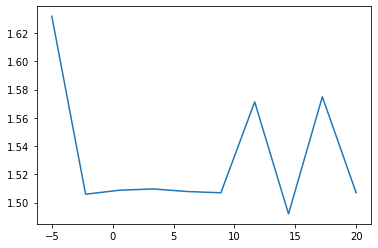

In [21]:
# Large rho tau: varying sig2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = np.logspace(0,10,N)*w2*rho/100
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.min([np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)]),[2]*rep],axis=0)) for k in range(N)]
#transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
print(transition_m)
plt.plot(np.linspace(-5,20,N),transition_m)

Something excitingly weird is going on
thnow=-5.821158994151202, thprev=[-5.99022831 -5.46009036 -6.1430029  -5.65487416 -4.23711759 -3.86207319
 -4.5096731  -5.68366885 -6.44779689 -5.40268171 -3.67507103 -4.8222803
 -5.86506479 -4.44816631 -3.8254703  -4.80765972 -4.88278961 -5.01129953
 -4.82326257 -6.11511002 -6.53302867 -6.711878   -5.24880206 -5.96731563
 -5.27963562 -6.11017505 -4.79703737 -5.55573542 -5.21541449 -4.78717224
 -5.17401276 -5.6499277  -5.76488952 -5.4078642  -7.70821989 -6.27239595
 -4.74013681 -4.26054686 -4.02037358 -4.54793649 -4.8820768  -6.25490555
 -6.00308887 -6.13325245 -6.8294273  -5.99422571 -5.54292165 -5.99291985
 -6.67077306 -7.27256671 -6.68428027 -6.0540535  -4.08265002 -5.96361819
 -5.57486708 -5.91476697 -6.41126252 -6.45722691 -6.96101796 -7.16228177
 -6.46791018 -8.95640792 -7.62620574 -6.39257772 -5.33855131 -5.07175258
 -5.87646899 -4.42787774 -4.55822826 -5.35906281 -5.141702   -7.0192317
 -7.50107438 -7.01307295 -6.80038486 -6.49782078 -5.94

C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Something excitingly weird is going on
thnow=1.4601488289566151, thprev=[ 1.30782478  1.51611092  1.03724602  2.68002875  2.94446899  0.33329355
 -1.17981173  0.79773906  1.35172626  1.11815498 -0.65660778  1.56497471
  0.77901822 -0.63358878  1.9135154   1.98613067  2.24985979  0.1928092
 -0.22451335  0.25621429  2.2038625   1.93811373  2.05626518  2.07189342
  0.66127486  1.93849049  1.79263484  2.02037878  2.20970439  1.93860192
  1.67625525  1.84352221  2.23847538  1.96297669  2.98089125  2.70793549
  1.90764642  1.14289689  0.6665543   1.93405435  0.83916982  0.62754964
  3.7513173   1.29060287  2.6228123   2.64423902  1.3081827   4.30130794
  1.32948437  1.76646548  1.51174233  0.74851072  1.35026733  2.63149366
  1.68735294  1.95379322  0.85832792  0.38756987  1.66556923  2.35688902
  2.32582468  0.26301717  0.82974222  1.5778275  -1.42360924  0.12383976
  0.6166592   0.34753106  1.33109212  1.58272408  1.37819596  0.93079666
  1.85165886  2.35016249  2.43561011  2.32314383  2.5

Something excitingly weird is going on
thnow=-15.287414183029375, thprev=[-15.29359248 -14.88771738 -13.82937661 -14.21407182 -15.31536085
 -14.44389716 -14.85973787 -14.2813938  -13.78128128 -14.7088644
 -14.91649557 -15.16071807 -15.1611462  -17.38247401 -14.56030833
 -15.64000361 -15.50160233 -14.87511246 -13.6015323  -15.12545367
 -15.67799965 -15.96805853 -15.16984116 -15.7997026  -15.02729734
 -15.31678379 -14.80686787 -14.33618465 -15.0064975  -14.30121441
 -13.93674844 -13.74857778 -15.08735637 -16.02953841 -13.86542673
 -16.49654226 -14.62815893 -16.66916489 -16.31627367 -15.27027601
 -14.92918971 -17.02406247 -14.15716551 -17.23017319 -16.53408424
 -16.42419245 -15.14780699 -13.72306799 -15.03163789 -13.51781513
 -14.95077713 -14.89924602 -16.12535151 -15.12099714 -16.33918426
 -16.23509936 -14.31190987 -15.5075103  -15.9564488  -14.55235522
 -15.24561052 -14.77367156 -14.23968843 -15.36817025 -15.7301988
 -13.41260432 -13.96974887 -15.00438269 -15.35156366 -14.71268623
 -15.

Something excitingly weird is going on
thnow=82.00926313274022, thprev=[81.22865001 82.81250562 82.15683839 83.16379605 82.54332171 82.00696498
 82.43238004 81.63750063 80.37541346 82.11086334 82.72021743 82.47523882
 82.76968185 82.03001828 81.09324142 81.93398719 80.33896171 82.04072086
 81.96738773 83.37822189 81.80599807 81.32015641 80.94685498 81.88781672
 82.50734557 82.69050453 81.50107175 79.75596338 80.96617247 82.42612582
 83.133718   81.81976262 83.24722265 81.49173518 82.71273593 82.54667556
 81.38790827 81.18378992 81.61639582 81.85488295 81.99073861 82.81529992
 81.21583924 81.41210908 81.10368638 80.22166967 81.88622681 83.01064076
 83.2072076  81.99439399 82.68900497 81.569201   82.59204637 82.59971844
 82.63853519 83.03481138 81.89953152 82.07655033 82.79416494 80.07009975
 81.84090962 83.15817733 83.15682399 83.00751072 82.95062365 81.42103896
 81.60511079 83.31881352 83.70830003 83.35256068 82.75445676 82.77182492
 82.53531759 82.27092615 82.68530987 80.01655371 81.4

Something excitingly weird is going on
thnow=-104.29135828821322, thprev=[-104.4514375  -104.40195269 -104.7011235  -105.85343401 -105.08213267
 -105.25805986 -104.35299085 -103.69006332 -104.84235527 -104.87224081
 -103.68213918 -103.68417328 -103.01863526 -103.09993087 -104.64439038
 -105.20832833 -104.49947214 -104.66433591 -106.37388655 -103.51640522
 -104.51900868 -103.23641652 -103.94114588 -104.33096532 -101.03161575
 -103.44037698 -104.3947273  -105.17870253 -104.60251187 -105.58176587
 -104.42909905 -103.80487877 -104.36673834 -103.88145807 -105.06881155
 -105.67041504 -106.42009911 -103.23648713 -102.28674125 -102.57268993
 -103.15924728 -104.01699267 -103.38977091 -103.61267998 -104.04928881
 -105.10782091 -106.22886422 -104.69768609 -104.34075515 -104.60544162
 -103.38300493 -103.57244785 -103.31184673 -104.44759698 -103.50936859
 -104.35548902 -104.19952804 -103.59064855 -103.98257012 -104.74325442
 -103.0714549  -104.37410574 -105.69222005 -103.97061639 -105.29478971
 -10

Something excitingly weird is going on
thnow=-136.44344753121428, thprev=[-136.23556187 -137.68434385 -136.49886579 -136.91476063 -139.07936006
 -136.11684154 -136.72251854 -136.32807012 -137.22462815 -137.50663244
 -136.27391252 -134.68519409 -136.21586306 -134.22643627 -135.39441373
 -137.41855599 -137.82304465 -136.39309382 -135.36160156 -137.56849563
 -136.02367943 -136.18637446 -137.84486636 -135.93489096 -136.94252168
 -135.91272091 -136.24152963 -138.17687122 -138.03677635 -137.5140762
 -136.66647652 -136.17318326 -135.74076643 -136.4094091  -135.48413513
 -136.58980911 -137.14533603 -137.34213673 -136.23947895 -136.41965263
 -136.36505698 -136.45271317 -135.91541047 -136.21425135 -137.31249142
 -137.9500486  -134.56607806 -135.69260031 -134.60028167 -137.0128034
 -136.09176106 -135.34014004 -135.74686703 -136.69460396 -137.96014147
 -136.84087538 -136.44459702 -136.59510528 -136.59300491 -137.50824508
 -137.04758106 -136.17195306 -136.18477044 -136.40305681 -136.63552622
 -134.

Something excitingly weird is going on
thnow=-55.6928042901393, thprev=[-56.9353561  -55.79520415 -54.88760458 -57.05923797 -57.12964247
 -56.95893552 -55.99515255 -56.55411006 -55.91278366 -55.50660213
 -55.52847115 -54.90953067 -56.23501531 -55.96176119 -55.73693672
 -55.651934   -56.34852004 -55.3575791  -55.89461041 -55.24645556
 -55.52435115 -55.02403937 -54.9707924  -55.14956465 -56.20506641
 -54.38690267 -55.58571603 -56.26715382 -56.47869021 -55.59345085
 -57.16402711 -53.69622277 -54.06382174 -54.92796759 -54.26403935
 -55.62862363 -55.52976947 -53.5226106  -56.23608462 -55.97380603
 -54.60914927 -54.95410314 -56.47535412 -56.53734202 -57.74711981
 -56.1572683  -55.8340991  -53.63688441 -55.87446535 -55.74482781
 -56.28679739 -55.872502   -55.05558652 -54.8986356  -57.1040381
 -58.08152324 -57.26010052 -55.58127194 -56.01541362 -55.00898295
 -55.17690253 -56.21854245 -55.63218818 -54.85678264 -56.5855268
 -57.93468851 -57.19622193 -54.96885548 -54.08708396 -54.02025278
 -54.14

Something excitingly weird is going on
thnow=61.42520190493673, thprev=[61.50895215 60.37280277 60.31448758 61.43341387 60.24735724 61.79585683
 60.68198208 60.73688237 59.39135293 61.23127667 60.70321713 61.30323078
 62.01577529 63.45942879 63.65817767 62.94952425 61.5376976  60.20313733
 61.84451609 62.04245281 61.10682396 62.08931814 62.59986865 61.12200218
 61.81867914 60.20655587 63.64371867 62.50039101 62.80211996 61.47627677
 60.79850915 59.59897674 61.02124121 60.84488069 60.73378126 62.12335173
 63.00234863 60.3370496  61.06774968 59.87786861 61.07424225 61.63024874
 60.18658166 60.73516998 61.19838844 62.20362148 62.67472069 61.24521765
 62.54310229 63.06157974 63.38959011 61.54453421 63.01276811 60.75693743
 59.67698995 62.5296664  62.03202069 60.55254019 61.44195019 63.05972423
 62.37217622 62.18408819 61.81257166 61.45535839 62.35892812 60.49452783
 60.62462208 61.41922387 61.97192099 60.39304778 61.43685963 61.18720758
 59.84496748 60.6654227  59.59927651 60.30635037 60.7

Something excitingly weird is going on
thnow=-294.1331864461737, thprev=[-292.86962755 -294.2509165  -294.53641774 -294.8240345  -294.74251412
 -295.73791113 -294.92914553 -296.13304356 -295.3519608  -294.61566869
 -293.4066647  -294.15835961 -296.05171678 -296.65770206 -294.31434866
 -294.90273355 -294.81027423 -295.58516254 -294.25506368 -293.4988902
 -293.02578187 -294.72330684 -292.63392699 -293.55691763 -293.40092084
 -293.06554845 -294.23370714 -294.39179426 -295.0172019  -293.87604211
 -292.20675259 -292.91167148 -294.08281857 -295.13395034 -294.92564147
 -293.93705497 -293.98189183 -294.83232085 -294.42623766 -292.17616576
 -292.16715315 -292.93808342 -293.6983633  -294.23101539 -293.95594364
 -294.04622616 -295.29394907 -294.533623   -293.48613841 -294.40333907
 -294.16742417 -292.54194432 -293.5265984  -293.41635526 -295.22230963
 -294.41517167 -293.91839936 -295.70334976 -294.34585035 -294.03313866
 -294.84627859 -293.79757542 -296.39872142 -297.19478925 -295.64549815
 -294.

Something excitingly weird is going on
thnow=-13.667538163933118, thprev=[-14.51520723 -14.51059643 -12.74316862 -12.22488647 -13.94092837
 -14.31295885 -13.42488662 -12.41878608 -11.34662982 -12.47965725
 -12.94408848 -12.7295818  -12.74224855 -13.03529888 -11.74172097
 -14.54423786 -12.56911686 -12.96574265 -13.17188729 -12.96635563
 -14.01218926 -14.42539318 -14.53932711 -14.30414671 -12.70650029
 -14.07393301 -14.49899355 -14.1121818  -13.41066733 -13.59772207
 -13.85700129 -15.11618651 -13.96210398 -14.56116483 -14.67699228
 -15.24300079 -16.19298486 -13.91276301 -12.8913768  -12.72687587
 -14.22489368 -14.23566099 -14.28724371 -12.58827804 -14.28633819
 -14.50339972 -14.47572806 -14.39676611 -14.81262366 -14.60588256
 -13.88275439 -12.82884325 -12.20645038 -13.20427954 -14.29114701
 -14.58452821 -14.11117522 -14.26401335 -13.08734094 -13.95029124
 -13.84934498 -15.00158084 -12.55219699 -12.93971648 -12.69077317
 -12.14146159 -13.42729486 -11.94930398 -13.70278039 -14.96672619
 -1

Something excitingly weird is going on
thnow=8.483175126637095, thprev=[ 9.8042116   7.07961086  8.89513771  7.70319415  8.265175    8.41669252
  9.43596885  9.00863226  9.61774175  8.6252059   9.50259663  8.91649663
  7.37406032  9.11665335  9.23366394  8.30237364  6.47007138  7.09176711
  8.64402772  8.60634919  9.0346023   9.32063077  8.95289877  9.02404839
  7.75711474  7.44793084  8.51996914  7.03424598  7.3188159   7.45397879
  9.92537861  9.24166509  9.23950328  9.76869482  7.54603311  6.65946157
  8.53341141  9.5143136   8.8109399   7.75281332  8.03602543  6.74207978
  8.42311127  8.9220351   8.51820278  5.98201191  7.91460895  9.26892932
  9.80338585  9.48488908  7.67600218  9.02667991  7.40230514  7.0637367
  8.56112344  9.46315851  8.54593697  9.72367758  6.17746575  8.48160786
  8.65646119  8.88422207  9.45713199  9.77212564  8.69295936  7.38815958
  7.95234283  6.86131096  8.87768906  7.39431496  9.21371136  7.54404758
  9.64840931  8.24660215  7.53483906  9.15027546  9.22

Something excitingly weird is going on
thnow=2.959499000719554, thprev=[2.91640746 1.76707569 2.79255194 2.86773299 3.26249427 3.25382191
 2.58747267 3.95675544 2.46638951 3.31132259 2.28268877 2.11270003
 2.84252072 3.89713216 2.13641257 3.7564145  3.26833689 2.31406816
 4.29193541 3.9389281  2.6453554  1.91707388 1.7717796  2.67073624
 2.62611466 3.03890155 4.65824348 4.02736822 3.68743829 3.06283968
 3.09265344 2.27126553 2.44628066 1.75086549 1.45805818 1.72005628
 3.55615435 4.41933637 3.99579303 5.06626337 2.02907605 2.74360945
 2.02403519 3.4407723  2.61663245 2.95124389 3.25212861 2.19660999
 2.10258978 2.49969874 2.57576304 1.60454314 1.95831568 2.31453919
 2.14472391 2.2687748  1.82050293 1.87177424 3.349873   2.18054923
 3.5633475  2.39394755 2.70471309 2.8652144  4.83817265 4.29720997
 3.81815781 2.83677738 2.00359252 2.8773631  2.45690074 4.51666584
 4.59715189 1.78968495 2.51821524 3.09400936 1.68374533 1.89991178
 2.96307573 3.61978752 4.24109149 4.16464622 4.34649716 4.

Something excitingly weird is going on
thnow=-2.330258119039282, thprev=[-3.14433711 -3.24027145 -2.30168713 -1.05652563 -2.23846976 -1.7053831
 -2.54418756 -3.36445161 -2.01489112 -2.69940909 -3.98091975 -4.33092837
 -3.57246313 -3.74259003 -1.61555181 -1.68563677 -1.58649729 -1.48836668
 -2.5343669  -2.99029339 -1.75874759 -0.89237788 -2.04708081 -2.90619943
 -2.43522559 -2.74136607 -3.10081082 -2.59265584 -5.17258969 -3.12574615
 -2.17010475 -3.41209697 -2.138554   -3.129281   -2.01384857 -3.69011834
 -2.75269137 -1.76106402 -2.1762496  -1.96591997 -2.03485794 -2.98631818
 -2.07420669 -1.50687356 -3.29318084 -3.0985646  -1.76219517 -2.91157455
 -2.27094876 -2.41699918 -3.46606462 -3.91176195 -5.6622829  -3.7364303
 -2.01805896 -2.8711479  -1.18292344 -0.41048823 -1.99426659 -2.04876006
 -2.1030778   0.03004968 -1.41437839 -2.82187399 -1.14305324 -1.71418762
 -2.32887925 -1.15983676 -1.74852482 -3.42756283 -2.81458683 -3.92722475
 -3.13084624 -0.68911988 -0.2139321  -1.99332603 -2.57

Something excitingly weird is going on
thnow=-24.800959286120264, thprev=[-22.9204653  -23.51797742 -22.90062036 -23.91696375 -24.87521921
 -25.23411208 -24.93332872 -23.98759497 -22.97578803 -23.78892067
 -24.44255442 -24.46809749 -23.30940885 -25.02774207 -24.2844239
 -26.055719   -23.02736486 -23.62176216 -24.13270297 -26.06368629
 -25.91770669 -24.60426843 -23.27149504 -23.07976932 -25.89198146
 -25.20952607 -24.56126308 -25.15660653 -24.86368752 -24.87691391
 -25.52125733 -25.81592758 -23.9494428  -25.06324743 -25.49731568
 -26.72362305 -25.33836446 -24.74579142 -23.57375832 -23.50618305
 -25.10124654 -22.53759428 -24.34921171 -25.61715733 -24.4076422
 -22.89123888 -26.35353073 -24.06901387 -26.53511617 -25.48133901
 -25.50678708 -25.25199146 -24.3323254  -26.17216566 -25.48942
 -25.61764064 -24.71677964 -25.79842741 -27.16801277 -26.36231542
 -23.96274661 -24.58229866 -26.01814253 -25.39691916 -25.13277369
 -23.56228661 -24.40420411 -24.6499442  -24.40794961 -23.03880757
 -23.790

Something excitingly weird is going on
thnow=38.503959475233785, thprev=[39.3482826  38.22412145 38.39203738 37.05014299 38.85121441 36.66272864
 37.53128902 37.66431582 37.60660113 37.76092715 35.9079842  37.30858526
 38.70323412 38.64666392 37.58191056 37.54969333 39.77452712 38.94786448
 37.02710378 40.63752084 38.59551319 37.79693746 37.73871876 38.00483944
 38.62767919 37.8201093  39.33771712 38.40347675 39.73222093 39.20171399
 38.06375632 38.0277872  37.63207646 39.60621437 40.20175415 38.9043978
 38.17294394 39.30775597 40.5402465  38.79727617 40.04151559 37.27650103
 38.37161343 38.32189978 39.37728951 39.17068224 39.35729475 38.64368295
 39.12052409 37.52074716 38.52751197 37.74496258 37.46193134 38.95826325
 38.95031549 39.84785312 37.2355112  37.71686667 38.8238176  37.43235027
 38.68488526 38.80573634 37.90332046 36.67974584 36.41811099 38.50340674
 37.67257437 37.35307635 37.61992289 39.52555962 38.22596014 37.67407958
 39.49126424 40.61543237 38.73323488 37.82665626 38.7

Something excitingly weird is going on
thnow=-30.576922723359534, thprev=[-28.83812671 -29.30919313 -30.25129515 -30.21433798 -30.55851999
 -30.05759351 -30.6674588  -32.5061004  -31.14824802 -31.62459775
 -31.1387411  -28.80279027 -30.74971309 -31.03468331 -31.33051239
 -31.92207849 -31.18222678 -31.44479304 -30.9088207  -32.40040554
 -31.3862665  -31.84539263 -31.14685192 -32.12753775 -29.56593827
 -29.39008775 -29.27674807 -30.2175888  -29.9861829  -28.93108045
 -30.00074843 -29.23053714 -29.15339047 -29.58546227 -31.10650035
 -30.95740371 -31.82918442 -30.28884505 -30.3509185  -31.10782341
 -31.32041259 -29.34266923 -31.37449585 -31.67589981 -31.42488936
 -32.41390672 -29.91627154 -33.09666681 -29.41719156 -30.07353679
 -29.23536734 -30.48700808 -30.12925641 -29.90823801 -31.1792374
 -29.86857064 -31.96963404 -30.67207291 -31.21571545 -30.96675696
 -28.97142032 -28.75874415 -30.86471042 -32.60429096 -29.89766378
 -30.72220109 -30.09553127 -30.24493352 -30.72183543 -29.30650217
 -31

Something excitingly weird is going on
thnow=-141.32193368152383, thprev=[-140.79899148 -141.19983509 -141.51613023 -139.66205597 -141.16654206
 -141.93225602 -141.84118553 -142.24341069 -141.47079587 -141.70672318
 -142.46887914 -142.88031461 -142.62389324 -140.6752806  -142.26155783
 -143.95595528 -142.31860386 -142.74530883 -140.27439756 -142.85555339
 -143.57027529 -141.23142808 -140.44212957 -140.32389298 -142.4369246
 -142.51885612 -141.82584311 -142.14202283 -141.03142007 -140.93571133
 -140.42599348 -140.73916616 -141.29371086 -141.37615647 -142.22034792
 -142.80413214 -141.89904358 -141.87216929 -140.07996811 -139.7691825
 -140.68273487 -141.36862895 -139.59690144 -140.3424203  -139.50466267
 -140.63430731 -140.46180509 -141.29938151 -142.15369452 -140.11047464
 -141.07486136 -140.83007646 -142.01180917 -142.54500353 -141.5483529
 -141.38106815 -142.07004696 -141.28473105 -139.57357373 -141.12824994
 -142.41569912 -141.14921468 -141.2552575  -142.32874511 -140.49517678
 -140.6

Something excitingly weird is going on
thnow=46.63811358920279, thprev=[44.87494965 45.4832522  46.28349108 46.82507468 47.58734578 46.51844431
 47.22595711 47.73048471 48.6571024  46.32619216 46.58019681 46.96120333
 48.91572972 48.32962007 46.79430324 45.14134649 45.67994673 45.5403132
 46.38289802 46.16195229 47.28515901 47.61261529 46.65633289 46.43953995
 45.14770326 47.6771323  48.90130832 47.82372607 45.5507104  45.57580604
 46.16637337 46.02322315 46.65317533 46.43135518 47.74559309 47.25726464
 46.08539297 45.71922879 45.8307891  47.75583286 47.06403829 46.21457699
 44.55786822 46.17591083 45.9100291  47.22302596 46.58099082 46.03096988
 45.70651896 45.68053961 47.66731566 48.21331946 46.93429193 46.84377067
 46.16751623 46.09455042 45.59472385 45.65169888 46.57542905 46.86729321
 46.37819646 46.27341581 48.02539507 46.802883   47.01990951 46.09183998
 46.93442937 46.70555513 46.3740059  47.32348989 48.11029732 47.74867359
 45.92933748 45.88219482 46.73711252 47.94749531 45.17

Something excitingly weird is going on
thnow=79.36045273797862, thprev=[78.87010443 78.57136914 78.09976206 79.2091943  79.73232281 79.94555795
 79.72900874 77.96787928 79.13117466 79.21953922 80.93843248 79.45009646
 81.00379918 80.09004583 80.15767724 79.49122661 79.25061615 78.20984923
 78.4143888  79.80250712 80.06882478 79.50159723 79.7578394  80.09507592
 79.24464179 78.46853902 78.76491    77.83362451 78.94087461 78.09681315
 78.14425161 78.71443951 78.18967891 79.06549713 78.05385131 78.60219773
 80.24708721 79.36732646 79.48934032 79.71278725 79.55765282 78.8642546
 80.55509114 79.97298253 79.07325551 78.26168308 77.71020445 78.69276567
 78.55489096 79.15868958 79.66553881 78.86486275 79.75228437 80.03912819
 79.44643157 78.30002242 78.97828199 80.96296066 79.56328668 79.90390152
 79.38232553 79.04008377 79.36039264 79.76484337 78.84697672 79.03637497
 80.32782495 79.5858368  78.15979607 79.15348032 79.71472062 78.21518509
 79.93324796 81.28226105 78.38678418 79.97904479 79.14

Something excitingly weird is going on
thnow=315.8924712240243, thprev=[315.39496139 315.92264256 317.20629595 316.31469931 316.80734325
 316.52544504 315.51382607 316.00131844 317.15959679 315.80954351
 317.12925395 315.41721823 314.57837623 314.9001706  314.44367429
 314.73202427 315.29765363 315.81952425 315.63512878 315.41698658
 315.50148595 315.50269404 316.85066966 317.24626075 316.38297014
 316.15617812 315.31202448 316.70752393 317.6476547  315.74420185
 315.11597698 314.40229618 315.48855026 315.68903959 316.81878049
 315.67506683 317.08272701 316.07897153 316.48100892 314.18320932
 316.73745447 315.58699387 315.70208528 317.5467567  317.34955096
 317.42349306 317.18787484 316.16977312 315.30619534 315.79074664
 314.99885933 315.69292936 314.73035448 315.61482224 314.55073884
 314.24428269 316.75863304 317.12134829 316.2486945  315.84654362
 315.77327016 316.15692751 315.95400164 315.21139365 315.36437172
 317.80017356 316.27217515 315.5830466  313.30616798 316.48082388
 315.

Something excitingly weird is going on
thnow=-95.87389419701213, thprev=[-96.7725135  -96.92991458 -97.08943797 -95.93690943 -95.57221391
 -94.99525177 -95.11291649 -95.04689282 -93.83241885 -94.16549249
 -95.49508242 -95.39086773 -96.76720688 -96.24588248 -96.26502194
 -94.30441742 -94.17269858 -95.41835232 -96.32019233 -96.00597503
 -96.47124249 -94.68646258 -94.95409527 -95.21436526 -92.83928647
 -94.64266552 -94.73793363 -93.74168378 -94.22328525 -94.53876141
 -96.43735208 -96.8654988  -97.04565934 -97.4295996  -95.68424277
 -96.15216474 -96.11100736 -97.62115943 -96.42559947 -97.38836531
 -95.28772544 -94.7020994  -95.84550386 -96.18918938 -95.08832866
 -96.36282394 -94.63317302 -97.33011516 -96.13910229 -96.96772943
 -94.47809528 -95.24369165 -95.36151675 -96.73079862 -96.13185361
 -96.50224051 -97.14728704 -97.81341534 -95.97343758 -96.51898624
 -96.66180122 -94.5368928  -93.59730957 -96.1166833  -97.14679409
 -96.85751012 -96.82733618 -95.81533893 -95.21290661 -96.40701176
 -95

Something excitingly weird is going on
thnow=-27.699702379961717, thprev=[-28.43647477 -26.71863698 -28.92459306 -29.13653705 -27.92937039
 -26.65174289 -27.07185071 -27.30423856 -27.88659758 -29.61623093
 -28.74854558 -29.98961931 -29.94818038 -29.18918233 -28.17038139
 -27.76181806 -27.06662737 -27.1898961  -27.37213069 -26.8886046
 -26.04683228 -28.74663414 -28.14451443 -26.80652231 -29.04919482
 -29.88197591 -28.08591762 -27.16756836 -27.95986301 -27.93755279
 -28.93343259 -27.55682683 -26.83498953 -27.59384537 -27.69504335
 -28.2189872  -27.78468654 -27.67268666 -27.19564001 -27.84126245
 -29.07330393 -28.3711184  -26.83684143 -26.84315818 -28.53131571
 -28.0428833  -27.54451429 -26.76354053 -27.98794438 -27.65658399
 -27.24575903 -26.00841393 -27.80338268 -28.90621085 -26.90803999
 -27.26632574 -27.20491196 -26.36731023 -26.01084092 -27.11276713
 -26.55588986 -27.66471453 -28.71731864 -26.92461628 -28.05673704
 -26.6806209  -27.0836568  -27.40887708 -26.82315081 -29.25740469
 -26

Something excitingly weird is going on
thnow=-50.40745785136014, thprev=[-50.38911484 -49.08521941 -49.27593277 -49.98819052 -51.52026508
 -50.78902182 -51.18147376 -50.88453702 -49.44487304 -49.16182857
 -50.12074959 -51.03747914 -51.42337668 -51.49781872 -48.89609402
 -50.39813041 -50.12576079 -51.24246601 -51.69820048 -50.41157551
 -51.22902267 -50.64958573 -49.53639739 -52.22253512 -50.66884687
 -51.40085075 -50.1332777  -49.71399652 -50.20245528 -50.48932914
 -49.72113611 -50.15136621 -50.62538898 -50.21422932 -49.93442113
 -48.91692533 -51.1296066  -51.56814285 -49.77706444 -49.17108321
 -49.28966828 -51.5227099  -50.60410303 -50.1855734  -50.70365343
 -50.15624872 -50.55752354 -50.27902524 -50.44451393 -48.81103874
 -51.65695225 -52.40944467 -50.55005748 -48.94118016 -51.64332297
 -50.4827213  -51.78185371 -50.66831943 -51.96214381 -50.64607518
 -49.7355004  -51.21545403 -50.02565315 -51.35615588 -50.09280814
 -47.41509118 -48.44029667 -49.14564084 -50.8901435  -51.57850741
 -49

Something excitingly weird is going on
thnow=6.632001606205041, thprev=[6.85799721 6.89059176 5.57851721 6.9847579  6.92173812 8.07631009
 6.18949833 8.14708158 8.18430231 7.52553667 7.36036936 6.34006139
 5.98721011 5.24283823 4.95674553 6.68894736 5.90394082 5.24778671
 6.53127872 4.4997724  5.22110693 4.83270137 5.75775731 7.07829688
 4.88434164 6.01131133 5.36624051 6.21244659 7.36082533 5.97899091
 6.40132652 5.24358535 6.11154425 6.5645248  7.33136813 5.98623356
 7.69161586 7.31209452 7.7033089  7.14549527 5.68095567 6.21042154
 7.40187311 6.32930707 6.72434199 6.77044908 6.07885426 6.25209315
 4.09110482 4.72325089 7.39634421 5.39341426 6.08107225 7.57029519
 5.85476821 6.99410667 6.48817206 5.95740369 6.867816   6.57986952
 6.19336807 5.91632586 5.75878458 5.08960632 8.07314562 8.22946855
 8.40757173 8.51002976 8.76716337 7.39607146 7.1920267  7.18284658
 6.62240541 6.43746071 6.91392495 7.02739195 8.28964335 6.06589107
 6.68228386 7.78497783 7.93921672 7.50144411 8.11152545 7.

Something excitingly weird is going on
thnow=89.13439982013192, thprev=[88.8393729  89.99430838 88.20714392 88.43651998 89.05029094 88.24753703
 90.22982443 88.68383461 89.7321303  88.90892426 87.58178392 89.3853873
 88.34073971 90.96482493 89.78387976 88.08298946 88.25600628 86.69727866
 89.05543094 88.93630267 88.80851213 87.98686971 88.5094597  88.34731422
 89.62203528 89.57140347 90.26528492 90.06999955 89.9084352  89.35470422
 88.25158809 87.81553988 89.00170674 87.86689176 88.89295391 90.35903702
 89.30634566 90.06914898 88.62362303 88.76302803 88.98371568 88.91233855
 89.39564104 88.68585804 88.18277195 89.41906535 89.08101064 90.34109361
 89.4496783  90.0620587  90.7499603  88.91813101 89.42802955 90.66264933
 87.97181798 88.32116175 89.5865653  90.47533762 88.41946713 88.02635862
 88.92678016 88.58571833 89.12844798 88.37328675 87.35628651 88.4374111
 89.60254805 88.29984777 88.56135744 89.27935274 89.34241012 91.44152349
 89.16043426 89.21781275 88.04397278 89.69603043 89.899

Something excitingly weird is going on
thnow=-33.756918469908385, thprev=[-33.6721109  -34.90980505 -34.33607166 -34.45128069 -33.88466749
 -34.39527633 -32.27034935 -34.79463903 -34.08212542 -33.32190998
 -34.5533421  -34.7896019  -34.58940784 -33.31218704 -34.84767679
 -34.52476762 -34.45444503 -32.17525004 -32.66739104 -31.90608536
 -33.12711333 -33.76693    -34.70022231 -33.21168443 -33.58588769
 -33.54969422 -33.11803642 -33.98875258 -34.87434042 -34.41911578
 -32.72301081 -33.52938522 -33.11607314 -33.35911118 -33.75916057
 -33.22844992 -33.93059712 -34.32349161 -34.45361235 -35.61291059
 -34.78875203 -34.24565938 -33.61108294 -34.80254741 -32.4227627
 -33.21708026 -33.75248178 -34.9269812  -33.27291273 -33.77915759
 -33.29883192 -33.12461537 -34.93046733 -32.96760298 -35.49982682
 -34.07047435 -34.91430082 -33.34844865 -34.49774191 -33.23081278
 -31.87778507 -33.62517864 -34.01574905 -35.08405323 -33.07312176
 -34.33701892 -33.23222364 -34.52290048 -33.90194408 -31.6247837
 -32.

Something excitingly weird is going on
thnow=4.364923581800375, thprev=[4.05679795 5.45743231 3.69273887 5.57071043 4.54392566 5.35705984
 3.96092513 3.99642225 5.75479852 5.11178018 5.09622447 5.4707278
 3.14824551 4.75903394 3.97780665 4.24442483 4.31079106 4.81785305
 3.8378119  2.35262895 4.16115181 2.67129351 3.46930163 2.95335206
 4.59136296 5.53936007 3.37127443 5.81043227 5.88582024 4.86300741
 4.61908837 4.38593052 3.3768549  4.39479145 5.57831163 4.88042494
 4.6004643  3.69833633 3.63749054 4.06218017 4.02044011 3.51810056
 2.60977158 3.32018322 4.71056493 3.32732453 3.38103337 4.17114347
 3.81777292 4.18366115 2.68100598 4.6512906  4.70327    5.31575536
 5.2193689  3.50751945 4.19709591 4.10710484 4.51560577 3.45513163
 4.94747072 5.16454789 5.85231422 3.71203841 3.58129938 5.00742804
 3.79872723 3.01365709 4.64308887 6.42014528 5.93095101 6.11936847
 6.71407572 3.42755132 3.75755247 3.58559003 4.00878445 4.45824107
 4.8577603  3.46882172 5.07059299 4.20567324 5.2895277  4.7

Something excitingly weird is going on
thnow=19.36165402444938, thprev=[20.03787981 19.24372171 20.24795304 18.26834648 19.94876712 19.69572818
 18.32182021 19.37288018 18.67390687 17.97379484 20.60270302 19.31525034
 20.85960127 18.59063042 19.8470577  18.95878775 20.67469623 20.67903582
 21.35908848 20.92487681 18.7091572  18.81595344 18.81323853 18.58179907
 17.69167574 18.11110476 18.31811781 16.3574189  19.03808819 18.86688318
 19.5174469  18.7311724  18.46279095 18.58289978 19.15005014 17.74093763
 19.66002718 20.23891655 18.05741909 19.62430216 19.08808684 20.82493457
 20.29873829 19.87345678 19.34811087 17.47807981 18.01444132 19.86429471
 20.42782719 19.99658492 20.25616054 20.12020345 18.83222194 18.50456181
 19.65911011 19.3554954  18.26866023 18.81057557 18.71487571 19.55815365
 19.66719515 20.03845975 19.63784058 20.47427894 19.75820898 20.91633119
 18.38589778 18.35713217 19.80919107 20.45336341 21.74336797 20.72992089
 19.57775336 18.33134016 20.16979081 20.34511782 20.6

Something excitingly weird is going on
thnow=43.643990035261, thprev=[42.61767304 42.81183004 42.65499178 43.35114533 41.69115017 42.14586671
 43.43559519 43.33690554 43.97735422 42.84241083 43.30166767 43.07925148
 44.09835774 43.90798494 44.92418504 46.13159587 44.78784429 44.49632312
 44.00562512 43.3743262  44.060208   43.83434857 43.83558909 42.86567931
 43.62217783 43.74542322 43.84921885 44.10061334 43.7063787  43.67779764
 43.62048062 44.5512418  41.69667374 41.82002623 43.24781892 43.08661086
 44.08138194 44.88151673 45.13310438 44.85101644 43.16019835 43.92605797
 43.81305871 42.89990598 42.98240423 42.59298178 43.81059749 42.76756494
 44.41337088 42.22923624 43.12384421 43.19888587 45.19819081 45.20901217
 45.6038901  44.26921781 43.78836969 44.23930399 43.4557928  42.36932819
 42.32578861 44.72572634 43.47192558 44.17559912 44.06735755 42.85107633
 45.41929017 42.66529655 42.97198606 44.15820193 44.38277677 42.59678019
 43.44066795 41.75965101 42.1835584  42.44392785 44.453

Something excitingly weird is going on
thnow=-26.314229716415998, thprev=[-26.47407623 -24.50163343 -25.27417756 -25.06043226 -25.08797358
 -26.03172345 -25.97838895 -26.47553677 -26.90776133 -26.55045116
 -25.4785818  -27.70635039 -26.70299152 -28.02421131 -26.90174496
 -25.32819801 -26.24910854 -24.95270173 -25.05456315 -25.55512813
 -25.23454021 -27.20567217 -26.31131985 -26.34034282 -26.9358889
 -25.19240823 -24.53419932 -24.96761219 -25.10295808 -26.0580492
 -26.22570924 -27.92050246 -27.78303237 -26.37077207 -24.04639893
 -24.77437787 -25.62769243 -27.24169991 -26.6388538  -27.55836625
 -26.16367108 -27.80397675 -26.27689285 -27.30027554 -27.92149754
 -25.98078162 -26.49387602 -26.34989566 -26.23242192 -26.68806668
 -27.54802319 -25.9814551  -26.48843497 -27.00108239 -26.33107809
 -27.7316092  -25.71445052 -26.59988529 -26.63281669 -25.30975845
 -27.45606654 -27.46828078 -27.11526127 -26.5965362  -26.4911693
 -24.51123663 -23.69843157 -24.93306102 -25.70647569 -25.60726397
 -26.3

Something excitingly weird is going on
thnow=-145.18968238062823, thprev=[-145.5178599  -143.30560171 -143.83992274 -146.28021713 -146.27583648
 -145.81903777 -144.82541364 -144.6738514  -143.50129328 -144.0855612
 -144.65075222 -144.39766512 -146.55120907 -145.1964019  -144.8253814
 -144.50967532 -143.55319747 -145.77294024 -145.30670352 -143.71922885
 -144.48942323 -145.26682512 -145.36006553 -144.94834222 -146.51735851
 -144.084146   -146.49974345 -146.51599972 -145.15600842 -145.73755248
 -145.04668656 -146.51138563 -145.94790218 -145.40243704 -145.62733374
 -144.06694326 -145.64586479 -145.51076457 -146.52769426 -145.00599432
 -147.07176522 -145.38674747 -144.46973657 -145.94070948 -146.86930202
 -145.1973562  -145.81955875 -146.38636254 -145.14465388 -145.19209424
 -144.7327698  -144.52041291 -144.62176098 -145.0506988  -144.66538511
 -145.43272924 -146.28986697 -145.46243527 -144.86919019 -144.60994879
 -145.88486865 -144.32384054 -145.47658162 -145.76949714 -143.89125525
 -144.

Something excitingly weird is going on
thnow=113.1617078894319, thprev=[113.77651992 113.68520046 112.97751554 115.74482417 113.71608878
 113.87442455 113.41811517 113.70326893 112.08962455 112.49548444
 110.08208389 114.80138825 113.54987891 114.28177742 113.3940169
 113.36133378 114.37099479 114.79556914 112.55164653 112.27443048
 112.41214049 112.93829238 111.99021429 111.65271434 112.61546399
 113.36832344 113.26765222 113.80152751 111.53741395 112.98262888
 112.97266562 114.46958511 112.53342516 112.55505167 113.60382501
 113.46421578 112.36347136 113.13411339 113.60488611 113.17535265
 111.31935825 112.13859594 111.64907297 112.64331456 112.83777931
 111.44159175 112.76388932 111.55479269 112.47243235 113.13877677
 113.59212196 112.86316577 113.11261789 114.44221466 113.40725464
 114.94961097 113.67881337 113.34563564 115.07577642 113.33433244
 113.08278051 113.74355213 113.96827139 113.53951    113.57668757
 111.87685939 114.61775467 114.66535926 113.8669532  116.17664978
 113.4

Something excitingly weird is going on
thnow=-61.40121218806195, thprev=[-61.52507989 -62.51715835 -62.52997292 -61.69310672 -60.4407179
 -61.26705167 -60.67500829 -60.50067756 -61.2474015  -60.6019994
 -62.17264673 -62.09670939 -60.949738   -62.39167288 -61.44687162
 -60.11386147 -60.450449   -61.47684149 -62.05859034 -60.89050063
 -60.1409325  -61.0706428  -60.5355611  -61.36707517 -61.96932505
 -60.10736353 -61.37499191 -61.06608645 -61.79485625 -61.6743585
 -61.50831298 -62.30295914 -60.57998244 -59.94115311 -59.68971527
 -61.6490551  -61.18197407 -60.67477781 -60.07643141 -60.7227838
 -61.45821118 -61.58012239 -61.7724667  -62.06867646 -61.76536514
 -59.25427609 -61.48375289 -59.8028275  -61.45685148 -60.96913489
 -59.94365883 -60.15882109 -60.7525855  -61.80113442 -61.66582453
 -62.48133842 -60.63919931 -61.90721855 -61.79727796 -61.48880271
 -61.64782809 -62.36694499 -62.14955599 -61.7177669  -61.73205571
 -62.78134719 -60.33525463 -61.97609228 -60.92209206 -61.7894381
 -62.9119

Something excitingly weird is going on
thnow=-100.06891700839216, thprev=[ -97.52521442  -98.05684325 -100.1315908   -99.67259055  -99.43602042
 -100.43539577 -101.79862626  -99.57702782 -100.00626661  -99.12858705
 -101.1747971   -99.52408282  -99.98944443 -100.39694075 -100.01811682
  -99.63258208  -99.05666749 -101.31532621 -100.33527755 -100.84593385
 -101.02536591 -100.25969253 -100.58535791 -100.68041149 -100.05839049
 -100.94491251 -100.70363476 -100.6488971  -100.08686157  -99.36867595
 -101.63981981 -100.9737167   -99.69572371 -100.68970057 -100.68318127
  -99.23662022  -99.55387767  -99.41605736  -99.65942475 -100.3670414
  -99.47036638  -99.24031117  -98.4067168   -99.241001   -101.49151052
 -101.22604882 -100.19325308 -100.09012027 -101.05851999 -101.54217557
 -100.84454344  -98.91299843  -96.91321448  -97.45786018 -100.04063857
  -98.83952675  -99.66960473 -100.55396673  -99.79355022  -99.15035031
  -99.1959233   -99.58258229  -99.88290565 -100.52520719 -100.39408374
 -100

Something excitingly weird is going on
thnow=164.11384700595005, thprev=[162.66509698 161.71286459 163.63263679 163.78156334 164.88131716
 162.99726548 161.87833673 163.21612811 164.11997828 165.24770876
 164.48358984 163.8248592  162.88944258 163.68548091 166.02672225
 163.43732233 164.5710832  163.43452781 164.2498078  163.6354583
 163.47811832 164.91803319 161.7903264  161.57787358 164.3097542
 164.2330417  164.8120068  165.01345157 163.41647691 163.27687363
 165.02080123 164.84860729 164.08826354 164.55935167 164.07907006
 164.26057812 164.75495321 165.07448932 162.10948672 163.56786413
 164.30265903 164.86218514 164.57188541 164.49570031 164.54809331
 165.12074253 165.46180289 163.15310165 164.62715639 164.76690063
 163.76904302 163.0156985  164.85539839 164.83930249 164.83761961
 165.67079642 167.16515256 163.8859829  163.46164615 163.84435446
 163.85943358 163.99231662 162.76054991 162.51913908 163.63337777
 163.86057726 162.95434944 162.90801824 162.41219935 163.74707848
 164.9

Something excitingly weird is going on
thnow=-35.30910124947994, thprev=[-34.79352364 -38.02835697 -36.71040794 -35.49257066 -33.08731571
 -35.77350435 -35.84577769 -35.54011336 -33.50549754 -35.43508676
 -36.90422365 -35.86058222 -34.54776135 -34.6015278  -34.0600786
 -35.286812   -35.82134925 -35.74547304 -36.17977767 -35.80003986
 -35.25075872 -35.32613022 -35.5020538  -34.63089663 -36.05016208
 -34.51820336 -34.84789499 -36.37373373 -35.45458531 -35.75595689
 -35.55909751 -36.41272372 -34.22546677 -35.56393294 -34.79208315
 -35.13207066 -35.87349765 -34.15044141 -34.31677676 -35.42296171
 -35.20509414 -35.78252356 -35.77905126 -35.49570851 -36.71219096
 -35.31120203 -36.73271279 -35.60604875 -35.03004728 -35.55418659
 -36.9771537  -35.45526315 -35.31750953 -35.62024567 -34.09577867
 -33.84053213 -33.67786022 -35.16778212 -34.94167324 -34.37171002
 -34.08026982 -34.62275532 -35.89238911 -36.18673498 -36.19277684
 -34.72506769 -35.01169019 -35.68233205 -35.9670107  -33.75543934
 -34.

Something excitingly weird is going on
thnow=33.39540576752996, thprev=[33.429248   32.68200451 32.17337671 32.281775   34.08252659 32.41228796
 34.08383477 34.57624573 33.12954451 31.46380894 33.01133296 31.65200365
 33.47388266 33.5747963  31.97203283 33.47288833 33.32277433 34.1851754
 33.65217189 33.93999965 33.68352027 33.69916416 34.70536933 35.07676628
 33.70756631 31.64502974 33.01173581 32.71612935 33.90580851 34.74143181
 33.50347672 35.23550053 31.46282434 32.68177667 30.88757407 32.34331189
 32.94808934 31.74337998 33.65030513 34.41587855 33.47183669 35.46005181
 33.05229854 33.81849675 33.43358431 31.97900685 33.56386102 34.64149288
 33.30134017 32.4942758  34.36726942 34.96618604 34.69633715 34.10006757
 34.34420504 33.90711747 35.53662553 32.91046274 35.50229361 34.82776095
 32.8431757  32.70227367 31.33050008 32.75377218 31.88235603 31.3931424
 32.11093626 32.36042807 32.73787415 34.18369975 33.24461869 34.54276421
 33.60503205 33.94820988 33.47274417 33.35192653 33.364

Something excitingly weird is going on
thnow=-150.0868396896115, thprev=[-149.34513356 -149.59858579 -149.24011462 -150.34335448 -148.4074864
 -147.29997071 -147.3142903  -149.40322568 -148.84288854 -149.56634638
 -150.20917634 -151.60830116 -149.28299785 -150.18802551 -150.70705437
 -149.54796959 -149.40687915 -150.21255243 -150.29641277 -149.87758165
 -149.65526518 -147.46132447 -148.68641303 -150.05374853 -150.06327149
 -150.96763936 -150.38357584 -150.87455311 -149.10332843 -150.80693875
 -150.90685964 -151.23714403 -151.73854382 -151.32250767 -151.07996416
 -150.74940062 -150.96410921 -150.21700649 -149.69506938 -150.78449671
 -150.71349826 -150.65982787 -150.39809172 -148.89201976 -150.20637078
 -148.82987867 -149.0025186  -150.74812369 -151.70425223 -150.87349129
 -150.11193171 -150.11266493 -149.79418884 -150.11348305 -151.87707617
 -151.14945997 -150.34084747 -148.6807007  -149.21641601 -150.29222371
 -149.13656063 -149.17365402 -149.76631113 -150.06499876 -150.28395967
 -151.

Something excitingly weird is going on
thnow=12.264957742928177, thprev=[11.84504812 13.64896962 11.77693176 11.65952967 12.23233991 13.5904838
 12.83896113 11.44245088 12.03464871 11.88196147 12.83403342 11.81733258
 12.49598095 11.24796398 13.23603963 12.71721712 12.51903652 13.56008214
 12.74553394 13.46164709 12.84042625 12.24179339 12.31106607 12.01640028
 12.74144041 12.91828106 11.01188588 11.19549158 11.86817454 11.281091
 11.52173487 12.62495873 12.91196232 15.02653832 12.32073773 11.27025348
 13.1821271  12.30198041 11.48852504 12.30068805 12.3424772  12.51150303
 11.13517838 10.95268654 12.05106329 13.67987894 13.10621585 13.13939714
 14.43213477 12.39769572 11.97446439 11.98302021 13.08298264 13.59239144
 11.31893435 10.80910454 11.46215875 12.13868342 12.76903486 11.57741909
 13.67024742 13.35156703 12.13080505 13.03071646 11.42452896 11.87000836
 12.35030087 10.49554969 12.09765686 12.3644137  11.88381064 13.27291118
 10.95304692 12.30829608 11.10362722 10.66409476 11.625

Something excitingly weird is going on
thnow=-48.086690245283506, thprev=[-46.29197814 -47.94589762 -47.90183246 -47.12989906 -49.25685573
 -47.31212678 -47.85109825 -49.21873422 -47.96939856 -47.69343714
 -47.17134072 -49.92389758 -48.20571502 -47.58807597 -47.09266464
 -46.87925041 -47.89464461 -49.83333149 -50.06157785 -47.73378921
 -46.15227864 -47.31890683 -49.2636842  -49.83163418 -50.15120608
 -49.87729376 -49.32758539 -48.68743926 -47.38399589 -47.58055995
 -46.99141258 -49.84222354 -48.48738257 -47.89594748 -47.20640943
 -48.1809397  -48.44808793 -49.03258426 -50.50794382 -48.13234226
 -48.46648946 -48.24836077 -47.45338063 -46.90843191 -47.85422136
 -48.27182995 -48.53318112 -47.39606102 -47.86773785 -47.32553946
 -47.60841745 -48.02515711 -48.77451946 -47.08389201 -47.57292863
 -47.72591533 -48.46079342 -48.78551334 -47.22896609 -46.78579072
 -46.24978321 -47.87373649 -48.75983501 -48.12230498 -46.57446985
 -49.58051468 -48.75778182 -48.35288916 -49.19523936 -46.33258054
 -4

Something excitingly weird is going on
thnow=-6.519885428306825, thprev=[ -6.28334601  -6.80944079  -4.51874365  -5.48999201  -5.40287307
  -6.63506722  -8.77425111  -4.62742656  -5.27676865  -7.06396562
  -7.61786086  -8.10152358  -7.07677092  -5.09656752  -5.78994053
  -5.12442889  -6.51522276  -7.07454312  -6.46638113  -7.77879309
  -6.77219344  -5.89465797  -7.8511895   -8.09431029  -7.18792647
  -6.63591233  -5.67068403  -5.12644788  -7.04604214  -8.57837267
  -6.35261464  -5.68789274  -7.82886866  -7.70611902  -7.40626375
  -7.40900546  -8.11973966  -8.66135702  -7.44382329  -6.43767682
  -6.98386501  -5.64353941  -6.47125756  -5.00626215  -4.9391309
  -6.50006549  -8.51039899 -10.27052841  -8.86685364  -8.20840084
  -7.19811318  -7.16679909  -7.22734068  -7.81356834  -6.10920952
  -5.61036053  -5.72329068  -5.1759372   -6.73422104  -5.88331328
  -4.89867829  -5.8442942   -7.66959085  -6.59851534  -5.11926598
  -5.54415529  -4.54611807  -5.4147662   -6.20707421  -7.50179375
  -6.

Something excitingly weird is going on
thnow=-3.796403936190649, thprev=[-2.67095759 -4.055732   -5.04890586 -4.23109321 -3.45398079 -3.88109956
 -4.33800116 -4.13450593 -4.16517631 -1.86835593 -1.70517852 -2.2342212
 -2.32754417 -2.47022991 -4.5492805  -5.31737447 -2.88561839 -3.3709977
 -2.73241179 -3.32079258 -5.46157663 -2.30014627 -2.57453712 -4.45535223
 -3.8102331  -5.06265103 -3.57573161 -3.2932925  -3.82706857 -3.9348557
 -4.21225525 -3.65649777 -4.13994353 -3.47293802 -3.07539125 -3.02697493
 -2.21085287 -4.39448372 -1.93713524 -2.7599498  -2.29814623 -4.19052122
 -3.15008331 -3.6848268  -4.12570956 -3.17847749 -4.61875971 -4.16181087
 -4.50220759 -2.6703628  -2.83665521 -2.0147598  -2.66486741 -3.68569558
 -3.87231331 -4.06371627 -4.36090869 -5.46951679 -4.21392918 -2.60429581
 -4.19692985 -2.82336304 -2.12444183 -2.31297814 -1.92125825 -2.87213296
 -3.96811117 -4.01139237 -6.23924953 -4.46010556 -4.9820564  -4.76317166
 -6.81428149 -5.75066118 -3.39785423 -3.59608683 -4.081

Something excitingly weird is going on
thnow=-169.55427820257518, thprev=[-168.61101691 -169.37840969 -170.50590366 -169.63480714 -168.1629328
 -169.51909934 -168.72369215 -170.17213756 -169.3537136  -168.64007224
 -167.36809364 -167.95762577 -169.32975277 -170.24832245 -167.26536476
 -169.35336561 -169.45672957 -169.2623596  -169.41245649 -169.09592215
 -167.91144538 -168.64159751 -171.19372823 -169.97520441 -172.46198335
 -169.50598676 -167.30573142 -169.23353678 -169.29757693 -168.88791225
 -169.03203419 -169.71576752 -168.44287122 -169.69119785 -168.72089723
 -167.92680267 -168.43511555 -170.30410919 -170.56963348 -169.21656799
 -170.37621197 -168.14508077 -169.99059406 -171.13116983 -170.08485505
 -169.05847915 -169.98597864 -170.5555165  -170.53815922 -171.38912701
 -169.58041472 -168.69642521 -169.56702249 -170.6154144  -169.91843723
 -170.99899976 -170.6795405  -171.0197362  -169.39589986 -168.36996715
 -169.72604663 -171.43975942 -170.79200087 -170.29907384 -169.77981882
 -169

Something excitingly weird is going on
thnow=-49.06204478923373, thprev=[-47.4688393  -47.90031638 -49.39781152 -49.86158724 -50.17655141
 -48.72946925 -50.07499148 -48.97811584 -48.80017477 -47.26944742
 -49.76449359 -49.57026062 -51.1772147  -48.57986935 -49.73981837
 -47.30535247 -47.67870107 -48.40413087 -50.38447815 -49.62317895
 -50.15489624 -49.31549615 -48.02783156 -49.71805288 -47.16127666
 -48.23326722 -49.30504984 -48.64775123 -47.5638954  -49.18430113
 -50.57122722 -48.88580561 -49.08110209 -48.40367933 -47.49147447
 -47.98543323 -47.65193345 -49.26493845 -50.57482903 -51.42449822
 -49.32103641 -48.7345514  -48.37830547 -49.12384515 -49.96660151
 -50.35745056 -49.48594604 -49.06678598 -49.08138441 -49.19574645
 -47.97603336 -49.36871202 -48.35901263 -48.6041067  -48.53106393
 -49.54315975 -49.46199708 -48.12183807 -49.25664843 -48.78491523
 -48.61782549 -48.36014102 -48.48174932 -50.22351871 -48.74412138
 -49.81494903 -49.54272023 -49.73122762 -50.34191279 -49.3088029
 -47.

Something excitingly weird is going on
thnow=-67.72273954824932, thprev=[-68.12351116 -68.74670593 -65.16450441 -65.16705008 -66.85813985
 -67.50470756 -68.65888906 -68.52017783 -68.46375774 -68.1622122
 -66.74047312 -66.40876769 -67.63999101 -67.23945156 -68.19810718
 -68.73500155 -68.02672673 -68.91066104 -68.35662232 -67.96680104
 -68.94825916 -68.20758991 -68.40027691 -67.34738293 -67.85719516
 -68.75407229 -69.08269354 -67.4649974  -66.02045323 -65.59148036
 -66.86976705 -67.12625554 -67.89174842 -66.81840118 -66.99687628
 -68.98896409 -69.29710506 -69.0573819  -68.54933854 -68.11821678
 -68.27657644 -67.01422367 -66.19940121 -67.6264653  -67.82314773
 -67.2099563  -68.25731593 -68.05642795 -67.20250293 -68.18889177
 -66.72694017 -66.56386958 -67.31352673 -68.17651373 -65.95684307
 -66.60857764 -66.95101595 -66.49385946 -67.32929579 -66.61752672
 -66.58689265 -66.80651702 -68.11542026 -67.09842563 -68.55572363
 -68.92897645 -68.21159966 -69.94543243 -68.62933764 -68.71639061
 -69.

Something excitingly weird is going on
thnow=26.677098120249884, thprev=[27.52068353 26.17229415 26.45437681 26.78379148 26.73776446 27.29549568
 26.72490311 27.87363013 27.86234168 27.24633648 27.58485245 28.31522584
 28.52834644 26.39132424 25.83985574 25.67337392 27.52709957 25.6399665
 26.27959196 26.45367662 24.98275637 25.89633374 26.80087297 27.13010345
 28.43867907 26.55889027 26.63372157 26.57209109 26.10630736 27.24653865
 27.87512732 28.14373241 27.57886955 27.72002756 27.71732077 26.33036324
 26.96982303 26.9058383  25.17439863 24.569085   25.97137381 26.55913647
 26.85311766 27.97139947 27.73480486 26.30226899 27.15193396 25.29949506
 24.11520369 24.39537368 26.92938296 26.07231733 26.93762653 26.12631052
 26.50665111 28.31821318 26.88567168 27.89274622 26.94569376 26.43947494
 26.0309042  26.80855804 26.81224957 26.99467548 26.19966293 26.86832681
 26.1821794  26.12112623 25.57739401 25.63085579 26.63579358 26.48708553
 27.46392183 24.57066051 26.55395949 26.96290857 28.2

Something excitingly weird is going on
thnow=-77.88017510297801, thprev=[-77.13350101 -77.44561344 -78.70011911 -76.00901339 -76.78081099
 -76.75841803 -77.33996125 -77.20644761 -79.57350023 -78.76686734
 -78.29059966 -77.79832989 -77.70858207 -78.13591139 -75.95718424
 -75.92754509 -77.05306735 -77.3598386  -80.04538196 -79.8578629
 -79.12222667 -78.57652307 -78.06160366 -76.6458837  -75.12129512
 -76.73037208 -77.31675088 -77.31276224 -78.3391127  -77.93130389
 -78.94620558 -79.03278455 -79.60773835 -78.80107945 -79.58021436
 -77.88513961 -78.19813221 -78.14781811 -77.58211106 -77.93517563
 -78.29694633 -77.63487624 -76.25966998 -79.80502049 -80.20532334
 -79.51404887 -78.82731766 -78.46811494 -78.9157443  -77.95493496
 -78.68864183 -77.53907321 -76.60635598 -78.06494202 -78.33309239
 -77.91081147 -76.87071847 -77.6692246  -77.86193297 -77.94015875
 -78.19672249 -78.4208631  -78.41228071 -78.07846178 -77.83146522
 -77.52091013 -77.05758908 -78.00604285 -77.39839335 -78.48747259
 -77.

Something excitingly weird is going on
thnow=-109.87539426524182, thprev=[-109.94367397 -110.47018812 -110.43196367 -110.54421566 -111.0734441
 -109.70255061 -110.21241207 -108.84589323 -109.74007347 -108.5987632
 -109.64861615 -110.08904338 -109.37372488 -108.19768843 -110.84041201
 -110.08084916 -108.92693793 -107.65259347 -110.59213838 -109.24363291
 -111.00988289 -110.63619502 -110.49082903 -109.75525898 -108.64577318
 -108.40986854 -109.51373662 -110.98064428 -107.83017675 -108.83824041
 -109.56384078 -109.83367746 -109.04422429 -109.06912702 -109.4765536
 -108.36013496 -108.83803272 -111.51244831 -110.05824699 -111.08414586
 -109.95000683 -108.55218857 -109.64912041 -111.35937218 -110.84400287
 -109.45368719 -111.17380022 -110.28494415 -111.49341012 -111.06986813
 -108.02187719 -108.99093034 -109.78730653 -109.10113898 -110.42986243
 -109.11799956 -108.73303679 -110.120481   -110.60748414 -109.1156082
 -110.74794885 -110.88370871 -109.12770682 -108.99290338 -110.12710766
 -110.88

Something excitingly weird is going on
thnow=129.84131216384208, thprev=[128.66184492 130.26566786 129.95771525 130.24145092 129.90835739
 129.66406152 128.48740629 129.14297068 130.98803939 130.21637584
 129.92799202 128.69797522 130.4082381  131.20840602 130.67004037
 130.71142683 131.00960785 129.72737491 128.99672883 129.742651
 129.27146861 130.415524   130.71596367 131.22039149 129.56553458
 129.55306881 128.86191921 128.25679463 130.63303008 129.12352799
 130.31905091 128.55943837 128.90439218 128.86893733 129.27665618
 129.51596348 128.65218246 128.77837454 127.56660501 129.42104912
 130.91380867 130.32841    131.59115025 131.23187994 130.31079499
 128.39487293 130.26476457 130.03990142 130.05519395 128.82755988
 129.19982376 128.45129949 129.32820538 129.85732862 131.1627818
 129.73598858 130.7321402  130.87957542 129.21369471 128.84108493
 130.88084631 130.45227308 130.9324149  129.47437556 131.01809436
 131.17307931 130.94566337 130.58702756 128.99938961 129.42761209
 129.92

Something excitingly weird is going on
thnow=-50.33963710419806, thprev=[-51.40389525 -50.93854481 -51.32054158 -50.79801397 -49.65518194
 -51.29251434 -50.4612196  -50.30036593 -49.2005645  -49.56927075
 -51.1146849  -50.74944625 -50.85827317 -50.83710973 -49.90083374
 -49.10724887 -50.74034724 -50.45472067 -50.55013571 -49.28514178
 -49.91971664 -50.9736791  -50.0392319  -49.04134258 -50.73260712
 -48.21278346 -49.97247446 -49.75574692 -51.16597525 -51.54262255
 -51.03891203 -51.49810774 -49.56936582 -49.82753919 -49.80327398
 -50.11977021 -51.77916044 -51.50423095 -51.11591014 -50.67560903
 -50.05818711 -50.99478573 -50.74239151 -50.25952239 -50.83055721
 -49.83312367 -50.99641645 -51.38759379 -50.08129444 -50.0407692
 -50.15636205 -49.08732116 -49.22798597 -48.5866267  -50.47246034
 -50.26321877 -50.64545617 -49.68444949 -49.81862221 -51.37644678
 -51.99074815 -48.97842471 -49.50754765 -49.87983099 -50.42742295
 -50.23811856 -49.74860226 -51.70293951 -50.25894276 -49.32875508
 -51.

Something excitingly weird is going on
thnow=-32.46629580608464, thprev=[-34.24258312 -33.67155344 -32.31406465 -30.82001027 -30.39426897
 -29.71736492 -30.57096027 -31.06926544 -32.46858666 -33.331248
 -31.31508532 -33.05527905 -31.28821785 -31.92340228 -33.46691713
 -34.19480434 -33.79928692 -32.31909681 -31.85022318 -32.27851634
 -31.82019003 -33.7287532  -32.79401586 -33.39362079 -33.5994861
 -31.84386422 -30.72928021 -33.3777113  -34.65279652 -33.41172326
 -33.47184102 -32.22994    -32.25327538 -30.70509622 -31.76482806
 -30.65915909 -32.19151035 -32.05175429 -33.29205445 -33.20351389
 -34.29714603 -32.97423893 -31.3455344  -32.89842181 -31.83930733
 -30.64805323 -30.22319237 -32.00482253 -31.2733666  -30.23108737
 -31.44023924 -30.36668717 -32.98677706 -33.20087884 -34.46693273
 -34.06285126 -33.64345813 -33.37489892 -33.6096981  -32.73203981
 -31.84227876 -32.89777655 -33.72960045 -32.26104937 -32.3469042
 -32.33406637 -31.93452953 -32.0782149  -32.06959988 -32.38621537
 -31.455

Something excitingly weird is going on
thnow=-52.603563108340666, thprev=[-54.1222433  -54.29074489 -53.23442518 -51.92319318 -52.0322082
 -52.47768087 -50.96789467 -51.67694193 -51.71297991 -52.10598781
 -50.59513026 -51.60777028 -52.90590707 -53.69656745 -52.29427741
 -52.17447291 -52.68254061 -53.65230913 -53.03892694 -53.53760564
 -51.02618163 -51.72036637 -52.7411349  -52.97680683 -52.44454189
 -50.0860761  -50.85181779 -52.33558303 -53.59854869 -54.50589101
 -54.55724396 -55.08461298 -54.99292311 -52.68395776 -51.06684103
 -52.10421741 -51.0619766  -52.30952582 -53.20165413 -51.71608335
 -51.20340979 -53.50537842 -52.45016306 -50.67317299 -52.92472627
 -53.59600463 -52.024461   -50.36986096 -51.3489794  -50.35573645
 -52.08122367 -52.29136163 -53.99535849 -52.25705976 -52.8680351
 -52.45121029 -52.30103268 -51.97815639 -52.51975319 -53.20191484
 -53.6013799  -53.75519456 -51.44179828 -51.92705255 -54.15108208
 -52.2523639  -53.00951987 -53.1809416  -53.51231539 -51.53406108
 -52.

Something excitingly weird is going on
thnow=30.671716519469566, thprev=[30.67313466 29.7570081  30.12670495 29.69302355 30.50551059 30.26676653
 31.09130966 32.1974646  32.8081286  31.30407695 30.80185068 32.1241137
 30.26967343 28.86150325 31.21538162 30.93985027 30.65347572 31.37419242
 31.5603662  30.62502043 30.31060088 30.07965354 31.14283516 28.67826424
 30.81582456 31.01987867 30.50235056 30.9820804  31.15017732 31.17976794
 30.99439744 30.95162801 29.83787225 30.51400351 28.28328804 28.51203497
 29.68236787 32.06799984 30.57133305 31.42029192 31.38404259 30.15026478
 31.16881156 31.6106144  30.49358649 30.03917265 30.90048534 30.25143071
 29.27644739 30.83118338 30.19409706 29.63071016 31.49226976 29.36930981
 31.27623448 32.49751206 32.0237872  30.74188023 31.39227914 30.90643592
 30.44904517 31.32874172 30.80957576 29.6382791  29.78093617 30.67930188
 30.78208422 32.6244087  32.80451118 31.96167967 31.52621151 30.58965024
 30.23848848 28.65319684 29.43723674 30.43568992 29.9

Something excitingly weird is going on
thnow=117.68323725611947, thprev=[118.77597234 118.03578212 117.43649381 118.54510092 118.23273204
 117.25499672 117.55725538 117.51512317 118.26163846 118.9471779
 116.69709223 117.53220527 116.95238141 117.44597317 117.74441637
 116.86932176 118.43305042 116.1194132  118.37190798 118.92451006
 117.1038573  116.05149076 117.18035589 117.41461392 118.3181361
 116.96143429 117.84910977 117.12869651 116.51028581 117.51160206
 117.45898163 118.69454975 120.23748326 119.69193039 117.52186094
 116.36632219 116.78823941 117.77321711 115.79406584 117.16687254
 118.55494869 119.75977367 117.50878251 118.52582954 117.31561595
 118.39386857 117.92939915 117.02311563 116.182415   116.88420422
 118.26691632 119.09886717 119.23684251 116.32630664 117.31578765
 116.06048187 117.24353241 118.8054903  117.8508669  115.92426971
 118.58406501 118.76749064 118.46188529 118.45502778 119.26379291
 118.39149018 117.14679377 117.02917228 118.01531932 117.04134291
 117.6

Something excitingly weird is going on
thnow=195.56836285829468, thprev=[195.57555246 198.16601068 196.60590593 194.95464895 196.33076176
 196.47672894 198.2908039  195.98650721 193.86342523 193.74005895
 194.51019952 194.21188429 195.24354413 196.64242251 195.40226492
 195.69139991 195.50969761 195.7685265  196.30479226 195.54114603
 194.44967184 194.86082886 197.64189181 197.82301208 196.30964319
 194.77100257 194.65141405 194.54535494 195.97212371 194.94645039
 194.92711739 195.07295281 195.48007828 195.08632002 194.05722
 196.18965679 196.72563923 195.86990886 195.80638871 194.76223293
 194.04007284 194.9899882  194.59025978 193.59676248 195.87831817
 195.92459828 193.87066126 195.35989236 195.56769708 195.02217885
 195.28611282 195.28525924 195.82145455 195.41508639 196.2778807
 195.08797353 194.19289251 197.08310723 196.9377425  196.06426999
 195.96232035 194.40443    194.27148012 194.55518423 196.90939343
 195.57281884 197.03129785 196.78186708 195.75494885 196.51653925
 197.472

Something excitingly weird is going on
thnow=143.40086842132686, thprev=[144.23004114 142.91368299 143.31998626 142.78344405 142.26228527
 142.51276604 143.84851832 142.40175108 142.78569847 141.80293977
 143.70246843 142.16711095 142.91909664 143.12477248 143.79679899
 142.97602067 143.78213912 143.44266692 142.90719581 142.07306013
 143.13649568 144.34814848 145.38046585 142.9290812  144.08632546
 144.22259299 143.81647903 143.24369549 142.92844689 142.57364338
 143.19189697 144.48463689 144.90523607 143.86659045 143.92499729
 144.50684467 144.1802366  144.93316742 143.27111896 141.91906741
 143.10876611 143.16574823 142.39341979 143.81736748 143.340643
 142.71608425 141.93191393 141.90358786 141.92956148 143.18304249
 142.993125   143.21530433 143.89987696 144.58511011 144.5404876
 144.52158648 143.11055253 143.57557723 143.26282342 142.48881067
 143.01825945 143.26143062 142.698162   141.5315161  142.86438038
 144.04568104 142.00856518 143.08335217 142.71731103 143.48056809
 143.27

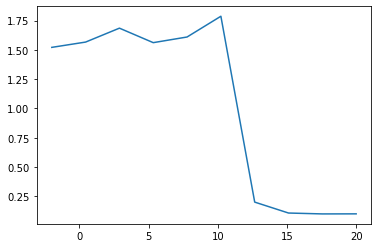

In [22]:
# Large rho tau: varying w2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(6,10,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.min([np.abs([GenerateTrajectory(sig2_e = sig2_e,w2=w2[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)]),[2]*rep],axis=0)) for k in range(N)]
plt.plot(np.linspace(6,10,N),transition_m)

Something excitingly weird is going on
thnow=32.07866280069256, thprev=[30.96033733 32.86627407 32.14022192 32.48466039 31.5049005  28.74335784
 29.22988973 32.73205275 33.14690266 32.09287188 33.22073898 31.77343398
 29.76824268 30.41691632 31.80697076 33.18490444 31.11982092 31.43921572
 32.67662975 32.65232659 32.04351894 31.25145207 33.40936846 32.05105251
 31.90535029 31.20364142 32.88730234 33.24751204 31.81574964 33.55624318
 31.44256437 31.68470498 33.35035262 31.59844362 30.41443079 31.59454752
 32.33384433 31.6837487  32.28062143 30.38990502 32.08900068 31.87830766
 32.13220871 30.94824867 30.86727592 31.73555609 33.34869756 32.74949372
 32.76105336 32.81285197 32.22697216 32.83350894 32.4312855  32.87085723
 34.20752896 33.52231742 31.96185353 32.77784456 30.55454039 32.54356745
 31.33557954 31.36614069 30.79513678 32.95563014 32.17323276 33.67884408
 33.64102651 32.30871711 32.10300488 33.1479997  32.47263403 30.74592079
 31.0384991  32.60370079 32.95643707 33.60821121 32.0

C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Something excitingly weird is going on
thnow=-165.11739877243687, thprev=[-164.59936606 -164.52609695 -165.15023029 -164.50624886 -166.31810709
 -165.5923652  -165.30639052 -165.69515512 -165.22219427 -164.58079634
 -163.1590442  -163.87285989 -164.05334342 -165.38094973 -164.3108903
 -165.51183785 -165.15369799 -163.21962066 -164.96263396 -165.70459637
 -165.46644303 -163.63649824 -165.70311808 -164.90259824 -165.83251453
 -166.81389975 -165.57615796 -165.22466191 -165.72423383 -164.11160643
 -164.56038351 -165.41781809 -166.2104513  -166.55707562 -165.72774185
 -164.57097362 -165.07125898 -165.12337614 -163.85124707 -165.7768221
 -165.33163104 -163.27607741 -165.11644786 -164.24371679 -165.41464041
 -165.80477657 -165.64237349 -165.73964596 -165.33761257 -165.58459943
 -165.1949376  -164.2091161  -164.1682904  -165.45296398 -163.68630848
 -164.27417184 -165.09745959 -166.66417903 -165.70945234 -165.58555376
 -166.2863357  -165.23470003 -165.04800937 -166.37923864 -164.88665341
 -164.

Something excitingly weird is going on
thnow=15.002990903637274, thprev=[15.53614139 15.11979271 15.02819784 14.10030725 14.23620652 14.8793345
 16.02198822 17.6711601  15.76775251 15.39367219 15.48372753 15.75450241
 15.72162899 14.97963937 14.53439745 14.24955186 17.12912921 17.14103592
 16.2201177  13.80988499 15.16160653 14.36334734 15.6852504  14.43445805
 14.44381919 16.08499478 15.02186545 14.97671549 15.44672845 15.66210287
 14.18052332 14.53104445 14.02444995 14.97540858 15.91782206 14.49337155
 14.64942846 14.6448471  15.38277087 15.3543817  16.46124583 16.86559462
 15.20801661 14.13307822 14.46580434 14.65787158 15.14943791 15.361277
 14.96970686 14.98578521 13.65210242 14.90115015 15.51620225 16.27334598
 13.9924495  13.87766272 14.25723966 14.24357308 15.2275371  13.7546653
 13.99474787 13.11925861 14.48711129 15.6808229  15.65357985 15.21830271
 15.0504038  16.30637422 12.92155649 14.50470997 14.9785002  14.45263001
 14.28333603 14.08483828 13.85462712 15.44552627 14.3862

Something excitingly weird is going on
thnow=-85.80290383913255, thprev=[-87.60231216 -85.22551174 -85.92965106 -85.81774029 -86.41107225
 -85.258949   -85.4507731  -85.77071301 -85.29832161 -87.54883711
 -87.43609383 -85.86782111 -84.23283546 -84.40965408 -85.59890469
 -85.77978252 -86.53468609 -85.72232017 -84.25576963 -84.7418714
 -85.97092784 -87.4081883  -86.21236058 -83.30391986 -83.97477311
 -84.89489312 -85.93258354 -85.08159136 -85.91703535 -86.16286573
 -84.7977537  -84.5302729  -86.59679683 -86.25207969 -87.27739705
 -85.42062428 -85.89489085 -88.17393009 -85.7793809  -86.87939264
 -85.79493117 -85.1938926  -85.6493454  -86.88464362 -86.18246989
 -86.78796691 -85.99113258 -85.66805765 -84.85293116 -86.89807285
 -85.82567529 -86.62949011 -86.35479682 -87.00532183 -87.45839913
 -85.98135123 -85.8591484  -86.42584402 -83.8212685  -84.25931272
 -85.37902064 -85.01301633 -83.84164268 -85.12036343 -85.78029475
 -86.79170964 -85.48562909 -85.42288637 -85.98891346 -85.42403342
 -85.

Something excitingly weird is going on
thnow=-49.37912303211715, thprev=[-49.17523189 -49.24095311 -49.10544979 -50.76534028 -49.62655405
 -48.53685957 -48.06718863 -48.91915991 -49.7159852  -48.61742728
 -48.18980548 -47.54443801 -48.79777327 -49.48098252 -49.43321189
 -49.77229123 -48.47452651 -48.81645859 -48.90574565 -50.69318633
 -49.4082612  -51.57505909 -49.88898955 -49.54047343 -49.16508743
 -49.40622637 -51.10983193 -48.68215633 -48.7039606  -50.75427244
 -49.83997896 -48.89610377 -49.84993945 -50.49979911 -48.71531948
 -47.82608588 -50.01328104 -49.26270759 -49.50913934 -48.75880865
 -51.05854978 -50.69643247 -50.41095526 -48.53855713 -47.79894005
 -48.13259172 -49.10182699 -50.05937815 -49.63969119 -48.72543362
 -48.32737818 -49.53243522 -51.02558679 -50.18531445 -47.70896298
 -49.6180127  -51.28515478 -49.77022947 -48.42727913 -47.44049053
 -47.54043076 -49.89437327 -49.70606525 -49.58437021 -47.94538676
 -50.18288946 -50.19785475 -48.60325462 -47.73667252 -51.05476557
 -50

Something excitingly weird is going on
thnow=-65.98077137617433, thprev=[-66.58952279 -68.12437918 -67.39478872 -67.13869032 -66.69098669
 -65.30654622 -66.54371072 -66.97359054 -65.65411124 -67.1642233
 -67.27801442 -68.84366433 -68.07482389 -64.86426655 -65.66791029
 -64.94705286 -65.07547974 -65.11044849 -65.11972911 -66.63701478
 -66.94434595 -66.02157499 -65.84770136 -66.05332545 -67.16575687
 -66.16950462 -66.0817172  -64.91886989 -64.85277182 -65.65266879
 -65.4606767  -68.10501169 -66.38158218 -66.79911396 -66.90225707
 -66.91574775 -66.92173258 -66.19977656 -64.55921093 -65.99981339
 -66.30448688 -64.30856472 -64.31573228 -64.62486811 -65.4917173
 -65.81995418 -66.52614266 -65.45153115 -64.63268428 -66.05898211
 -66.31274905 -64.52015486 -65.83477713 -64.62166613 -64.85787781
 -65.23191743 -66.47660049 -66.3950182  -66.02331122 -64.95487596
 -65.44239928 -66.35389206 -64.63766087 -66.23299101 -64.93899828
 -64.87989605 -66.05030578 -67.79378178 -65.73317833 -64.52976121
 -66.2

Something excitingly weird is going on
thnow=-17.412333356010684, thprev=[-16.39730143 -17.20170466 -17.9203451  -17.42757272 -16.26199965
 -16.7227963  -18.50517813 -16.89905936 -16.59366509 -16.33211807
 -18.76388081 -17.82971598 -18.86945868 -17.11799078 -16.59781379
 -16.276534   -16.52301012 -17.49559838 -16.85246172 -17.9467002
 -18.44858238 -17.78520701 -18.20722182 -17.95714072 -17.91187763
 -18.15854096 -17.78311441 -17.49012184 -18.36160104 -16.15539745
 -15.82761606 -16.0915968  -15.45272951 -17.30228548 -16.66897744
 -17.23316397 -17.35609841 -19.38689091 -18.11086298 -18.48425846
 -18.21468292 -18.11513436 -16.72943926 -17.07665924 -17.51183412
 -17.21908498 -17.70226878 -18.52331208 -17.05966113 -17.41060343
 -16.42936539 -17.3542008  -18.57687498 -17.57919382 -17.14625162
 -18.68081328 -17.98159853 -16.59231955 -16.74963304 -18.03765529
 -17.60135391 -17.43984383 -17.55587832 -17.2305588  -18.24810856
 -17.65090497 -17.24050883 -17.01494697 -15.37007809 -17.69466994
 -17

Something excitingly weird is going on
thnow=-5.760047881316955, thprev=[-5.51337276 -5.98428453 -5.40120307 -4.2919911  -6.65003933 -6.04608605
 -5.37013046 -6.53574469 -6.97308382 -6.4751496  -4.65228226 -5.28427711
 -7.04850691 -6.94328135 -5.86059683 -4.39604835 -5.66606038 -6.58863982
 -5.94086306 -5.42110432 -7.9939307  -6.4893521  -6.21923792 -6.20330218
 -4.38963793 -5.41728696 -3.68661305 -4.935201   -5.20508735 -4.43955521
 -5.79450795 -5.21869247 -4.64056342 -5.4017832  -6.65568156 -7.10477336
 -6.1126021  -5.42045708 -5.42620715 -4.52860901 -5.63140415 -5.68398271
 -8.11074478 -6.21912782 -5.13888916 -4.74330314 -6.26378928 -4.88743906
 -6.45493677 -5.14647715 -7.49685768 -8.47738638 -7.33772466 -6.26560117
 -5.29346414 -6.25899477 -5.06159531 -5.18580901 -6.46675788 -5.74257394
 -6.07405294 -5.49137888 -4.42886896 -4.13034942 -4.09506438 -4.08910513
 -6.68766464 -6.32348486 -5.18086986 -4.45099758 -4.09964952 -4.6871135
 -3.99779383 -5.27541012 -7.25317819 -6.95995667 -4.8

Something excitingly weird is going on
thnow=-84.3025418177493, thprev=[-84.13828981 -85.59380163 -85.27907413 -85.23148945 -84.70901846
 -83.2636204  -83.50630121 -83.19044843 -83.96449937 -84.92995947
 -85.35873908 -83.74718506 -84.29906379 -85.24631024 -84.4552875
 -83.53966197 -83.47267157 -83.84830159 -83.75310884 -85.39247793
 -85.90127705 -84.87261507 -84.16438291 -84.6732582  -85.2980913
 -86.1337495  -84.29698899 -85.40296941 -86.20187019 -86.51479632
 -85.82293654 -85.97520727 -85.2888928  -84.21828818 -84.82681762
 -84.52953771 -85.66901392 -85.2869698  -84.90685851 -84.32528944
 -84.59155874 -84.40461506 -84.67381528 -84.54660589 -84.77232785
 -84.04792307 -84.93305789 -84.05185343 -82.353806   -84.47503161
 -83.17179213 -81.7265704  -83.40339755 -83.33172262 -83.61146718
 -82.71280568 -83.79791812 -83.41288908 -83.05971089 -83.44185074
 -84.09422345 -85.64723026 -85.92110569 -85.35263832 -85.08582874
 -84.19212436 -84.13724204 -82.55451292 -82.82035502 -82.45751707
 -82.52

Something excitingly weird is going on
thnow=51.473411286659356, thprev=[52.07682024 51.08038634 52.10221252 50.56369842 50.45904528 50.64322539
 51.47482047 51.36433818 53.15326763 52.46923468 52.39598996 51.33118597
 50.91767925 51.96094965 52.12638451 51.06993285 52.11790333 52.17243734
 51.01185157 51.88802848 52.77929962 53.21792046 51.18722355 51.73865921
 52.30170302 51.53856511 52.01851179 51.81006511 50.12889022 51.30815702
 53.54554436 51.7609958  52.58022363 52.58003468 52.70220578 53.09633007
 52.24583458 51.24729704 51.13145478 50.32774732 49.99079623 50.93807905
 50.06058064 50.28927541 49.72669984 51.39940844 50.74748234 51.30295443
 50.78480892 51.05894244 48.82282291 51.50404709 50.09757151 50.20153903
 50.22967861 52.84061276 52.96373904 51.4642121  51.22160922 50.88023386
 50.40366148 50.00488595 51.371483   50.93867105 50.5297157  51.39034462
 50.81605579 53.27723982 53.19723975 51.26421347 51.75669856 52.52360809
 52.85056956 53.52454145 50.74100395 50.95663583 52.

Something excitingly weird is going on
thnow=-70.53570571172146, thprev=[-69.44655496 -69.9670596  -70.62282684 -70.68331358 -69.42183646
 -70.86570517 -69.12542149 -68.77325314 -69.42394086 -69.64213976
 -70.10500845 -68.84157239 -69.64046619 -71.55857654 -70.85524512
 -69.7771661  -69.83938868 -69.93135776 -69.27544678 -68.89073268
 -70.30300641 -70.69116582 -70.7894843  -71.47326244 -71.96837585
 -72.6436284  -72.43255386 -71.40769515 -70.4108393  -71.46640016
 -72.38396547 -69.40652734 -71.1670609  -69.6954     -70.43561493
 -68.8357589  -68.88914116 -70.46939612 -69.77527591 -70.84773044
 -73.04412111 -71.9925652  -71.07187282 -69.9557266  -69.51165849
 -70.04885756 -72.14218626 -73.13130963 -70.52674112 -70.19742569
 -70.86211805 -69.79587452 -69.78768843 -70.36138994 -70.22775187
 -69.54821773 -69.57594934 -70.96498371 -69.89381947 -70.49941387
 -71.78470696 -71.15319064 -72.31525512 -71.61870381 -73.11509128
 -71.71737664 -70.47740885 -69.03825364 -69.19398512 -69.03315141
 -70

Something excitingly weird is going on
thnow=39.809298157603884, thprev=[38.61881912 41.31993598 40.29877615 41.10665678 41.31968434 39.03528048
 38.98055106 39.72969759 39.31688726 41.3546543  38.98283325 38.81713635
 38.0163907  39.40571476 40.5979852  40.09041795 38.68751103 40.83969434
 40.58779289 40.38913499 40.39614949 38.1929024  39.50026596 40.86043806
 38.89383339 38.45481409 41.61406335 40.65245942 41.78913657 39.99341115
 39.97837309 40.26566138 40.05495593 39.08495108 39.56093236 39.28045545
 38.14531316 39.04681212 39.67796834 40.03224676 39.37719975 39.49691306
 40.08623204 40.85211474 40.62942119 39.38431498 40.03461249 39.7184242
 38.92919162 39.1216221  38.64970768 39.10375251 39.85806556 38.16338914
 39.6803607  40.45937777 39.52412631 40.02133993 40.59122447 40.83859575
 38.27102423 38.8730853  39.00308391 43.07101417 40.35346846 39.66567086
 38.62878455 38.6463823  39.42345515 39.22115733 40.14623385 38.87627282
 40.06247504 39.61076238 39.74613299 40.02657195 39.1

Something excitingly weird is going on
thnow=-35.41703144769961, thprev=[-35.28321105 -35.33376129 -34.2957278  -35.55474918 -34.68555906
 -35.67398847 -35.47975742 -35.72342399 -35.15397646 -36.08967588
 -35.05178782 -34.71637066 -36.00977226 -36.04051396 -35.3761476
 -36.1292143  -35.60082991 -36.66762078 -36.15562224 -36.76647973
 -36.36805854 -34.74277389 -34.85652015 -36.05171852 -35.50295685
 -35.89166209 -34.95752406 -34.65136956 -33.97765725 -34.81942939
 -33.65963098 -35.02008512 -34.22319379 -35.39674285 -34.68655662
 -35.69533356 -35.27443229 -34.09121116 -34.5235603  -36.94750288
 -35.45200866 -34.51846364 -35.36266781 -36.22916635 -35.3448664
 -36.50705631 -35.09586785 -35.39975753 -35.12739476 -34.91452985
 -36.64786642 -36.36348593 -35.39851351 -35.84111339 -36.85903974
 -35.99653458 -37.00449359 -36.83615916 -34.05954953 -36.37275432
 -34.59485768 -36.94235671 -35.99314051 -35.37502026 -34.74302894
 -35.67445719 -37.63116175 -35.50945168 -35.72309693 -35.09860772
 -34.4

Something excitingly weird is going on
thnow=-6.061654504456048, thprev=[-7.13219967 -6.07439997 -5.5393181  -7.66592324 -6.31236786 -5.93825439
 -6.8172102  -4.7998758  -6.20406804 -6.21854093 -5.72177533 -6.69532672
 -6.64797614 -5.29072712 -5.84139925 -5.58101698 -6.78692301 -4.56695711
 -6.74686981 -5.71450696 -5.91081273 -6.29078544 -6.21227614 -5.21262998
 -4.2655494  -5.83500196 -6.20709532 -6.28467047 -6.65142335 -6.6035591
 -4.37729015 -3.78154824 -3.83092279 -4.47824689 -6.99359692 -7.06393815
 -5.31033932 -6.07836347 -5.11574666 -6.55898363 -5.86632331 -6.94041237
 -6.28260414 -6.9473283  -6.33196077 -4.46797613 -5.66716906 -6.71913185
 -5.50815976 -6.49743455 -6.60856748 -8.65091409 -7.74644767 -6.6487527
 -5.84254085 -6.05622587 -6.87286601 -4.84939275 -6.8097025  -6.30198779
 -4.49854998 -6.45153856 -5.61103058 -6.08269659 -5.89723279 -6.94055949
 -7.71270201 -6.0029695  -6.06965898 -5.70532955 -5.60100705 -5.99571864
 -4.70004506 -6.00035026 -6.2752912  -7.06867776 -6.16

Something excitingly weird is going on
thnow=-12.831465858784561, thprev=[-11.92575197 -12.93121485 -11.52909764 -12.63872067 -13.15335215
 -13.40055515 -12.04049517 -12.68279635 -14.97117975 -14.90933228
 -13.9868538  -13.43185768 -14.45573914 -13.32060546 -13.48708411
 -14.58467844 -12.93132645 -13.92411896 -13.79765662 -13.50022972
 -12.32323214 -13.1458266  -13.75761518 -14.17123107 -14.32199609
 -11.84009671 -11.16953394 -11.98739743 -12.99735957 -11.9078255
 -11.05845506 -11.03083524 -10.13685307 -10.38450608 -12.21971077
 -12.30354452 -13.46223194 -13.44916264 -12.79677003 -12.30417549
 -11.31276524 -11.30712047 -12.18166817 -10.66687872 -11.78631524
 -13.3814664  -13.27637093 -14.18138458 -14.23707187 -13.55623236
 -13.87400217 -12.9118109  -14.49670277 -14.30113723 -13.43501969
 -12.87629895 -13.29582225 -14.79225806 -12.91645614 -13.09151955
 -12.18253355 -12.86314058 -14.05207228 -13.0431194  -13.7223422
 -12.69953813 -12.4157583  -10.9379256  -11.33893336 -10.88687333
 -12.

Something excitingly weird is going on
thnow=34.13394629371665, thprev=[33.02385512 33.98798225 34.65589373 34.36289861 34.16362948 34.00096336
 34.99270552 31.59818352 32.71028655 35.31953286 34.04574435 34.64758837
 34.2087543  34.85928497 34.09328002 34.83002854 33.63988672 33.72854427
 34.24508643 34.74696897 35.2890946  35.32754857 35.47679144 33.49561997
 33.03857301 33.71859916 34.62860412 35.77282496 33.95325893 35.09464695
 34.41912691 33.57059215 32.98128245 35.18178843 34.61091435 34.68542807
 33.25138529 34.98612153 34.90233173 35.95648545 34.46924709 35.35156154
 33.83553323 34.36971502 34.2066347  34.18305889 34.90804204 34.16881175
 32.98067227 34.94201273 33.46231497 34.53754431 33.26461468 32.97963139
 32.8592765  33.86826327 33.06665873 35.11700754 35.13074776 34.75094582
 33.30298213 35.01553902 32.10179218 33.03473783 31.52669034 32.3394262
 34.39459403 34.86766472 34.76291776 33.85253802 33.7034599  33.7920206
 33.57576545 35.78270188 35.28822353 35.48270537 34.546

Something excitingly weird is going on
thnow=52.084028103449945, thprev=[52.81274842 53.41828434 53.18068637 51.96365114 51.93494118 52.70761417
 51.74442252 52.49843848 53.42832588 50.82601379 51.40766669 52.02436372
 53.23094634 51.48537946 52.89767954 52.11465747 52.08537427 52.47057949
 53.40244553 51.5798682  50.86602797 51.13859234 52.02166877 53.11899296
 52.64955735 51.40513282 50.9414489  51.97088179 51.64424576 51.47536988
 51.5469839  51.0988405  53.33991688 51.76177854 52.5833406  52.6007961
 52.81549439 53.37549098 53.08837383 51.81371787 52.22236449 52.31799215
 53.46160662 51.28340991 52.51513041 51.36584773 50.80417052 50.83205736
 52.79285475 52.79602427 51.27791262 52.59106869 53.39744517 52.78084772
 51.97098187 51.05121262 51.75105257 52.15236066 52.61725386 54.54707628
 52.74821807 51.9312363  51.19155254 52.90238559 49.36111393 51.38882482
 50.82954165 51.85625852 50.2849601  50.61817696 52.07669538 52.20884593
 50.11543837 52.60346994 52.32761582 53.56141175 52.8

Something excitingly weird is going on
thnow=-48.51000645413214, thprev=[-49.20666381 -49.03195971 -49.04586272 -49.31362394 -48.53490892
 -47.11927895 -46.71328475 -49.67239464 -48.3743678  -47.85164506
 -48.49502665 -49.69216223 -49.0898655  -49.48811322 -48.10301332
 -47.47184599 -48.29485581 -50.07227392 -47.72550468 -49.24465585
 -47.64308554 -48.55137295 -47.2940036  -46.36788972 -46.50000489
 -46.86238233 -47.29272163 -48.88539998 -47.72889005 -48.5638366
 -48.0331975  -48.44132785 -47.46440367 -48.26747441 -48.10002026
 -48.96646106 -48.61565771 -49.17264617 -48.5334713  -48.57502262
 -48.00823163 -47.19836234 -48.20547639 -48.7432676  -50.38374327
 -50.39310545 -49.95602595 -48.10291711 -49.89481945 -49.19732814
 -47.96164198 -48.18027763 -49.39058752 -50.72281401 -47.15009986
 -48.44665436 -48.67532303 -49.31612596 -48.44936875 -47.09402614
 -47.2101459  -48.38160109 -48.67347425 -48.40349811 -47.90329244
 -48.80709414 -48.50816218 -49.07980643 -48.74581608 -48.26655555
 -48.

Something excitingly weird is going on
thnow=-103.56562791986237, thprev=[-102.94290164 -103.85808797 -102.73735244 -102.35968152 -103.45948319
 -103.40144361 -102.97494396 -104.22367262 -103.66413212 -102.60689361
 -101.39096692 -102.26910691 -103.41114461 -105.61741372 -105.59035298
 -102.9307906  -102.08721462 -102.94642745 -104.91624684 -104.78428802
 -103.71051266 -103.07438809 -102.905053   -103.85555673 -103.0074651
 -103.68941279 -104.09223631 -103.6773564  -102.65026166 -102.89707016
 -103.47046048 -103.93079198 -103.42491514 -104.96646475 -103.81497463
 -101.5141049  -101.50569323 -103.34480262 -104.61809218 -103.87835781
 -104.05253176 -106.00715028 -103.69996809 -104.35235815 -104.28818341
 -104.14424445 -103.64518261 -102.22230803 -102.69147398 -103.83847899
 -103.72621406 -102.27250867 -102.64689267 -103.74652561 -103.62736981
 -103.41055295 -101.59652536 -102.39941017 -102.98201036 -103.84188067
 -103.88039988 -104.87686171 -105.18382014 -105.6858101  -103.05212589
 -103

Something excitingly weird is going on
thnow=1.3922661509500487, thprev=[ 1.69592369  1.15976343  1.6870781   1.39413999  1.16430534  1.07421234
  0.15572145  1.46533623  0.69083008 -0.17024288  0.01447291 -0.72744686
  1.34827161  2.14804628  1.20181142  2.71250595  1.35666094  0.63565596
  1.84681752  1.92488117  3.14691217  0.96206173  1.47453773  1.18554485
  1.62633113  1.38167353  2.37328183  1.07681592  2.29635786  0.98705312
  0.27030662  2.12191371  1.88185263  1.38173024  1.47943635  1.00757087
  3.41224487  1.9333565   2.89294555  2.88448986  1.99596871  0.60737408
  0.86821848  0.47187601  0.73772442 -0.57535481  1.82783203  1.330437
  2.28181265  1.91804616  1.34302965  2.12647332  0.30828979  2.22269939
  2.53161549  0.2045092   0.64218536  1.270296    0.73574036  1.50454327
  1.6118568   0.39698685  0.88980596  1.83039764  2.05288745  0.85366574
  0.98870907  0.50153319  2.9604736   1.51644737  0.89918303  1.36587543
  0.55193946  0.75322775  1.31449149 -0.32671875  1.18

Something excitingly weird is going on
thnow=-30.32389773090802, thprev=[-29.65485023 -29.12738061 -30.33114553 -30.07651472 -30.0606602
 -30.39063074 -30.28183633 -30.65762937 -30.80917079 -30.76192557
 -30.48235206 -31.94010363 -30.78731263 -31.43377663 -31.0636654
 -30.41652859 -30.00643214 -30.70563673 -31.28593261 -29.62252149
 -28.20088567 -28.95400383 -29.42118105 -30.00775728 -29.05296929
 -28.71190906 -29.26082135 -30.97759579 -30.66635249 -30.76124077
 -30.97884876 -33.07176109 -29.73790439 -28.98155925 -29.39499696
 -30.16807021 -27.66623665 -27.70182023 -29.51022574 -29.34237297
 -30.00772662 -30.01209543 -29.53895743 -29.60032392 -27.56109438
 -27.63331377 -29.42300022 -30.94643124 -30.34747421 -29.7740756
 -32.1071035  -30.51641674 -31.27707002 -31.61567371 -29.61410272
 -28.83283279 -30.10798967 -29.54846836 -31.51436231 -30.90585115
 -31.51908426 -31.06566668 -33.65457383 -32.18024145 -31.29712113
 -31.31628491 -31.25301872 -33.01750724 -29.74835724 -29.49045541
 -31.66

Something excitingly weird is going on
thnow=-128.71336707198904, thprev=[-128.76835576 -129.35089737 -128.90540624 -128.41232343 -126.83918066
 -127.07314293 -129.21525214 -128.84452696 -128.26080033 -127.49028573
 -128.69188232 -127.81344071 -129.5991262  -130.79374271 -128.84954404
 -129.24079957 -127.1339893  -128.4060676  -129.09093179 -127.79018881
 -127.79310626 -128.6497381  -129.40815587 -128.06818828 -129.14932309
 -129.40491343 -129.26396016 -128.2290472  -128.64317033 -128.80440386
 -128.00531913 -128.25776327 -129.88326824 -128.14116247 -129.59270157
 -129.4869529  -130.55048339 -128.08370291 -129.51339261 -128.43638367
 -127.85245483 -126.92713818 -128.21084911 -128.97678256 -129.51364553
 -128.90178151 -127.89694365 -127.7447644  -128.1857829  -127.12103159
 -127.77918081 -128.699129   -128.34609501 -127.18507878 -128.66590767
 -129.57692098 -129.49579876 -128.8131893  -128.21643596 -130.12225136
 -129.05882548 -128.62909218 -128.4397307  -129.36468568 -130.70719037
 -12

Something excitingly weird is going on
thnow=-6.943369617365887, thprev=[-8.15127921 -7.53235585 -7.8025014  -7.24103168 -8.05698005 -7.85989824
 -8.41493851 -8.69178688 -6.38556444 -6.23619837 -5.72056159 -7.35040786
 -8.39357789 -8.80623036 -5.97936697 -7.15418545 -6.68549608 -6.18725848
 -7.09647563 -6.44606946 -5.08608029 -6.32632592 -4.86799433 -7.97105653
 -7.30698904 -8.06151181 -8.74607568 -6.65967173 -7.51657024 -6.31243612
 -7.25583771 -6.89540755 -7.26006498 -7.534255   -7.53180484 -7.45808101
 -7.05270496 -6.90429739 -5.89976713 -5.84271904 -6.35488445 -6.7414615
 -8.45923633 -7.55288937 -7.07048681 -7.65957932 -6.84146122 -8.31420199
 -8.29892661 -6.89757623 -7.92615443 -7.46624822 -6.87809374 -7.32038251
 -6.8888836  -5.70908918 -6.33258514 -9.14522357 -8.16377453 -6.93864262
 -6.2367519  -7.04585811 -8.79185351 -5.82788916 -5.70448159 -6.51418615
 -5.58443232 -6.15244544 -4.54760056 -5.72374156 -8.32926457 -5.39050237
 -7.39268354 -7.04036033 -6.98367278 -5.40399187 -6.2

Something excitingly weird is going on
thnow=116.06921945286449, thprev=[116.48598634 114.96956001 117.03190283 118.06541367 117.63707418
 116.24585774 116.58950697 116.43391404 113.97468402 114.56792633
 116.05893159 115.97209913 113.71412629 115.79804645 115.47090949
 116.72777699 115.44351096 115.93880619 116.12618743 117.01093879
 117.27004195 117.47739254 116.58095883 116.45065169 114.8993883
 115.2391245  115.05433633 116.50098305 115.72237027 116.41942724
 116.80331272 117.4207164  115.37772623 116.30672948 116.50580194
 116.43970866 114.79885646 116.44842115 116.93589623 115.21768595
 115.9083506  117.10993616 116.71931827 116.59322559 117.73346867
 116.17514342 117.26025311 117.40913237 115.95303971 116.54241957
 114.85511707 115.81975968 115.47595673 115.27963649 115.50409158
 115.10671907 116.05609854 115.19207326 114.70400407 114.8284211
 114.62115055 116.20734932 116.92952882 117.27712593 116.79003754
 114.79556059 115.13608632 114.59624569 114.84839796 113.99978963
 116.6

Something excitingly weird is going on
thnow=-31.891667797852325, thprev=[-32.33400587 -32.9861635  -30.92701284 -30.02481846 -31.34301186
 -31.04529516 -32.04399724 -29.54690782 -31.88266813 -32.42139589
 -31.2865648  -31.36923288 -32.85566343 -31.77831193 -32.50610968
 -31.88540363 -33.0770381  -30.84425392 -32.23867417 -30.82483197
 -31.56046308 -31.78705863 -32.50566869 -32.99846132 -33.42910227
 -33.70513539 -31.05766311 -32.13645172 -32.07431977 -32.31616665
 -34.06030631 -34.07739502 -31.66419028 -32.13310125 -32.18447119
 -31.9516258  -31.12566545 -32.20468178 -32.62632763 -30.18745254
 -31.8787985  -32.38519607 -30.435459   -30.88129451 -31.58449229
 -32.12200363 -31.13198299 -30.90163028 -33.44985016 -32.89405084
 -32.78757596 -33.51613606 -32.64669878 -32.21447625 -31.70360356
 -32.42216942 -32.56882024 -33.23107918 -32.68769548 -33.28201735
 -31.3822252  -30.65927693 -31.08952128 -30.06581774 -31.64229036
 -32.31260011 -31.75892718 -31.45082812 -32.27491859 -31.97158061
 -3

Something excitingly weird is going on
thnow=-91.58814030032978, thprev=[-92.44884899 -91.36523868 -91.71026595 -92.00020409 -90.11468826
 -89.78051313 -91.58012139 -90.58211671 -91.38288695 -90.44282956
 -91.63291655 -90.84964567 -92.7830716  -91.69024043 -90.19192706
 -90.23278361 -90.91605968 -91.89564511 -92.22170171 -91.48573432
 -92.3191995  -92.47690079 -92.57491566 -91.38550775 -91.58267748
 -92.94377005 -91.91757775 -92.8915854  -91.40607784 -91.10920242
 -91.4258601  -92.55527105 -91.98747752 -92.8602465  -92.17466418
 -93.82623329 -93.47985549 -93.94150239 -92.35761236 -91.94449634
 -91.90082618 -93.36529783 -91.13567001 -90.39218696 -91.68824741
 -90.93002299 -92.31602929 -92.00002464 -91.28974728 -92.94684083
 -92.64157337 -91.8966208  -90.63596418 -92.26481056 -90.92294683
 -91.73470208 -92.05342624 -91.94473848 -91.26154567 -91.16347524
 -91.82371194 -92.39059641 -91.78392467 -91.76177651 -91.29031332
 -92.43606168 -91.25067881 -92.49300014 -91.68058646 -90.69839148
 -90

Something excitingly weird is going on
thnow=-31.188561996854858, thprev=[-31.25336919 -30.22581804 -30.61650797 -32.0403587  -32.20070002
 -31.75698819 -31.17396449 -32.78526511 -32.57830829 -32.41601848
 -31.82577168 -31.73707953 -32.16208842 -32.11265269 -31.51849656
 -30.70241717 -28.95811791 -29.49484052 -29.73955728 -30.25378472
 -29.70448657 -30.2189474  -31.31194893 -31.29919888 -29.4957082
 -31.08891834 -31.24520482 -30.84421061 -30.66143176 -31.7170209
 -31.67766857 -31.78773038 -31.00470617 -30.61215166 -30.71947581
 -31.41621512 -30.85582427 -31.78406905 -30.31970156 -30.88177807
 -30.256419   -30.48397089 -28.6408707  -28.9975779  -29.93754143
 -30.28626487 -30.36509572 -31.23576285 -31.35066528 -31.26717907
 -30.86807379 -32.66678035 -32.32055093 -31.61746524 -33.05555318
 -32.02525103 -30.91189745 -30.85948191 -31.23827742 -31.3325072
 -31.40255319 -30.8953555  -31.49572648 -30.80391333 -30.20564705
 -30.49973064 -30.76775859 -33.92442779 -32.84216246 -32.34357386
 -32.6

Something excitingly weird is going on
thnow=-36.752305522609404, thprev=[-36.37684577 -36.14829051 -35.96456951 -36.92539203 -36.1606159
 -37.55540175 -37.04448611 -38.11982276 -36.73604596 -36.67496476
 -35.48415158 -36.8944842  -36.91739094 -36.4123264  -36.92808321
 -37.52908898 -37.12167719 -36.75253391 -37.19229631 -35.4413484
 -37.83603325 -37.27821044 -37.41924284 -36.7666946  -37.38121517
 -38.09297181 -36.43896769 -35.60072064 -36.59091594 -38.15112372
 -36.98673157 -38.2000402  -35.88111639 -36.53291799 -36.5947836
 -37.70681814 -36.91617287 -36.7649617  -37.48554658 -37.59306176
 -38.10034412 -36.78748126 -36.46723008 -37.65844338 -37.54269153
 -38.17154966 -35.86747171 -37.18969189 -37.34329578 -37.11878304
 -37.26798336 -35.40158832 -36.61951519 -36.65537373 -35.98941177
 -36.95033617 -37.35911977 -35.23862684 -35.67340119 -36.88812907
 -37.26469333 -36.21806819 -35.7290938  -36.32615751 -36.0173784
 -36.15692859 -36.87808631 -36.72238638 -34.96478471 -34.94515358
 -36.19

Something excitingly weird is going on
thnow=35.299376314784254, thprev=[34.87086725 35.00626802 35.57755909 36.76458748 37.19635005 36.5334287
 35.94292737 36.33680062 34.90059145 33.99391328 35.67965148 34.6552719
 33.37430327 34.16793292 34.0126032  34.51081222 33.76761362 35.98742876
 35.24072833 35.00424048 35.90146433 34.66858312 34.20632751 34.39845141
 35.64854299 35.81800664 35.59237572 34.42224224 35.70018066 35.23079327
 35.44268702 33.86451097 35.74473223 35.75990079 36.13435704 35.38484053
 37.08369053 36.34337909 35.20934607 35.34826302 35.38659115 36.54252368
 35.70025431 37.76073911 37.64745416 36.59094305 35.93900922 35.56860495
 35.91419787 34.74652977 35.56714069 35.45278013 33.21089234 33.69756498
 33.61255853 33.16893279 33.6416365  35.3082763  35.3935665  36.26878588
 35.71466578 36.8563755  36.3010821  36.1242615  35.41822299 34.9741297
 35.78103128 36.41526522 35.38962968 35.77104671 34.28205007 35.68676296
 36.7410509  36.07557287 34.23677516 34.72741154 34.351

Something excitingly weird is going on
thnow=29.618325167769235, thprev=[27.32857959 28.69643582 28.64515009 30.96026174 30.37386011 29.44914718
 30.5426674  30.63957886 30.0729884  30.71536579 31.54667027 29.31692212
 29.07838391 29.992799   29.01057465 29.0523061  31.07431479 30.8817988
 30.82932086 30.95202315 29.6983729  29.26699467 29.23615162 31.28381845
 30.94702544 28.73083865 27.98769938 28.52922325 28.33328213 27.74321362
 30.73792989 29.85118083 28.74280085 27.89990677 27.12010882 29.84394391
 29.00736003 30.45867978 28.51080091 29.41952676 28.94173346 29.02741268
 29.69067273 31.04402021 29.86774333 29.31565699 28.79530731 28.36255669
 31.10683957 29.2166507  28.9918713  29.80859029 29.92503429 29.4570813
 27.72407051 28.47116169 28.39283172 29.29374998 28.37405508 28.68707421
 29.48502959 29.10351906 31.05819948 29.75707091 29.1217154  29.19358709
 29.97954501 30.90122318 29.45064312 28.34278279 29.87611494 28.84724889
 28.74736804 29.20955273 28.13326499 30.26392486 30.31

Something excitingly weird is going on
thnow=31.686933390276728, thprev=[31.76254468 31.71303223 32.61215703 32.75867466 31.02167375 31.22384344
 31.6078828  32.81501537 32.41581625 31.0990974  30.74073127 30.95870901
 31.39702659 30.27664849 32.416468   31.67030719 31.49220414 30.69766452
 29.45641038 30.39141194 30.60273547 31.60086725 32.57988953 30.81627293
 31.38590683 30.98687895 31.66433215 30.69836682 31.33252845 30.96359308
 31.24530042 31.13808476 29.50411829 30.58450545 32.80534094 32.45109002
 32.00540444 32.18887809 31.59899489 31.26254927 30.0396304  31.04883672
 32.74509997 33.85709453 31.9628802  32.0325936  31.71021703 32.83151563
 31.91032778 33.12368125 32.48322442 31.30813906 30.38900281 31.47136726
 32.38125498 32.93749713 32.39386519 31.20934861 31.52128082 31.11078626
 32.10332711 30.42521555 30.00480005 31.40237949 30.32094878 30.95712897
 30.63635686 31.68489485 30.90929619 32.91478331 33.25286808 30.46421894
 30.28330657 30.98958188 32.45835987 32.89157042 32.

Something excitingly weird is going on
thnow=22.017749548100642, thprev=[20.46882792 21.53111394 21.30634966 22.13194981 22.80589308 22.28565228
 21.23873906 21.69302727 23.40117874 24.59915721 23.14100139 21.48836267
 21.53541709 20.97235802 22.80856369 23.6074811  24.26968076 21.91440117
 21.5330424  21.72376875 22.65664947 22.2131575  22.53669933 21.86669718
 21.87117018 20.51524042 21.11238587 21.70598062 22.27170136 22.67342684
 22.81100057 20.58024098 22.04469617 20.760197   21.13279886 22.0776864
 22.09494323 22.82399612 22.08217538 22.91354254 23.29564912 22.8176447
 21.01758446 21.8658461  21.33756093 20.55542733 21.73791385 21.46001009
 21.119044   19.56681572 20.08687826 21.751718   21.1541753  21.91563743
 22.69219972 21.92294074 20.76380751 21.17764118 21.51233976 22.06812134
 21.19113733 22.96873816 23.71547848 23.65662102 23.47758936 21.40409898
 23.44166705 20.46147735 21.79240938 22.18035183 21.91873063 21.58449752
 20.5629681  21.48559272 21.94730335 21.29385052 22.63

Something excitingly weird is going on
thnow=-1.144845368492077, thprev=[-1.67867826  0.92678602  1.85106517  0.20922086 -1.7754002  -1.71894248
 -1.15914268 -0.03748291 -2.04042894 -2.56958096 -1.24711252 -0.65468508
 -1.66400747 -0.64695488 -0.86228203 -2.58939326 -2.16451247 -0.9037075
 -0.28315798 -0.50916004 -0.13210105 -0.95347342 -1.16107763 -2.21397515
  0.52542176 -0.1820955   0.36707294 -0.44061486 -1.65528891 -1.24485127
 -1.47997386 -0.86302178 -1.52233384 -0.66087868 -0.98627855 -2.24422809
 -0.93879727 -0.12171102  0.07321217 -1.34332534 -1.21890312 -1.69659016
 -2.0145449  -0.62290998 -0.67148284 -1.07662513 -1.74867471 -0.73486319
 -1.09153912 -0.37392138 -1.57629104 -1.33960257 -2.19261008 -0.49372763
 -1.77534588 -1.77876825 -0.93818644 -2.75976551 -2.19973885 -2.17758313
 -1.25414171 -0.32471155 -0.74059616 -0.94063777 -2.72471043 -1.07183316
  0.11144416 -1.18080427 -1.34295507 -1.51470799 -1.47098457 -2.44109842
 -1.12794787 -0.16946577 -0.7857015   0.40743036 -0.9

Something excitingly weird is going on
thnow=-10.4856416458171, thprev=[-11.74254008 -10.99954188 -10.935555   -12.19851259 -11.24763862
 -10.71341559  -9.5331991   -9.01702928 -10.02038226 -11.0345441
 -10.74453414 -10.51654074 -11.74644914 -11.08795656  -9.81787133
 -10.56811445 -11.17079611 -11.37141046  -9.62561746 -11.79016344
 -11.61579041 -11.38203807  -7.98896436  -7.59967462  -8.99254777
 -10.32154727  -8.72855636  -8.9262622  -10.70634037 -11.54395767
 -10.18453066 -10.35785741  -9.64754345  -9.6072297  -10.31399193
 -10.10441356  -9.85099715  -9.28136215 -10.56345703 -10.682616
  -9.57830983 -10.24468787 -10.36607348  -9.71991976 -10.5775217
 -10.81687849 -11.52159916 -10.9404833  -10.37525966 -10.4715183
 -10.3423511  -10.60977067 -10.94084052 -11.86952319 -11.46497733
 -13.05790613 -12.14628854 -10.51134972  -9.63039929  -9.11652778
 -10.3093021  -11.07581997  -9.6507444  -10.81542353 -10.28083507
 -10.28219159 -11.0293238  -10.23263469  -9.99474314 -10.52516361
 -10.49119

Something excitingly weird is going on
thnow=14.174305396561431, thprev=[14.41131178 13.55911561 13.23523312 14.44693392 15.34166945 13.9947045
 16.39680431 13.54798446 13.95845455 12.77413387 14.51640077 15.20750082
 15.14619583 14.33544627 15.51961077 15.89022241 14.35183463 13.00099563
 13.72809714 11.44784796 12.07636134 13.25957803 13.66505674 16.7580391
 15.51650241 14.96444104 14.05608686 12.91496916 13.50829177 15.17513154
 14.17729864 13.22198328 13.53949949 13.61068262 14.984954   12.70668066
 13.0159014  12.45081082 11.94715656 13.17118191 14.93838067 13.34946235
 13.90782355 12.83580501 12.83323889 13.89433902 13.96560032 13.03792056
 13.73861391 14.60013046 14.82187779 14.69077764 13.99280131 13.61251582
 14.48372299 14.67069261 14.41097539 14.96534248 15.32902347 15.41066104
 14.70757735 13.17276628 12.10550697 14.33660719 15.04896285 13.56928445
 14.58622317 14.95638979 13.85642318 14.11807606 13.65529277 14.81983058
 14.95571557 14.14123559 15.15565361 15.17069372 14.01

Something excitingly weird is going on
thnow=1.3729793084978283, thprev=[ 1.39972814 -0.46639036  2.67934039  1.54019818  1.33550954  0.75441903
  0.76667038 -0.17099819  0.98328009  1.5925527  -0.49763892  0.12393214
  1.41342782  2.07657294  1.74676733  1.55826632  2.38114442  3.10397552
  2.68802069  3.35295019  0.9514986   1.92078005  2.79274153  2.3322389
  3.15701312  1.96589703  3.19597212  1.67867589  0.51096906  0.85402203
  0.39864847 -0.39065617  0.35287486  1.23349325  1.16862428  1.20834858
  2.06937077  3.06159181  0.757628   -1.12035037 -0.06668191  1.63877214
  0.94909839  1.70655752  0.89624046 -1.28872603  1.70197215  0.66088847
  0.95157947  1.53497118  0.66185391  1.18248277  0.13716649  3.04788672
  3.50735449  1.98063417  2.41133127  1.70242525  0.93032132  1.29603985
  0.28807443  1.36173173  2.35118671  0.88134907  2.90347551  3.04724696
  1.5240712   1.33556861  0.04882356  1.2173021  -0.27638641  0.49121814
 -0.13421527 -0.23346645  0.72424961  0.65873406  1.5

Something excitingly weird is going on
thnow=19.083437898609706, thprev=[18.55035271 19.28246698 19.55067079 18.22016425 17.07845512 18.80943959
 19.25555822 19.59525867 17.40363835 17.83574643 17.5080102  18.1335964
 19.68885429 19.28697938 19.13907377 21.00729994 20.03079376 18.67292143
 19.88893325 18.2730244  18.36829073 18.81422955 20.54929448 19.2059526
 18.3949906  19.80709662 19.52931836 20.9074166  19.30470658 17.66407909
 18.46893464 17.33422155 18.78553252 19.45747822 17.68398067 19.11334329
 18.57323819 18.00736702 18.6727046  19.14264544 18.64943164 19.17867343
 21.02295944 20.66929002 17.93981622 19.44256188 19.08839887 19.31489244
 18.98881804 17.51186608 17.98599206 18.36785743 19.324268   18.02753369
 19.29394368 19.53192396 19.04363231 18.68786945 18.31734291 20.05339434
 20.59803033 19.77553548 19.30476785 18.64392525 17.7292801  18.01183172
 19.22734338 20.24851814 19.21801902 18.37623804 21.2708529  19.45934119
 18.03668725 18.99973918 19.27921404 19.34389969 17.30

Something excitingly weird is going on
thnow=3.817840184667688, thprev=[4.66627342 4.21797985 4.54654355 4.50665291 2.37571169 2.70302085
 3.23842111 3.61055725 3.50538704 3.73772644 5.1365867  4.69628604
 5.00567767 2.68583084 4.19421562 3.50793133 2.7403508  3.79120389
 3.95004282 2.18294845 2.86172593 2.57489136 4.12564831 3.87181483
 4.46143275 3.79170666 3.10254413 3.73897262 2.38237376 3.08400885
 2.8987327  4.94844369 3.70535279 4.74793485 4.25635947 4.23536515
 3.9706852  3.13132538 3.57249561 2.43356638 3.85721004 4.75047039
 5.1637842  4.39831981 4.30257022 4.48856699 2.29391725 2.51787162
 4.16141382 4.73644319 4.57260124 4.97962765 3.34206935 2.87968129
 0.3854198  3.06962973 3.53480033 3.42098254 4.10590942 3.9621772
 3.19237039 2.94815704 3.41893667 2.64748572 3.81789232 3.43119873
 5.34912829 4.40040512 6.1160341  6.40224656 4.77128246 2.9172226
 4.14377485 4.10034139 4.39357817 3.76449304 4.64785068 2.93949768
 4.3868902  4.01805772 4.02002672 3.09100239 3.72175604 3.47

Something excitingly weird is going on
thnow=96.76135046896732, thprev=[98.13486887 97.95429746 98.14504828 97.23226611 98.12610488 96.37572133
 97.5706442  97.58295858 97.09830309 97.95519948 96.98490946 96.16922316
 95.66078344 96.1296488  96.99395164 95.87501584 98.07838039 96.19964582
 97.40376556 97.67567076 98.49402214 96.27229236 96.21207491 96.48920168
 95.85869855 96.05576355 98.00408934 96.11053914 98.88236461 98.62474409
 97.08055252 96.89269848 96.57805553 96.22776686 96.91714474 96.17580345
 95.48488649 98.01274564 98.26650029 96.42340093 95.66025143 99.66817921
 99.26051593 96.5475098  95.74011671 97.26422061 96.56250849 96.60325306
 98.55743408 97.76374177 98.24630211 97.55217121 95.5573343  95.68448268
 96.30085303 95.61191964 96.82981685 95.67958941 96.66109072 97.02720824
 96.64274283 95.8241249  96.19114586 96.36314769 97.44077438 95.16256523
 97.08054589 96.65555072 95.51623665 94.82261537 95.9066731  95.25214043
 95.40011244 94.47002905 97.21597203 95.60573815 95.6

Something excitingly weird is going on
thnow=-15.55932033977115, thprev=[-16.07066961 -16.55661725 -16.48710381 -16.45467711 -16.54611757
 -17.41884522 -15.7362319  -15.26020211 -16.72097906 -17.82320261
 -16.5643287  -17.91348202 -16.52667844 -17.1765923  -15.45996651
 -14.440534   -17.75837631 -16.44659434 -17.47367411 -16.58914795
 -15.79367818 -14.09278021 -14.68604772 -14.15814149 -14.70864104
 -16.14832087 -16.08665096 -13.77455546 -14.84030225 -14.84581627
 -16.11898841 -16.48978177 -15.19832636 -15.25369919 -16.03620525
 -14.61717995 -14.5576534  -14.1659263  -15.43180851 -17.31512666
 -16.40195317 -16.78754756 -13.86328667 -15.74971086 -15.75510889
 -15.49423925 -14.35716319 -15.27727448 -14.77795995 -13.41364508
 -13.63945051 -13.84172673 -15.38384654 -14.96294898 -14.6951128
 -15.17932343 -15.89466191 -15.07827713 -17.00183672 -16.54737652
 -17.01932484 -16.26700322 -15.67514539 -15.38117225 -15.66092512
 -14.32176409 -15.17357521 -15.07150228 -14.8703541  -15.21986255
 -16.

Something excitingly weird is going on
thnow=129.37521408541573, thprev=[129.98934399 131.51992022 131.31720419 129.2607504  129.97164604
 130.50503927 129.62988889 129.64354454 130.00220762 131.23853808
 129.8239323  130.30182167 129.97999091 131.23813973 131.03832572
 128.83897426 127.86635042 129.22568473 130.09865887 130.50814757
 130.1376427  129.3656574  127.44163786 128.76938245 128.03326992
 129.78161516 129.45560571 128.81234677 130.31244979 129.6961016
 130.1639937  129.92637297 129.54377045 129.97451937 129.70572087
 131.0005032  130.71650298 128.39737124 127.41442061 130.26446308
 128.88530201 129.551582   129.19468169 127.65525584 129.99884874
 130.46230085 128.44464567 128.89003348 131.63253472 130.32368197
 127.98579971 127.68117678 128.04147585 128.47477696 129.79309689
 129.92653769 129.75652235 129.16662798 129.00855664 128.31561595
 129.10826675 128.18890479 128.65739707 130.3005788  128.05154504
 128.92356332 130.03764862 128.61801212 130.18456976 130.62254087
 129.

Something excitingly weird is going on
thnow=-43.59248229596351, thprev=[-43.27695793 -43.87072085 -43.7833436  -43.96247015 -43.44626904
 -42.61048981 -42.79807488 -44.65805001 -45.01719032 -44.3370418
 -43.64200051 -42.3314592  -44.44804893 -44.13320764 -44.3485095
 -44.01209507 -42.68304956 -43.51923682 -43.37494624 -45.3472113
 -43.60374384 -42.21667358 -43.72651977 -42.80232908 -44.25393428
 -42.9811997  -43.80492424 -43.35775886 -43.33658058 -42.93578534
 -45.59557463 -44.9169569  -42.80125878 -43.1012687  -42.43866386
 -42.69781755 -44.08230945 -43.82583691 -45.08231182 -43.81743417
 -42.52013    -42.6189565  -42.15248941 -43.08644829 -43.64759882
 -42.32757209 -42.63094676 -42.56009079 -42.46060992 -43.33308875
 -42.8451059  -44.96590493 -43.94513126 -44.58120707 -43.08559646
 -43.98740421 -44.33769686 -43.75716031 -44.29521854 -43.01809665
 -42.01301392 -44.76843048 -43.87809402 -43.64766526 -42.92461882
 -43.2962776  -42.42840038 -42.84897388 -42.3265705  -44.69462555
 -43.96

Something excitingly weird is going on
thnow=-6.558452692857241, thprev=[-5.24366142 -6.36136953 -7.19323602 -7.55407094 -5.71853875 -7.02383869
 -7.8132638  -8.7317174  -6.45720975 -8.0336478  -7.47147972 -7.15384534
 -6.26134729 -6.14608334 -4.0591969  -6.75738796 -7.86190669 -5.93609298
 -6.53673999 -6.00966206 -6.17574825 -6.7057378  -5.50056112 -5.6723604
 -6.66672931 -6.2582599  -7.00580107 -6.76112778 -7.20522522 -6.26088542
 -4.73650181 -6.66732622 -7.49612003 -8.08000131 -6.91852165 -6.91078746
 -6.42513071 -6.2602792  -5.16109051 -7.16439716 -8.80959788 -9.31340717
 -7.23509921 -7.88491099 -6.71871094 -6.34313457 -6.22055367 -5.47277937
 -5.80596964 -6.08802972 -5.62094293 -6.34853472 -6.85229102 -6.66208975
 -7.75089345 -7.15677975 -5.52677307 -6.004311   -6.19447168 -3.97198387
 -4.16783748 -5.22226284 -5.51215475 -4.56896714 -5.97150394 -7.21300604
 -6.36237865 -5.93929091 -5.84223937 -6.68903978 -6.21479768 -6.64968468
 -4.96704408 -6.01593807 -7.48951297 -7.20224126 -7.2

Something excitingly weird is going on
thnow=-64.65675256093591, thprev=[-65.13738964 -65.32514084 -65.49017774 -64.41542118 -64.38287638
 -63.97257925 -63.95433275 -63.52521222 -64.24358016 -64.14530712
 -64.98486711 -65.45362825 -65.36945124 -64.48477641 -64.95619226
 -65.48863321 -64.52837995 -64.58302847 -64.73620813 -65.61347328
 -65.25325755 -64.20182229 -63.7723126  -67.78807703 -63.60675414
 -65.37804158 -65.31731328 -65.97955606 -65.16156504 -62.99270066
 -64.1737966  -63.85982641 -63.26695865 -64.31519208 -64.39508822
 -63.23774612 -65.32885656 -66.31036787 -65.12976298 -64.07791585
 -64.32076845 -65.23696949 -62.97311177 -63.79506173 -62.77087316
 -63.51857946 -63.43010532 -64.107433   -64.20302713 -63.77146528
 -63.13698721 -63.95790515 -65.14459231 -63.95592429 -62.67429349
 -63.67938403 -63.96403001 -64.77517102 -65.25519844 -66.16485844
 -66.01350101 -65.38447715 -65.15973273 -66.18430105 -66.51605706
 -64.95672841 -64.67680277 -64.50951865 -64.23657694 -63.13274949
 -62

Something excitingly weird is going on
thnow=34.1242116654086, thprev=[33.54547229 33.59219762 34.00379931 33.87941529 32.97145795 32.10123129
 33.6732398  34.25105943 34.33659209 32.57304647 34.96388626 35.79704766
 34.57210402 34.67965902 33.99270544 32.6127561  32.01291368 34.44963537
 33.00134012 33.18368743 34.47548455 34.64999534 34.02864965 35.4186857
 35.69189884 34.73666595 34.26075899 33.95918184 35.5236465  33.67421386
 33.94023852 34.23344983 34.90282656 35.99217478 36.14594238 34.69069967
 34.7070778  33.82320874 35.70904461 35.54278045 34.53633083 33.96099064
 34.46383389 34.52038773 33.57310264 32.82601346 33.83435426 35.5550607
 34.76687087 34.14411611 33.26200341 33.86763255 33.52673182 34.48500342
 32.36059675 34.1889535  34.85246021 35.72065423 35.50730891 35.99939246
 36.69338405 34.14934657 35.04301617 34.64813564 32.12061224 31.51988309
 32.75710741 32.27713525 33.80430938 34.14231523 34.66768807 33.98294502
 34.35531214 34.80400888 33.67269692 34.24833507 33.2311

Something excitingly weird is going on
thnow=11.257330765341683, thprev=[12.15154455 12.06105322 13.07200544 11.0049784  10.70449928 10.69167128
 10.57422591 11.05973846 11.2830644  12.17084882 13.11493509 11.4119897
 11.56187948 11.60125524 10.75314786 11.93227063 11.17306342 11.14804589
 10.00630695 11.97837426 11.77495016 10.74456366 10.80594155 11.92310144
 10.97084038 11.60874243 12.40667433 11.71174542 11.46802851 12.01857584
 11.96450813 12.52582987 10.51556548 10.62836537 11.60924122 11.05596218
 10.45366932 10.02819269 10.60714956 12.33593682  9.7808125  10.40421017
  9.58964819  9.48473203 10.37996378 11.84386795 13.38902707 13.38758366
 10.36361905 12.08849123 11.34208192 10.64858266  8.79042622 11.95890036
 11.13233051 11.89138494 11.18876419 11.84378842 12.48327369 13.0168514
 11.42494955 10.60549119 12.91494639 11.20294061 10.28744215 12.0143659
 11.4842193  12.75210231 11.8470438  11.18002934 11.10128586 12.60034561
 12.44577366 11.48875695  9.82976684 10.67810603  9.837

Something excitingly weird is going on
thnow=142.2057245525257, thprev=[143.57510425 144.51130554 143.13525805 143.34613521 142.9313432
 140.23276452 142.30733002 143.68831214 142.65685612 144.00529722
 142.1863824  140.94902834 143.31341749 142.2680701  141.68691992
 142.8344721  141.66003315 142.57675042 143.01011978 141.32751623
 143.29031257 142.02958694 139.1040912  141.40530367 142.51053064
 141.37021552 141.60207474 142.27952558 141.85157479 142.4804753
 141.6801093  141.29755545 141.27195429 142.5489201  142.08237604
 142.46555895 140.96818146 140.32827001 142.24916775 141.0806402
 141.2492666  141.11126442 141.93589198 142.63012286 141.8684055
 139.7475923  142.25371596 143.58982593 144.36587417 144.4649988
 142.25679373 141.9137518  142.74020988 142.06135596 142.78036448
 142.9996364  142.55573102 142.625595   142.97877204 141.88907987
 142.18562684 141.5017287  141.7246298  141.2890874  141.45822174
 141.38739713 142.86119037 141.41369376 140.58393655 142.77858108
 141.41290

Something excitingly weird is going on
thnow=10.28473924119505, thprev=[10.2484887   9.23247751  9.11481711 10.39896744 10.52771551  9.66015971
  9.49146189 10.92558152 10.87212424 11.41707208 11.28654616 10.18855664
 10.61258718  9.82691184 10.70544921  9.5057272  10.72041233 11.12978567
 11.32863924 10.83677923 10.76981593 10.97824344  8.56877332 10.73872872
 10.05136596 11.51892271 10.33236764  9.34377758 10.42062854 11.03724763
 10.57400555  8.87769321  9.16145072  9.76831783 10.49807562 11.24182104
 11.94857963 11.32072227 11.80166488 10.19977791 10.8976571   9.95632051
  8.82813516  9.14051294  9.74689766 10.35596718  9.52333146  9.48894316
  9.51021744 10.52838278  9.52166746 10.12993575  9.39706088 11.01556556
 10.29543415 10.11394983 12.67310065 12.9748045  11.23062167 11.68989805
  9.68727774  9.20095576 10.24569692 10.00577142 10.84198834 10.82583782
 10.13707412 11.10301954 10.50571134 11.65530017  9.16073585  9.63217259
 10.41201861  9.19021749 10.53491225  9.79002151  8.8

Something excitingly weird is going on
thnow=-36.096420096388854, thprev=[-35.99237228 -35.21925753 -35.04213563 -36.11385596 -35.81909079
 -35.5231202  -36.02591547 -35.85774445 -35.43637322 -35.45735884
 -36.15033902 -35.29076628 -34.929935   -35.57083898 -36.10634682
 -36.2773273  -35.91041485 -36.37284126 -36.41645653 -35.81110583
 -36.36435196 -36.63499417 -34.81877176 -35.97134123 -34.94903253
 -35.08179489 -36.04246178 -35.27138148 -36.74500635 -35.96236176
 -35.61237433 -35.45824061 -35.46240768 -36.88095292 -36.5749985
 -36.1914042  -36.32650044 -37.50441797 -37.67790702 -39.26438281
 -37.4834163  -35.88936483 -34.86707824 -35.45747768 -35.30857272
 -36.13822313 -34.9160649  -37.15336637 -35.52400948 -36.33307522
 -35.98591844 -35.70602078 -35.50916837 -36.19040161 -37.06136181
 -35.82243262 -36.13391479 -36.4762582  -36.91593573 -38.30012663
 -36.88585911 -36.96630826 -36.6241949  -35.98721239 -37.62525762
 -36.2283789  -35.85983206 -38.17576845 -38.25754549 -39.95530763
 -38

Something excitingly weird is going on
thnow=9.606719315287663, thprev=[10.74859185  9.78162172  9.82708608 10.29122305  9.73737539  9.94989076
  7.2300521   8.73962226  8.87551922 10.01224665  8.55375619  9.19281166
 10.10759887 10.21004192 12.26183032 10.6502386  11.03078495  9.5297624
  9.12380295  8.81467115  9.65733106 10.83729802  9.92457819  9.66119096
 10.88355211  8.13665867  7.15615159  9.31185674  9.70471166 10.28725539
  8.71202518 10.62499895 10.3085147  10.65408276  9.98303537  9.14064563
  8.60385162  9.75458266  8.91352159  9.02646918  9.75530198  9.87425581
  8.51412449  9.64332249 10.3571628   9.92613568 10.56880335  9.09564261
  9.06106573  8.65697111  7.82206236  8.80437085  8.8359872   9.07065029
 10.12502345  9.31426342  9.14979199  7.30934166  7.35136675  9.04218778
  8.3970921   9.66844491  9.2927926   8.70480701 10.59173997  9.36920502
  9.51223332  8.05354115  8.28404663  9.33220603  9.7814646  11.60315953
 10.34030466  9.89678232  9.90188525  9.7798559   9.65

Something excitingly weird is going on
thnow=-15.790871571959077, thprev=[-15.42209535 -15.80103424 -16.22254334 -15.82623513 -14.68821003
 -15.82042669 -14.28989827 -14.24272514 -14.72387855 -15.72754428
 -14.56704809 -16.87471518 -16.46236373 -15.73769614 -15.10287694
 -14.62889734 -15.76079072 -15.95633461 -16.6914856  -15.59619362
 -14.91879058 -16.59510813 -15.78176962 -15.17266516 -14.92077255
 -16.1612707  -16.73149048 -16.57431715 -17.36899568 -16.50903865
 -17.25944774 -15.8678822  -15.69942147 -16.54577054 -15.24662128
 -14.28246825 -15.70547882 -15.03237301 -16.57745037 -15.23365925
 -16.33921361 -17.49800973 -16.02916517 -16.0653207  -15.5255421
 -17.4532624  -17.05349348 -15.27752369 -15.73208206 -16.13379034
 -16.46431394 -15.3346371  -15.62501809 -15.89367269 -16.10724156
 -15.85090245 -15.56975179 -14.6227895  -14.67505948 -14.51434745
 -15.81438855 -16.47324427 -15.60889098 -16.86084482 -15.81404481
 -15.03031306 -15.39720034 -15.04801322 -16.28974556 -15.85424232
 -16

Something excitingly weird is going on
thnow=14.12621463219029, thprev=[15.05140736 14.05508795 15.92461264 15.68997284 14.21893382 13.04606388
 13.16432082 14.24376205 12.58478078 14.84953206 14.62469447 13.74761539
 13.74634572 13.48188134 13.70317419 14.73817072 15.08622044 13.90152277
 15.10562144 13.3145369  12.52534444 14.31419834 15.44230215 14.6817169
 13.75531046 14.13701955 15.89863335 15.88464475 15.70787736 13.51189986
 15.45601904 14.85785466 14.51374056 13.61488276 13.82470541 15.67552126
 13.59109789 13.44614574 12.51151209 14.73813684 12.79773125 13.08475636
 12.67178274 13.59169348 12.92832957 15.35656528 13.3373056  13.15422448
 13.42752351 15.359118   16.38860891 13.57524497 12.92965956 12.80539668
 13.27445793 13.02603664 15.20483837 14.15961601 14.92630445 14.76901403
 12.14747773 13.875185   15.81839128 16.20391387 15.4875674  15.07026233
 14.74077854 13.09042178 11.86997989 14.26266931 13.45638912 14.69592587
 14.72530127 13.46575134 15.46387489 14.620155   15.26

Something excitingly weird is going on
thnow=-22.29429293040368, thprev=[-22.53414793 -24.44131802 -21.29051252 -22.52049531 -21.64532123
 -21.24107741 -21.80986447 -22.21966864 -22.22673023 -21.57763704
 -23.86184291 -22.93857873 -21.45366785 -22.30581675 -21.03931119
 -23.2972875  -22.53400198 -23.29919815 -22.84259381 -22.7078
 -22.63461982 -22.78654662 -22.3102033  -22.49610241 -21.52186523
 -21.77038942 -20.77063697 -21.76406205 -23.32483037 -24.17849594
 -22.84740485 -23.91712188 -22.5331719  -20.57792149 -21.47402903
 -22.75685085 -23.74873102 -23.50627413 -21.8624909  -21.35619389
 -21.82972054 -21.09209827 -22.30882488 -21.2712422  -21.42295238
 -20.88140673 -20.36389706 -20.54060999 -21.67071776 -20.99414927
 -21.51217652 -23.58975212 -22.23869537 -21.23881707 -21.21303865
 -20.92080058 -21.25413416 -24.00435116 -22.52301359 -21.912698
 -23.06392075 -23.48757535 -22.87123883 -23.12483768 -21.93930104
 -22.43210961 -22.86114598 -21.81699919 -21.73657617 -23.39433785
 -22.84492

Something excitingly weird is going on
thnow=-5.6792033851905135, thprev=[-5.2293207  -4.71947906 -5.77840117 -4.28669523 -5.64777898 -5.43424596
 -7.1662977  -6.38271307 -6.86277542 -7.12942992 -6.79643409 -5.04026883
 -7.15575855 -5.77136784 -4.20665983 -5.85549355 -5.09649755 -6.09578735
 -4.72234046 -3.93323551 -5.94146859 -6.47941315 -4.94225253 -5.35619248
 -5.27473398 -5.88549072 -4.92010722 -4.77750264 -5.45305228 -5.93004129
 -6.87503379 -3.1044128  -5.93270816 -7.39963714 -6.77181028 -6.83134286
 -7.61299882 -4.11362444 -4.39648912 -5.49885748 -4.9517506  -4.6842513
 -4.91443545 -5.75214724 -5.95538916 -6.11088927 -6.53699549 -7.3140515
 -7.79926345 -7.27423059 -6.1070809  -7.22718602 -7.63844896 -7.19687833
 -5.66590392 -6.86758573 -5.18993469 -6.91703063 -5.50349998 -5.17024681
 -6.33658192 -6.01679447 -6.21739979 -5.94961642 -5.79897277 -6.76265588
 -4.6016831  -4.35858348 -3.99085019 -6.06733483 -5.44354619 -6.10424569
 -6.07981967 -5.94285443 -4.66061798 -5.21104047 -5.2

Something excitingly weird is going on
thnow=-25.257976448328435, thprev=[-24.94507628 -24.18283819 -24.30640399 -24.23576291 -24.62255964
 -25.88198858 -25.77172731 -26.41408234 -24.72394789 -26.2932071
 -25.73483136 -26.36702176 -24.9142352  -25.22197417 -25.04183021
 -24.7943149  -24.12509763 -24.35435225 -25.44686052 -26.55054362
 -24.39525766 -25.36280665 -24.80332544 -26.05700363 -25.76213399
 -23.50671242 -24.16654899 -23.48384918 -25.13844292 -24.93582668
 -26.47224858 -25.79106062 -24.53831284 -24.45883009 -24.31180016
 -25.03470375 -25.94352094 -26.7569083  -26.53881255 -26.34702619
 -25.46156706 -25.32078462 -25.50992753 -25.63100455 -25.78929325
 -26.49774918 -24.10398706 -24.06086448 -25.29517043 -27.61227052
 -25.1436328  -25.01264476 -24.33594062 -25.62884456 -24.51421265
 -25.06522217 -25.98874635 -26.18460798 -26.00427386 -25.70315387
 -24.89861847 -24.53353697 -26.05593061 -25.78621581 -25.60374011
 -25.91540375 -24.96674373 -25.30672282 -24.95122257 -25.45092688
 -26

Something excitingly weird is going on
thnow=166.96477345868337, thprev=[168.13257567 166.8305498  168.00166305 166.42977166 168.33167514
 165.37566083 166.45506724 165.32460773 163.38144433 164.55800648
 166.39277489 167.22582284 168.10924497 168.40585618 165.37711081
 167.25546002 166.79002947 166.84372598 166.81308346 166.20478513
 168.16778992 166.83304306 167.39616113 167.64053368 167.11970512
 167.27117932 167.86745049 167.92219429 166.74706013 167.66027852
 168.07420604 168.51629388 166.5643715  166.16140488 167.63194558
 167.38149086 166.31185687 167.06714482 166.93096093 166.49969531
 167.60221798 167.82926421 165.98776097 165.79818068 165.02716094
 167.17342523 165.80435591 168.15548437 168.52455153 165.61550708
 167.01376962 168.33958205 167.76680797 165.96936867 167.17936238
 167.62689662 168.36818676 166.73607256 167.0306236  167.86584349
 166.04673048 168.04529556 168.83315522 166.7832501  166.59447555
 168.77588972 167.58430036 166.79225364 166.64488764 167.41808509
 167

Something excitingly weird is going on
thnow=-2.7563108031694408, thprev=[-3.66457898 -2.18561922 -2.27996309 -2.85469082 -2.00001172 -2.07587063
 -2.73328216 -3.55016963 -2.36925147 -2.81510225 -1.97810467 -1.02798404
 -2.49892306 -1.26802005 -1.28198887 -3.30689932 -2.6253824  -2.10508743
 -1.76254104 -2.37245112 -3.45811278 -2.47332144 -2.33399684 -0.56446596
 -2.02136842 -2.7887523  -2.02107174 -3.00977085 -4.90334995 -2.74100893
 -1.46730986 -2.70756137 -1.20057775 -2.08486571 -0.19122993 -2.47671507
 -1.07091411 -1.97934465 -1.6846448  -2.8325839  -4.27299969 -2.51269662
 -2.59388939 -2.91751133 -4.4605071  -4.25966214 -4.63128088 -2.82881849
 -2.29854981 -2.66516413 -2.78038646 -4.12992061 -1.84703312 -1.67833427
 -3.63646115 -3.85946372 -3.37168545 -2.20271758 -3.95446339 -1.77842007
 -2.01564246 -3.52184677 -3.7324086  -2.03607085 -1.85974475 -3.3410302
 -3.21861966 -3.26130185 -3.64311372 -2.9276677  -3.81991796 -2.89330581
 -3.17785989 -1.81034768 -2.63857488 -3.20005322 -3.

Something excitingly weird is going on
thnow=53.63523019592094, thprev=[54.09728213 54.24247907 54.0163042  52.03921047 52.90136757 52.33321067
 54.11227335 55.72090658 55.55005916 53.20692995 53.35432396 53.79852853
 52.42759248 53.82223148 52.14809291 53.09358582 54.33554593 53.57841097
 51.17874175 51.80445186 53.06449311 53.86924425 53.23636178 54.95939294
 53.79083429 54.17590548 53.2612568  53.93427985 55.23628546 53.07161864
 54.9468854  54.44120106 54.42984514 54.04888175 52.55066846 52.2757263
 52.22066032 53.26938321 54.61921207 53.59689224 52.52187617 53.80083901
 52.68495505 54.68822211 52.87277384 53.48511182 53.40453446 54.36927056
 55.32163185 54.48262461 54.96235411 53.00015427 54.13846854 55.0586117
 54.99044028 55.75690067 53.58426239 54.59261952 53.88528139 52.46802379
 54.64145092 52.35611953 52.85581346 52.2440567  53.87839596 52.05972492
 54.65661179 53.91230533 55.01499936 53.41808722 53.95770647 53.8726462
 54.05810867 54.33893345 52.09965364 54.42253891 53.0996

Something excitingly weird is going on
thnow=-1.0765975096839389, thprev=[-0.63576179 -0.48812394  0.41203576 -2.30247363 -0.93310432 -1.62462959
 -0.71822071 -1.68670106 -0.06481502 -1.10799498 -0.81699575 -1.4743348
  0.2481786  -1.18033895  0.05692006 -1.40536555 -1.06350328 -2.72022298
 -2.80308508 -1.25290684  0.57388273 -1.6513693  -0.98010688  0.40225729
 -0.49522487 -0.76555196 -1.58421335 -0.5067342  -0.61216002 -0.6096595
 -1.23856421 -1.6601701  -1.72868642 -1.97081462 -2.48925328 -0.38876804
 -0.59321211 -1.1823868  -1.52809365 -2.09295213 -3.54574154 -2.70661383
 -1.36105032 -2.94965231 -0.79587928 -0.85857409 -0.57513536 -0.24740935
 -1.32330738  0.59387976 -0.56133717 -2.84255518 -1.36333729 -1.42094156
  0.76349606  0.89086029 -0.47043005 -0.64236499  1.1560121  -1.86827681
 -1.29465651 -1.6524172  -2.80997799 -2.79659706 -1.17690118 -0.17961924
 -0.7033959  -0.24470188 -0.66456023 -0.30817735 -0.08089141 -0.54910811
 -1.33944913 -2.16432695 -2.58475273 -1.18284909 -1.7

Something excitingly weird is going on
thnow=38.30693883445055, thprev=[39.69688299 37.7382471  37.50166598 36.53973051 37.23110584 37.77375728
 38.08261896 39.22335635 38.86606133 38.09165204 38.18377048 38.36972147
 37.67598646 37.91171422 37.64266438 39.51907808 38.43901592 37.32733111
 38.04121539 38.84139335 38.22880089 38.27833076 37.8515166  38.82133264
 38.68008541 36.92714624 38.24099926 40.73612175 39.09397306 38.63169342
 38.48638766 39.32443828 38.09410816 37.59742519 38.32259747 38.28833471
 39.63832049 39.09039715 38.94952909 37.65752034 38.3777598  38.25263345
 37.7536854  38.95500179 38.22364574 39.00203323 38.48541087 38.6350063
 38.96982707 38.16357236 37.88469002 40.02998373 38.45355538 38.25033803
 37.62322309 36.7763054  37.96443928 37.27986221 37.1960527  37.51855896
 39.24641113 37.80444696 37.92695522 35.71422645 37.81544777 37.54789285
 38.26973221 36.4380334  38.56039129 37.20184109 36.90790081 39.04153287
 38.00221557 36.15573531 39.08153818 37.82402962 38.64

Something excitingly weird is going on
thnow=-28.51152933707866, thprev=[-28.90624112 -28.63745064 -28.93169161 -27.54251169 -28.4246305
 -27.59583607 -27.80085885 -30.36751058 -29.05796615 -30.60204237
 -27.69725935 -27.16448811 -26.8918027  -27.26441342 -28.69709995
 -28.11395985 -28.16248775 -28.37690505 -28.98496435 -29.69180151
 -28.70506068 -28.74194212 -27.561842   -29.55985279 -28.91057321
 -29.09645448 -29.1554361  -27.57893877 -27.18081491 -29.15080577
 -28.50467411 -29.4411264  -28.40698903 -29.11161658 -28.36336385
 -27.22936134 -27.2265493  -27.85333069 -28.08709584 -29.60008538
 -28.26771623 -28.7362967  -30.04766104 -30.14158831 -27.7484225
 -27.36995419 -30.01275191 -29.32891055 -26.44304695 -27.002627
 -27.4185053  -28.8063498  -28.3576201  -28.60651304 -26.66517879
 -27.77061801 -27.64706459 -28.02305324 -27.59064422 -28.00388587
 -29.64266125 -29.76826853 -29.17616747 -29.11036679 -27.78200609
 -29.72786535 -29.87090725 -29.55121465 -27.54288039 -27.60958247
 -27.791

Something excitingly weird is going on
thnow=-29.174429825941537, thprev=[-28.63452132 -30.44873757 -29.80689352 -29.02169312 -30.40084234
 -29.45812887 -27.99673377 -28.2989618  -27.71753326 -29.0176438
 -30.01382959 -29.21693615 -28.71902934 -27.08638985 -29.09279598
 -29.98960961 -28.71759868 -27.54501034 -29.05612088 -28.73789212
 -28.73556216 -26.78835745 -29.5571032  -28.55809692 -29.07486815
 -28.64751262 -29.28608621 -28.43566942 -29.20627611 -28.50966063
 -28.0470096  -28.87742457 -28.29478454 -29.54986994 -29.57551815
 -30.49076791 -28.43889507 -29.33849777 -29.26229578 -27.82977268
 -28.39591758 -29.68499247 -30.36413955 -29.47750392 -27.68826082
 -27.37832566 -27.29667096 -28.47146075 -28.50185506 -29.0427295
 -29.15018439 -30.01078512 -29.5886772  -28.9488024  -29.37342175
 -29.89460338 -32.60090677 -30.8352816  -30.00227454 -29.00323239
 -28.62853917 -28.20467465 -30.23628603 -29.44647458 -28.70096877
 -28.42270367 -28.95010674 -29.9827659  -29.97922124 -30.02000374
 -29.

Something excitingly weird is going on
thnow=12.667530189557153, thprev=[11.67336396 12.31979312 11.99245509 13.58671929 14.58937225 12.64055212
 13.66886158 12.52085531 13.39459424 14.61894106 13.50270825 12.65192634
 11.82008371 13.21118411 11.79777659 12.8640233  12.22125749 12.10708904
 13.11649495 13.84920325 14.36453359 13.71490871 14.01299622 13.33927348
 12.25325645 13.55691694 12.68936079 12.0539906  11.42624415 12.86436738
 13.16200457 13.1061679  12.36365325 10.12600165 12.78370214 11.42456666
 11.32089019 12.4582762  13.51521832 13.37948301 14.22414089 13.35396811
 12.29855549 13.41197831 13.91657697 14.19892179 13.03346425 14.02530948
 13.01394756 11.46678016 11.90169057 13.88310323 12.77217123 10.62367869
 11.99019152 11.89790519 13.13361289 14.74399807 15.48625937 12.88859842
 11.29252043 12.72724075 11.08993555 12.04477187 11.56117972 12.78565419
 14.22487055 14.15295993 12.98904777 10.89325538 10.77970713 12.27353739
 12.4627574  12.57126815 11.5814223  12.77066526 11.

Something excitingly weird is going on
thnow=-12.715237591308483, thprev=[-12.52696047 -13.68880072 -14.12809377 -13.86653436 -12.64683033
 -13.43385938 -12.62308294 -13.51036365 -13.29836558 -13.62286348
 -11.98587973 -12.30668809 -11.99691683 -13.2111885  -12.41331248
 -11.18852205 -12.04729309 -13.7709274  -12.65007446 -11.93308954
 -12.72509011 -12.87866962 -13.87093607 -12.71855706 -11.12058278
 -12.69405842 -13.74204011 -12.74156457 -12.90592342 -11.76345747
 -12.72366445 -14.03704546 -13.75363543 -14.6316371  -13.78636465
 -13.90648584 -14.17224617 -12.17298664 -12.37260184 -12.93471311
 -12.45163945 -13.39873132 -12.18587669 -12.46716669 -12.8003288
 -11.53628442 -11.9891259  -12.56417236 -12.51990758 -12.82567806
 -11.3186828  -13.04514954 -13.03670767 -12.00367711 -12.43938602
 -11.4373747  -11.68593662 -11.4492253  -10.59527844 -11.75315107
 -12.94650928 -12.6715683  -12.17063451 -10.59346571 -12.5110594
 -13.12639361 -14.1725999  -13.23046572 -12.12664158 -12.56203558
 -13.

Something excitingly weird is going on
thnow=8.583954961395463, thprev=[ 8.77042462  9.20191454  7.79068726  8.49080866 10.12799535 10.81959951
  9.78959185 10.32998276  8.73607169  8.38967309  9.16214732  7.68257532
  6.92005943  7.50168853  8.98543604  9.21911631  7.43255886  7.57968566
  6.37195619  7.70714043  7.71747132  8.93696021  8.49999548  8.12189149
  8.34047362  6.98767843  8.27270506  9.4364077   7.84495627  7.50249784
  8.87691     8.86873902  8.71267972 10.1561434   9.83799822  9.96597001
  8.23270072  9.36450702  9.04111757 10.53075944  9.7933156   8.28947267
  7.86771864  8.2056891   7.27062309  8.23047983  8.59802135  9.57680329
  8.72916356  9.04265008  9.06442249 10.29368883 10.6172178   6.24040297
  7.37797127  8.87727181  8.04049328  9.8456999   7.91180564  7.31095462
  9.03687826  7.95618842  7.87836661  9.48436277  8.71765341  8.46880742
  8.19649921  9.17611266  8.31556368  6.8774868   7.82401591  7.86667931
  8.81874297  8.57777576 10.19506244  8.4886305   7.5

Something excitingly weird is going on
thnow=-29.95042442122881, thprev=[-30.88519776 -29.37677347 -30.41838319 -30.35020896 -28.91902968
 -29.76147715 -29.55250331 -28.9903784  -28.89486155 -30.19232271
 -29.72045388 -30.78631114 -31.00920339 -29.67476353 -31.99131311
 -30.45887675 -31.01175577 -30.62833202 -30.72029689 -31.19091112
 -30.95514126 -31.7441171  -29.20258284 -29.03779292 -29.54556854
 -29.09439559 -30.1392893  -30.00555264 -28.65390281 -28.53612441
 -30.30086486 -31.45901665 -30.82781643 -29.09727908 -30.12277502
 -29.3435929  -29.08570851 -29.43343007 -28.303003   -30.2591796
 -28.792652   -30.70241913 -29.63314225 -29.90070576 -31.28610564
 -30.02846247 -28.46530332 -29.73101194 -28.38742255 -28.15208211
 -30.05506896 -28.8466161  -28.80507599 -30.68277175 -31.33068875
 -30.38159575 -30.15092925 -29.68121027 -29.68397673 -28.95930122
 -30.26741924 -30.62004032 -29.61347325 -29.14665262 -29.57402337
 -30.49768581 -28.14698332 -31.27196759 -29.90205496 -30.27358527
 -32.

Something excitingly weird is going on
thnow=52.75558410122199, thprev=[51.31986761 53.1615785  53.81035828 53.38675767 53.96019713 54.44914236
 53.82124662 52.27873478 52.38731741 53.08672972 49.76065385 51.20454674
 52.12384628 53.08072273 52.61011713 51.568927   52.01266905 52.37464421
 51.83123835 51.17751341 52.07296849 52.60629553 53.71402241 53.64257788
 53.66937957 54.41420648 54.22301809 54.10940895 51.97955147 53.16989076
 51.97678388 51.92235048 53.20605433 52.14819009 51.20948579 51.89241568
 53.07935029 51.87540717 53.34154939 53.481896   53.66253047 53.90541752
 52.9009188  53.06939324 52.56822884 50.83318361 51.95917381 53.33440726
 53.67820755 52.33149307 52.20061116 51.78425558 52.13924478 52.03552681
 53.94403734 53.44320582 52.77832281 53.60729108 53.49155725 53.49743399
 53.20881155 54.14062581 52.82644379 54.15362155 52.72394653 52.86778857
 52.44782715 53.05771364 52.90166422 52.90464226 52.50990913 53.33050162
 52.29864498 52.16562765 52.76766685 52.4394652  51.6

Something excitingly weird is going on
thnow=-12.574327830365876, thprev=[-11.24340086 -11.0955909  -11.10918897 -11.31166658 -11.21056203
 -13.2120928  -12.59364225 -13.6048048  -14.88954882 -12.86998952
 -12.40472272 -12.17025745 -12.26699122 -13.46177536 -14.26006584
 -14.1651675  -12.38290298 -12.22189539 -11.75592003  -9.6469042
 -10.97396293 -12.94978678 -11.47986084 -12.28940371 -12.82990702
 -12.43356858 -11.83996446 -13.26411607 -11.43569366  -9.9980247
 -12.73980644 -10.88524891 -12.09235881 -12.33164892 -14.58665267
 -13.49106353 -12.46537636 -14.60456825 -13.29187498 -12.1799678
 -13.32445743 -14.22545049 -13.17471953 -11.44897434 -11.78292952
 -10.23396263 -11.59264184 -13.04465298 -13.18109483 -13.00497707
 -12.9911601  -13.26457785 -12.9382698  -13.51925761 -13.13965124
 -12.40143185 -12.52944156 -13.16308286 -13.49373482 -13.32055382
 -12.64113419 -12.04866254 -12.56073455 -12.66664769 -13.83287614
 -14.7141737  -13.92893257 -10.85524636 -12.38850274 -14.18760178
 -13.9

Something excitingly weird is going on
thnow=-216.92770457792955, thprev=[-214.69171026 -215.77658991 -215.39737447 -216.63821279 -217.18195108
 -218.99828854 -218.0128055  -217.90564483 -216.99969943 -216.48671722
 -216.59286304 -214.63170087 -216.20252838 -215.66084245 -215.26665769
 -216.37805983 -216.59644035 -215.98305983 -217.85573163 -217.31592699
 -216.05873474 -216.29408991 -217.75706016 -216.4971828  -217.10799995
 -217.94240684 -216.67243514 -217.76289285 -216.96838676 -217.00333712
 -216.96284189 -215.30722845 -216.46930204 -217.65708545 -216.71578153
 -216.18178639 -216.63643352 -216.58900548 -215.42029281 -218.13036472
 -218.49616561 -217.57070879 -217.82963724 -217.83427628 -217.68102407
 -216.5870703  -218.17458552 -216.34399766 -217.28079208 -216.0647219
 -217.52161313 -218.29733566 -219.42428369 -217.20656248 -219.03062842
 -215.74592061 -217.27353558 -214.9725611  -215.55427743 -217.12248895
 -217.49963573 -217.2671575  -218.08483269 -215.73708028 -216.14515789
 -217

thnow=-10.011939411815051, thprev=[ -8.39213443 -10.09011967 -10.79023594  -9.51012615  -9.48283358
  -9.27695717 -10.53305984 -10.80325554 -11.24908197 -10.28183704
  -8.82298339 -10.514089    -9.60287047  -9.48265093  -8.89844956
  -8.50282223  -8.56728937 -10.11279426  -9.50568539  -9.83364139
  -9.5359869   -9.86808096 -11.10894294  -8.4555249  -10.26048028
  -9.25170205 -11.05637993  -9.6193679   -9.32046434 -10.07511305
  -9.82374104 -10.1692054  -10.48765085  -8.69457962  -7.96887043
  -8.70082275  -8.97233479 -11.5641416  -11.8821315  -10.36683375
 -10.70193991  -8.72815847  -9.43036092  -9.79534972  -8.63151484
  -9.7948288   -9.71801261  -9.63408673  -9.91649546  -9.85978898
  -9.43361376  -9.47903021  -9.83952289  -9.91189842 -10.82577582
 -10.96583288 -11.29700041 -10.58924533 -10.9942674  -10.06252293
 -10.12043278  -9.52268206 -10.91422166 -10.82847855 -10.15301392
 -11.71550915 -10.86822508  -8.87867091  -9.4474878   -9.17793205
  -9.30414733  -7.63828073  -9.90088581  -

Something excitingly weird is going on
thnow=-13.360433890339054, thprev=[-14.7476001  -12.33586441 -14.12188834 -13.33613846 -12.07810798
 -12.73604784 -12.96514872 -13.51773457 -12.23755006 -12.86741169
 -14.07966377 -13.69102843 -13.88578366 -14.16541277 -14.26882005
 -15.13553767 -14.14197512 -15.05035303 -13.13452023 -14.72816114
 -14.63886137 -14.67252557 -13.62853649 -13.23116125 -12.87161249
 -13.16813295 -12.23000792 -12.24509794 -12.46446673 -13.1331057
 -12.51206991 -14.14322058 -13.32344327 -13.90678363 -13.11068
 -11.88830263 -13.64119658 -14.20259457 -14.22633133 -13.97249548
 -14.41754761 -12.0927392  -12.51684713 -12.11501137 -12.38249144
 -13.72606085 -14.30893739 -12.05490603 -11.79245668 -12.73419542
 -14.21754416 -13.94118317 -12.15352271 -11.27405046 -12.70887725
 -12.4192633  -11.90093886 -11.59160956 -12.85952577 -15.35648913
 -13.46370177 -13.47027524 -13.44889302 -14.38163536 -14.7253906
 -14.48121757 -13.96608853 -16.28428403 -14.87022307 -13.0907993
 -14.8278

Something excitingly weird is going on
thnow=15.953242403780067, thprev=[15.61620291 15.25657631 17.41200163 15.28094769 16.43594891 16.33358238
 16.18675144 17.09587234 18.0417227  18.05400286 17.66074581 16.4570698
 14.73603536 16.41740882 17.4808888  16.39490093 16.70792221 14.73537907
 13.69544126 14.02995289 16.14166555 16.13866402 16.61235027 16.29191685
 17.39231165 16.53315703 17.73830997 17.30608521 17.32929804 16.39090264
 16.07991394 16.13107356 16.4427785  17.11593591 15.92280643 14.96772461
 16.40173197 17.08171582 16.46079377 16.16201552 15.39430405 16.25212803
 15.98254442 15.76263033 15.96198451 16.38377131 15.58317684 17.44319516
 15.55128647 13.97938842 16.26066156 15.6231695  15.92684708 15.4318915
 14.63452519 15.07125705 16.29241179 15.70522938 15.30180098 15.00215377
 15.23443632 15.14255551 18.39029739 17.87215771 17.39568625 15.95444152
 17.36562813 16.92360449 16.08286272 14.05222997 13.84612684 15.74745901
 14.58100524 15.41414287 17.72373005 15.32066014 17.22

Something excitingly weird is going on
thnow=39.21387123053748, thprev=[39.62177018 39.35714745 39.29815323 38.84454854 38.24835188 37.3681582
 39.02894479 41.05072667 39.30438318 39.11558172 36.89075895 36.44195423
 36.94752984 36.94555703 38.74847394 39.35410776 40.67512399 39.87787522
 39.95059827 40.17303279 40.0933884  39.05213857 40.25762303 39.45805898
 38.86798913 39.62331363 39.21341591 38.03127832 38.30645763 38.47343792
 37.6477646  38.56006781 39.74252575 39.4680428  39.20118791 38.12189377
 39.63282994 39.1843948  38.51924329 38.64917453 38.78830349 39.70049758
 39.42112005 39.1825694  38.59894922 41.10448948 40.93032727 41.39105424
 40.19435844 39.67300312 37.41740998 39.49690484 39.6243381  40.09744673
 40.5965316  38.75563894 40.11418813 40.21853624 38.31664292 38.90634696
 40.30778893 38.20946524 39.65478498 39.18957749 39.10503668 39.62344806
 39.31638426 38.22235848 39.6206797  38.46249673 37.97118421 39.03812026
 40.37562638 42.1199434  40.15911027 39.07247396 39.05

Something excitingly weird is going on
thnow=-43.979227753552735, thprev=[-43.16101008 -42.74187709 -43.08707829 -43.45477205 -44.15580864
 -43.5260955  -43.29799743 -44.87512735 -45.42056731 -43.55588965
 -43.54689232 -44.22523674 -45.57810137 -45.51239729 -46.02068958
 -45.11630769 -44.08307345 -45.43754844 -43.61731605 -43.34423976
 -43.82157429 -43.31949676 -43.63664657 -44.28566807 -42.48038714
 -43.87928356 -43.22758064 -42.32117525 -43.04709074 -45.37346349
 -46.18557614 -45.24129681 -44.42201319 -43.74555728 -43.1235754
 -42.5799181  -41.96626227 -42.46780239 -45.3220506  -44.78671926
 -45.3179885  -42.86683466 -42.28854041 -44.93115647 -45.43859957
 -43.82940429 -43.69767821 -44.18511802 -45.68915517 -44.22364522
 -44.5817745  -45.11928427 -44.41998663 -45.21394878 -45.03543301
 -44.81052062 -43.77966673 -42.79967762 -44.45218142 -44.03097512
 -45.03554038 -44.20959614 -43.97079541 -46.44020185 -44.69623756
 -44.52955888 -43.69114992 -44.14174883 -45.16943677 -43.82490078
 -44

Something excitingly weird is going on
thnow=48.40768745038108, thprev=[47.86497127 46.44434841 46.44129225 47.48483779 47.42948393 47.94460778
 48.54144746 48.73104063 48.53406796 47.83619719 48.41334169 49.21090554
 48.15138076 46.22169832 47.22791953 47.76347047 48.9846871  49.16642291
 48.6429564  48.51886896 47.45149929 49.40235363 49.49532712 49.01514587
 48.15241662 46.46797032 46.56468197 48.19390496 49.72731451 48.49221232
 48.12499532 49.6766555  49.09328444 47.67666971 47.53675575 48.87494937
 49.69850457 48.86913864 48.79168143 48.04268383 47.50772568 47.19774531
 49.47028888 50.09553376 48.97731582 48.4440795  49.24630716 50.24660851
 49.18303898 48.77792175 50.31429013 49.80419209 49.6435977  49.30436398
 47.71867601 48.66802413 47.98273269 47.13770183 48.88565769 48.68344156
 46.67370357 46.51323771 46.80339603 48.31986926 47.87964394 49.49503916
 49.50841975 47.24012023 48.8241968  48.65170829 47.99547946 48.4972795
 49.04103702 48.3892407  48.50443755 48.36005763 47.38

Something excitingly weird is going on
thnow=-30.900653548394754, thprev=[-30.27335764 -30.69965786 -29.49259219 -32.0837576  -31.56750707
 -30.91814442 -31.03747328 -31.30946849 -31.78104204 -31.38335258
 -32.81290847 -31.52977299 -31.09680586 -31.44548545 -30.50063035
 -31.12854766 -31.67156869 -29.96317376 -30.47358314 -32.58135984
 -33.58308404 -31.18271096 -32.12307477 -32.68699459 -30.59418891
 -31.4072365  -31.14336853 -30.26699098 -31.16256114 -31.62715467
 -30.60314965 -31.16090966 -30.84297455 -29.7616145  -30.23037361
 -30.18747805 -30.93794749 -30.73691282 -32.15990046 -31.10944455
 -30.4219175  -30.54672856 -30.5128664  -30.59573675 -31.63373744
 -31.01349713 -30.16545795 -30.11302444 -32.18875861 -31.66198324
 -31.97340464 -29.90300008 -28.33159938 -30.91834908 -32.33743922
 -31.95877698 -31.22077141 -32.6889054  -31.76854286 -31.41771517
 -30.33797888 -30.52985129 -31.57604646 -31.64165899 -31.67630228
 -31.85244222 -30.13981327 -29.50708355 -29.69417295 -29.20923986
 -2

Something excitingly weird is going on
thnow=1.1242803955097953, thprev=[ 1.11566076  2.32363556  2.0400698   2.45436303  2.02288935  1.30367057
  0.57634062  1.03614764  0.37192626  0.17890373  0.5869661   1.52088902
  0.93155303  1.06225936  1.16062372  0.73774539  0.56531376  1.93017591
  2.30910548  2.10902927  2.11812529  1.94731891  2.47576186  0.80533815
  1.28378521  1.55029893  0.24054291 -0.41700275  1.11433287  1.42312287
  0.58057063 -0.65465704 -0.67985852  0.57561482  1.49144365  1.04707467
  2.04161375  1.61609284  0.97551384  1.20971238  1.03001714  2.93063004
  0.68783917  0.58767029  1.78346142  1.29587973  1.19401073  1.45957068
  1.15990989  2.01818609  1.50540004  2.59740182  1.53519114  1.15182903
  0.84241802 -0.05443059  1.44533376  2.05840738  1.12360945  1.27593195
  0.98446714  0.70179197  1.40108664  1.3391576   1.77576309  1.72547291
  0.56872579  1.89557322  0.14713859  1.56970712  1.23306354  0.52979005
  0.50354903  0.1356182   1.11201417  0.93137922  0.

Something excitingly weird is going on
thnow=-230.92299247727343, thprev=[-230.97458142 -231.10042324 -229.82435345 -229.60939147 -231.46677377
 -230.72451686 -231.70224057 -230.18407421 -231.60246121 -229.58315166
 -229.53403045 -230.79980863 -231.00444526 -231.89228459 -230.43472796
 -231.476516   -230.25153268 -230.59209735 -231.63562434 -232.11868462
 -231.5767261  -231.89969222 -232.50597356 -231.34623184 -230.66569998
 -230.98446999 -230.4648061  -231.68163037 -229.41423601 -230.22148739
 -229.52372489 -229.73881285 -232.81919621 -231.89732891 -231.63650786
 -231.29928096 -231.04145736 -231.70288339 -231.34533834 -231.84906952
 -230.8329513  -231.34728655 -231.39056823 -231.59568186 -231.04362727
 -229.17460254 -231.11215493 -231.27551564 -230.88782782 -230.80469539
 -231.44526228 -230.9860296  -229.9951928  -230.42625931 -231.94619193
 -231.37414897 -232.37294976 -231.45631772 -230.00235327 -230.87640331
 -231.01668264 -230.20254624 -229.31864082 -229.62860477 -230.22715489
 -23

Something excitingly weird is going on
thnow=25.215922330053726, thprev=[23.53748146 22.88092855 23.38525078 25.45872875 25.31223628 23.9544841
 23.48861264 23.76934074 24.06199055 26.03700406 25.16689697 24.33047177
 25.54810398 25.77990381 25.25686778 25.4221971  25.94611367 25.69842001
 25.73640614 26.59478758 25.63126597 25.42909057 25.21428342 25.33481635
 24.74368503 24.17767814 26.38551855 24.17755482 26.26508038 25.49330444
 25.18248028 24.40799502 24.4690735  25.57957622 24.52881862 24.85262418
 25.526463   25.12509421 24.67702858 25.41724784 25.14475864 23.04274066
 23.93984624 24.88767593 24.1130621  24.61799647 24.50993012 23.24069463
 23.64815264 24.98081448 26.22457851 24.28358676 23.94007052 25.48015815
 26.20976207 25.74863545 25.5535161  26.5913304  26.57689458 25.177552
 24.59090639 25.73843181 26.6480241  24.96813819 25.21372301 26.45142607
 26.47304679 24.22925635 25.53074466 26.19732736 26.93419403 26.52603522
 25.81122433 23.85804238 23.83309879 25.17415205 24.676

Something excitingly weird is going on
thnow=9.639853553464418, thprev=[10.63587008 10.06259663  9.75776671 10.10093073  9.71488563  9.70860281
  9.66167355  8.77882597  9.52166818  8.91985147  9.41714881  9.93318861
  9.07393818  9.21834322 10.75992791  7.9834885   8.03313348  8.69950381
  9.58595603  8.43681384 10.57870915  9.32522912  9.28330905  8.58562781
  9.63512875  9.37455674  8.0293279   9.24048843 10.37693778  9.62890001
  9.75195301  9.66344971  8.39891623  9.24833445  8.68871548  9.42395177
  9.44448906  9.7743035  10.39131891 10.41175802 10.89974957  9.2204381
  9.01252692  8.97071978  8.40257011 10.8096366  10.30154079  9.88447221
  9.28148865  9.87156135  9.52296123 10.4117119   9.55030444 10.40500285
 10.00769789  9.19594263 10.55841155 10.36069717 11.26283963 11.98940658
 10.93992062 11.40630933  8.54689866  7.98663457  8.81008945  8.8368284
 10.54105432 11.00886492 11.01368658  9.77684223 10.03117741 11.20232574
  8.9959325   9.09437563  9.61788145  8.50930528  8.271

Something excitingly weird is going on
thnow=5.376329823948629, thprev=[5.8250453  6.05469982 6.06493903 7.1316638  5.86623376 4.92739331
 6.10067901 7.1732287  5.9855334  5.50755463 5.15689034 6.46044741
 5.15930347 5.28528394 4.71802926 5.43263805 3.90130913 4.20295332
 6.40708098 4.00356176 6.62067073 4.9667707  6.64442788 6.37223518
 5.20881657 5.49089053 5.58363038 6.62297878 4.91035381 4.2880304
 5.56389403 4.88666199 5.63811337 6.39145467 4.32545466 6.47675851
 6.73038555 4.97711272 3.17302479 6.31598752 6.49301748 4.7479394
 6.17275919 5.17303054 5.82195795 4.70891297 4.79109265 5.91693367
 4.53791097 5.29118759 3.86919559 5.39555792 6.14678135 5.34981594
 5.24717748 3.8584791  3.62071641 4.41002634 4.15809264 3.44672307
 5.00703581 5.38410781 7.32673395 5.02501996 5.31664768 3.96197751
 4.46691024 6.01152481 5.36353618 5.57094875 5.50840724 4.03289629
 6.11988335 5.42559934 5.35617949 4.62326914 4.81034677 5.21536451
 5.81583974 6.09303429 6.50997212 5.29362012 5.28182279 6.47

Something excitingly weird is going on
thnow=-30.264047309415385, thprev=[-29.85421506 -30.82706129 -30.82677701 -32.18625827 -32.11592651
 -30.62969782 -31.2653657  -30.05383665 -31.02322765 -29.91056488
 -28.79783634 -29.925224   -31.8770651  -31.02111177 -30.03717201
 -29.21485537 -30.79054214 -30.35166985 -30.66504806 -30.60384732
 -30.71545063 -30.50593644 -31.07643931 -30.9064476  -29.57370207
 -28.83435097 -29.39712186 -30.64393711 -29.46366507 -30.47057458
 -29.87557835 -30.34073419 -30.24457272 -28.9948901  -31.69912639
 -30.63589926 -29.42785068 -28.33530889 -31.68088485 -30.18945068
 -30.05160126 -30.00303817 -31.54795922 -29.81846369 -29.33414352
 -29.00562618 -29.96921977 -31.88132783 -29.89938111 -29.88598463
 -30.09333506 -30.93723262 -30.50748079 -30.12868164 -28.61496265
 -30.88246909 -29.24711389 -30.0582715  -30.24849932 -29.69090882
 -29.23882715 -30.26639224 -29.27140182 -29.14823319 -30.47280089
 -31.22539935 -29.77859597 -29.84618805 -28.80868953 -29.92225433
 -2

Something excitingly weird is going on
thnow=20.461833622536812, thprev=[20.45922584 19.35677029 19.96893923 19.87746155 20.53886217 20.53110543
 21.25475488 20.83430295 22.52604822 21.71927942 20.55469905 20.92999046
 20.12574789 21.95496007 21.82577036 22.02734584 19.10063861 19.06633728
 20.60684685 20.48652533 20.66207764 20.10157336 20.84036875 21.11715024
 20.61446071 20.46516695 21.60035996 20.98024484 20.87351193 21.12526027
 21.02498837 21.95749783 21.92752491 21.19769003 20.16227789 20.86226496
 20.86635684 20.13573207 19.65788807 19.98524493 20.38282697 19.5140555
 20.98542249 19.62754753 19.90074504 19.87084311 20.32186116 20.63921476
 21.26578601 20.28490797 20.75699466 20.65502711 21.05076049 20.2117411
 19.25145064 20.25261711 19.90713271 21.18317752 20.54763151 20.04249009
 20.34774623 20.35284761 20.94739814 20.89377974 20.25259789 18.92155278
 20.67250398 19.6716712  20.17488722 20.83565132 21.81052452 19.85555889
 20.8902677  20.20540679 20.93717501 20.65496704 19.57

Something excitingly weird is going on
thnow=-3.1921600617188735, thprev=[-2.31871852 -3.83620646 -3.11648642 -3.33915829 -3.23905193 -1.64849145
 -3.61890029 -3.60301272 -3.66622986 -3.80869418 -2.21899331 -2.46406842
 -4.3038442  -4.21053179 -2.76155178 -4.00979408 -2.05154278 -2.43797927
 -2.98360144 -2.4788195  -3.52195945 -1.50428708 -0.89970798 -2.82492067
 -3.06081685 -2.82105813 -2.96237598 -2.65542942 -3.52122145 -3.93663949
 -3.92152067 -1.98186301 -2.11587645 -3.9969178  -4.014102   -2.07045504
 -3.07828849 -2.80271281 -4.24543158 -3.07062964 -2.64532671 -2.39508498
 -3.4057341  -3.22058655 -3.46953421 -2.80300866 -3.46482678 -2.91563243
 -3.72247905 -4.07660519 -3.73919039 -5.11963543 -6.15923422 -5.97095659
 -5.25664507 -3.721499   -3.95511477 -1.60381357 -2.24505931 -2.66182641
 -2.63946089 -2.10857921 -0.80145439 -3.65604334 -3.42869859 -2.9531775
 -4.12494004 -1.75016156 -2.87004469 -3.4460213  -3.15264415 -3.67510541
 -3.90653338 -3.82252669 -2.08018531 -2.04506094 -3.

Something excitingly weird is going on
thnow=-229.5533831744537, thprev=[-230.12756544 -229.41873799 -230.27978093 -228.6607662  -229.12422231
 -229.06895117 -229.92710141 -228.45778494 -228.85949668 -230.5994198
 -229.98697075 -230.00253091 -232.29524507 -231.64336642 -230.23313729
 -228.95764926 -228.58840754 -231.28577964 -231.72518213 -230.3249831
 -229.88628256 -229.1203938  -227.9173032  -230.04863652 -231.02223241
 -229.11384782 -229.96234478 -229.61259827 -228.49615845 -231.86645051
 -230.1787345  -228.69518065 -229.72815558 -228.812754   -228.25535369
 -229.09322969 -228.85207974 -229.57804569 -230.09443756 -228.53999481
 -230.24497302 -228.68347357 -229.63237541 -228.04937723 -229.50634306
 -228.65922792 -229.17501797 -228.40463219 -230.12951277 -230.39690545
 -230.0344179  -230.10036997 -229.33604319 -229.79371556 -230.29594383
 -229.08938506 -228.66160047 -229.70751008 -230.05068488 -230.65417901
 -229.36094433 -228.83875297 -227.28356304 -228.78035064 -228.45054434
 -228.8

Something excitingly weird is going on
thnow=16.55461420153571, thprev=[17.11107236 17.53505446 15.25797086 16.42733322 17.58860324 16.2048202
 15.08594842 15.97641209 17.04693781 16.56313356 17.15628111 16.31524863
 16.61166509 14.72234258 17.66736265 17.9718497  16.2572633  15.88143581
 15.19933925 15.16527467 15.95484919 16.54165065 15.52654243 15.26156324
 17.12646984 17.74680989 16.79093988 17.66645501 17.08594509 16.22771774
 14.93034833 15.9171365  17.69722502 16.43819855 16.2605632  18.06097197
 16.92855869 17.80943377 18.13878644 18.58235281 17.48904451 15.41266689
 18.13803528 17.207684   16.25631448 16.69852419 17.3884227  16.30628177
 16.50861641 17.42933283 15.69259323 15.56415649 16.67871972 19.58933253
 18.07981554 17.53699223 16.80549221 17.09550992 18.49133739 17.7145684
 18.02090835 16.75701748 16.60029213 15.93912999 17.12182614 17.64481966
 16.10443571 16.2994839  16.77123676 16.4229352  16.02076336 17.5416808
 17.9900277  16.45914245 16.47499949 16.22013362 16.1723

Something excitingly weird is going on
thnow=3.4560445189799625, thprev=[3.01839324 3.1254243  1.81884564 3.91019468 2.46301079 3.17755908
 4.57072746 4.55188714 5.41269988 5.30900687 4.63063655 5.52303942
 3.6275018  3.38692732 4.15158629 3.87496274 4.64604905 2.7497797
 5.02931292 3.8863522  4.49280368 4.22218612 2.86625494 4.21244522
 5.21641412 3.27173049 3.80397422 3.35521193 2.20380289 3.02861729
 2.80930745 3.35979112 4.58703971 3.16041378 2.89284715 4.23220964
 4.65922907 2.64392544 4.46274314 3.51978485 2.91351963 2.32946574
 2.5153056  3.20606188 2.9281243  4.26979974 3.01470861 2.76944586
 3.0272341  3.0080231  4.19112806 3.35736557 2.76756032 3.18468299
 3.88492499 2.86924112 2.51970137 3.32695701 2.79557245 2.28675254
 0.99825301 3.58548136 1.74791498 1.32938992 3.19144384 1.82563178
 4.15027594 1.13145192 1.79105409 3.58781463 3.50871625 3.26884779
 4.47464688 3.75730646 3.21915756 2.08677845 2.48414639 4.33247058
 3.04167049 2.18340488 3.17253013 3.5731525  3.7111527  3.

Something excitingly weird is going on
thnow=71.57560879776999, thprev=[71.91672227 71.34082087 69.9063619  70.87313083 71.49174978 69.70183576
 71.62420465 71.16269538 72.38968428 70.86292919 71.4458445  70.14636051
 70.33918794 70.81976344 72.23827886 71.38622613 68.56715116 70.80999069
 70.82855393 71.33733682 70.77405236 72.91160762 71.93711155 71.29943679
 71.74598618 71.950182   73.21626697 72.33220889 71.5549022  71.15263613
 72.33762296 72.17784936 72.51212423 71.30691571 72.84778324 71.46919455
 71.85484179 72.03024671 71.40966889 72.91520908 71.84480409 72.64543912
 72.05721792 70.9903164  71.48962923 71.12705139 71.31371268 70.90136987
 70.56855126 73.13912422 72.17950147 71.72881138 71.01668152 70.69069671
 71.9450838  73.39980003 71.54602237 71.11903873 70.56878556 70.85572701
 69.67304813 72.65003246 73.13085208 71.17552197 72.86649289 70.6372804
 73.34737896 74.71943249 71.50045178 71.97987651 72.83969036 72.03879322
 71.04101003 69.16827376 69.89890237 70.13629161 71.67

Something excitingly weird is going on
thnow=-21.02785116561212, thprev=[-20.4422731  -21.24317689 -20.69931316 -20.01714557 -18.54232585
 -21.69015707 -21.39376014 -23.0534826  -21.58503834 -21.28371438
 -19.6454132  -19.38012943 -19.85264937 -21.70321212 -20.62815294
 -21.32252391 -19.67233349 -21.92884506 -21.30991059 -21.86865382
 -22.10376713 -21.40026056 -20.15256296 -20.09927072 -19.91818767
 -20.30415717 -19.65475623 -21.11399246 -21.27226842 -20.49658105
 -20.62506321 -21.50612646 -19.7647757  -19.16175905 -18.51069554
 -20.27906481 -21.25135542 -20.00027755 -20.14902438 -19.71963446
 -20.86826854 -20.90367424 -20.55428886 -21.06054061 -21.18906131
 -20.42477939 -20.01480284 -20.70944509 -20.46647549 -19.61515298
 -20.65115087 -22.53306518 -19.33334166 -20.56336763 -22.81356893
 -20.80317095 -21.3416503  -19.47574344 -20.09333247 -22.42712725
 -20.67892091 -22.79050111 -22.28979816 -22.8260571  -21.33874562
 -20.96820391 -21.53814331 -21.70357632 -22.85790534 -22.07326019
 -19

Something excitingly weird is going on
thnow=84.12591160222277, thprev=[83.45403773 83.06912424 83.99971975 84.16183093 84.40346209 84.29407469
 85.41276342 84.6426625  85.11626379 85.5537356  85.55213271 85.06157066
 84.84086979 85.04245987 84.5764463  84.57661592 85.06350613 84.29369793
 84.2443253  83.52028675 84.05553888 83.77826713 82.52249536 84.03202387
 83.93112069 83.82320891 84.4364881  83.28125417 82.40888651 81.90137706
 83.81613275 82.49019872 84.69061603 84.82632428 84.51508413 83.7250794
 83.56074737 83.27797106 83.62380694 83.17914168 83.01596723 84.98506102
 83.10157625 84.46535045 83.73901518 84.70182882 84.51767611 84.94644591
 83.95510369 84.0661401  82.75394529 83.14946261 84.86691503 85.11014968
 84.06497797 85.22440095 86.36733157 85.37436819 84.76915285 81.82307185
 82.72156312 83.37003224 84.43160488 85.00163193 84.73019734 83.19159327
 84.16899459 84.20969138 82.93488371 83.16448344 83.55781168 84.5581975
 85.13213483 83.93679175 83.85214883 84.75140416 84.548

Something excitingly weird is going on
thnow=-10.838183559243639, thprev=[-10.27763658  -9.71079263 -10.70461192  -9.9085431  -10.01563567
 -10.76373078 -10.25018949 -10.99182795 -10.81409421 -11.58502943
 -12.03320221 -10.27442827  -9.60150094  -8.08594454  -9.09160879
 -10.73176124 -10.16530899 -11.1302559  -11.83371558 -13.72760007
 -10.62245586  -9.82534345 -11.25169104 -11.10222974 -12.23359839
 -10.70374295 -11.39003168 -12.57164757 -11.98095579 -12.02977023
 -10.88386006 -11.81645103 -11.64948399  -9.55868701 -11.90260724
 -11.12521346 -11.65351058 -12.28965649 -11.08973058 -10.30246295
 -10.48733756 -10.01510452 -12.06356653  -9.76034382 -10.4143649
 -10.60456897 -10.96365939 -10.60240637 -11.69968967 -12.49917233
 -12.04552727 -10.76389261  -9.78974098 -10.79878157 -10.0439834
 -10.70721741 -10.67851874  -9.22214616 -10.51199445 -10.80981673
  -8.68649686  -9.92759938 -10.78612921  -8.03393636 -10.1068229
 -10.47347713  -8.7822725  -10.17545249 -10.48734131 -11.03845941
 -10.7

Something excitingly weird is going on
thnow=-91.4296630824633, thprev=[-93.06463007 -91.28154706 -90.90324497 -90.68020364 -90.58652822
 -90.4735959  -92.37282127 -90.31872821 -92.11643917 -90.95913123
 -90.34099431 -90.87722714 -91.97627898 -93.50611439 -92.73498068
 -91.79811284 -90.68302343 -91.6447763  -91.22084178 -91.10589867
 -90.63094967 -92.4643456  -91.73107    -92.03508188 -91.94836596
 -91.92455027 -91.37026942 -90.9398703  -91.64789098 -90.54010113
 -90.4339489  -89.91306588 -91.22959293 -92.7763214  -91.45902735
 -90.80244202 -92.52800615 -91.71430881 -90.9564854  -92.25917293
 -93.92719961 -92.15309692 -92.63065365 -91.50752169 -93.10808363
 -93.22034471 -91.8471571  -91.15038347 -90.48601916 -90.61660615
 -91.63220031 -90.68820335 -91.01801359 -90.91475886 -90.69533207
 -91.26318215 -89.60470872 -90.03333    -90.26072747 -90.39199445
 -90.88559774 -92.08956406 -91.91620186 -93.65983316 -91.27833734
 -92.48779294 -92.23909144 -92.73856423 -91.52928628 -92.50819417
 -92.

Something excitingly weird is going on
thnow=-259.4616025651515, thprev=[-259.66693695 -257.89155581 -258.0569565  -259.89650205 -260.79137459
 -259.72580744 -259.03649813 -260.57611406 -260.66139685 -261.38225346
 -259.76856616 -258.96930886 -259.40832174 -259.78499847 -258.93644471
 -258.58490317 -258.83986202 -260.47818219 -259.25028257 -258.64964084
 -259.02702038 -258.86098455 -259.48884176 -258.90147888 -259.87650502
 -259.9691942  -259.72533925 -259.96100561 -259.24772314 -261.2953223
 -261.25703064 -260.35118822 -259.29127825 -258.83869455 -257.24842327
 -259.07351129 -260.08278708 -259.54666736 -259.15231381 -259.14198994
 -258.85860325 -259.3186979  -259.18142281 -258.01352931 -258.99647902
 -259.7437324  -259.91531623 -258.61837108 -258.91356044 -260.10189261
 -260.09940532 -260.51999647 -258.9375317  -260.94888732 -260.25020161
 -260.62335463 -261.01696868 -259.09292072 -259.4846239  -259.86738124
 -257.36121202 -260.01815351 -259.59798613 -258.35118173 -259.35083046
 -257.

Something excitingly weird is going on
thnow=37.81060566288933, thprev=[38.43604494 37.7981463  37.08514023 37.68901251 37.93361167 36.63335012
 38.10136946 37.69487222 37.28690104 37.84992774 37.17682755 38.36870275
 39.77142926 40.02101853 38.07516284 38.08805755 37.22411908 37.53889848
 37.66732317 36.84624392 37.77421398 37.82656927 36.92112397 37.3955759
 39.63947501 40.07900991 37.9947607  39.03275088 38.99192009 37.87077206
 38.93387731 38.58567471 39.08781318 38.3164344  36.23454745 37.03182659
 35.32497686 36.59732335 35.77072752 36.68240804 37.9932709  38.38605581
 39.39850609 40.46602106 38.94658097 38.30364407 37.93739446 38.65347437
 37.59404478 39.31758479 37.98779743 39.11106435 38.97836184 39.05542045
 36.61424909 39.62883601 35.85803945 35.53118296 37.12656155 37.59267317
 37.31149975 39.04222037 38.57041416 37.91880521 39.11598955 36.55407118
 37.93263355 37.99133071 37.43361773 36.71974143 37.22120687 37.10106319
 38.76046971 37.79994058 38.52442818 36.17519657 35.93

Something excitingly weird is going on
thnow=-164.15941495106352, thprev=[-165.50851048 -164.05884564 -165.09374072 -165.17496141 -163.77617235
 -163.91121472 -165.93564791 -163.66038749 -164.8073756  -164.64395091
 -163.83017149 -162.89029932 -163.37591292 -164.10541673 -164.5053697
 -163.24178098 -161.73846997 -162.23266554 -162.28482568 -163.12226191
 -162.75824398 -164.71996295 -165.13362057 -164.21543835 -163.08763985
 -163.03654622 -163.4995761  -163.45541052 -164.17273528 -164.02244686
 -164.50514072 -163.68204475 -161.27872709 -162.63976924 -163.77738729
 -163.18535931 -162.64950448 -163.55616734 -164.84287271 -165.89982893
 -164.61787895 -163.69585503 -165.26875124 -164.96920067 -164.19056578
 -164.8749399  -164.95975052 -163.41728102 -163.75459846 -164.11564449
 -163.99262087 -164.14104926 -163.62325451 -164.0721791  -164.76587236
 -164.20253162 -163.46410125 -162.85113875 -165.19837533 -165.0137784
 -164.83429968 -164.23418744 -164.2468598  -164.6236025  -164.16473618
 -164.

Something excitingly weird is going on
thnow=35.537928577740985, thprev=[38.09568244 36.93081487 36.03975201 35.16378671 34.22206498 34.97303379
 35.618537   36.02717659 34.56846095 36.19605117 34.90906396 34.58216056
 34.99400836 34.60774246 34.83276539 33.76645606 34.30312384 34.07142696
 34.31952028 33.78249065 34.52575942 35.4578942  35.59895803 34.26869642
 37.29994149 37.54719818 36.64292188 36.52632768 37.13229182 35.84618581
 33.5223431  32.42607763 36.22707902 36.23760711 35.75716489 35.65543012
 36.37525936 36.65762323 36.36338991 35.80769891 35.14222634 35.27250759
 37.40377193 35.3896992  38.01271653 35.15866249 35.75332727 36.7409024
 36.50098364 36.38572188 36.47414077 35.65658258 35.99515489 36.28409661
 35.95436128 34.72314816 33.71690845 33.561134   35.25860564 37.36883789
 37.41345846 35.75820479 33.84150418 36.85240616 35.11482305 36.052912
 34.84019827 35.97714093 36.23408715 36.4383833  35.59472622 35.03118552
 34.86362052 35.79881736 34.58014653 35.44145647 35.822

Something excitingly weird is going on
thnow=-27.808524476561335, thprev=[-29.46338875 -27.9938725  -28.95015022 -28.39659193 -29.26242101
 -28.27792428 -27.5042603  -26.6730326  -28.02222827 -27.37863032
 -28.30389028 -28.31244355 -27.39332095 -26.56701506 -26.64120413
 -28.11611659 -29.54017576 -28.90018401 -28.97245089 -26.77676952
 -28.96254579 -27.44477656 -28.67236681 -28.09076802 -29.39028102
 -29.13666727 -26.21036821 -27.5365028  -25.71771922 -27.23363517
 -28.75236903 -28.41406528 -27.96592261 -27.20283443 -28.20041963
 -27.73478429 -27.81670413 -27.38165493 -25.9099503  -28.27439725
 -28.18315744 -26.26198654 -26.76118105 -25.53989925 -26.21950443
 -26.68982249 -28.31527189 -29.38301434 -27.27194974 -27.88077416
 -26.6229625  -27.70152331 -28.25923705 -28.57347415 -27.06649951
 -28.12358733 -28.24452588 -27.6837229  -28.66880971 -28.29448515
 -27.76875911 -28.72435805 -29.06262267 -27.80372849 -28.26476845
 -28.96395798 -30.18279669 -29.36664466 -27.55450111 -27.16882258
 -2

Something excitingly weird is going on
thnow=-4.5041186431150635, thprev=[-5.15695962 -4.61073242 -3.66561101 -3.73520882 -4.10388389 -3.04354464
 -4.20232661 -5.21581626 -4.37365294 -5.02848095 -5.98909639 -4.10920806
 -5.69469515 -4.84507558 -5.53892492 -4.75961685 -5.20785687 -4.23901108
 -2.02752034 -3.34959273 -2.2045589  -2.35915237 -1.4481641  -2.76222717
 -2.29006598 -3.82215039 -4.65066833 -5.13563318 -5.62555813 -3.6085759
 -3.87072312 -5.22131213 -4.53626379 -5.72136739 -5.18333243 -6.9132447
 -7.46027596 -6.36787332 -4.31487651 -5.51972386 -5.5070218  -5.68218025
 -6.55286009 -4.98070989 -4.76534568 -4.06800509 -2.96571414 -4.25052839
 -3.89688174 -4.60261726 -4.19097681 -4.118625   -4.22213939 -3.81732844
 -5.18510274 -2.58366564 -3.53301773 -3.85694255 -4.76117517 -5.22518379
 -4.5234315  -4.03579828 -6.67064821 -4.75311023 -4.54066339 -5.70153417
 -5.75399514 -4.57743465 -3.94573147 -4.01750244 -4.67441615 -3.42919412
 -3.07888449 -3.56539169 -5.32902666 -5.61068958 -4.3

Something excitingly weird is going on
thnow=-102.7666611872264, thprev=[-103.82483084 -103.34819769 -102.55523103 -103.80125948 -103.87831336
 -104.24769646 -105.45551302 -101.49363796 -103.68169446 -104.39535975
 -103.8257715  -102.30973424 -103.15384649 -101.78866817 -102.20733637
 -101.73721332 -102.21351346 -103.33370995 -103.89474301 -102.86551932
 -102.79708917 -104.39372103 -102.32573921 -104.07669899 -102.50317538
 -102.23324938 -103.45285626 -103.41756662 -104.52174569 -103.07849783
 -103.2819872  -102.2530008  -104.66576978 -103.56581564 -102.6955557
 -102.15120664 -102.13852574 -102.02823872 -100.61196354 -102.84197538
 -102.67856308 -103.04007279 -103.02803072 -103.52534046 -102.96142526
 -102.96954208 -104.00669782 -104.02587649 -102.7546127  -103.12808292
 -101.46725138 -100.4331346  -101.93658268 -102.83583984 -102.84142385
 -102.25980114 -103.17618243 -101.76787781 -101.22918161 -102.60755714
 -102.52603309 -102.86225229 -102.85854539 -101.94883901 -102.17724925
 -102.

Something excitingly weird is going on
thnow=46.67071844582753, thprev=[47.06537743 47.40025515 45.74632328 46.9307366  44.73663929 44.51083276
 45.85559909 47.11360928 46.49711483 46.03940895 46.04646477 46.02070491
 46.3560962  44.96072387 45.87430121 46.3527873  46.8652785  46.80020894
 46.49034087 46.24589793 47.73780031 47.54449431 45.26349514 45.29417906
 45.86992784 47.72152879 45.64189803 45.59173703 46.60468379 48.41976294
 46.36791563 48.42492852 46.5594347  46.83561281 48.57649279 47.16865168
 47.85296358 47.16387068 45.33863213 47.06125408 47.12735378 49.19201461
 48.24437482 47.56975726 46.82266083 47.41391181 47.00802595 48.16480656
 48.72024794 46.43428354 48.51627073 46.88083565 47.92729738 48.29595709
 47.63968858 48.53354693 47.0595153  46.71346656 44.90966863 46.29383106
 47.98387683 46.59661744 46.79840402 47.48560928 45.68057595 47.09801067
 47.09200175 47.45086439 44.03278835 45.40415238 46.25633702 48.01521901
 46.35673489 47.51825724 45.19435    46.1667234  44.8

Something excitingly weird is going on
thnow=-217.70049731553775, thprev=[-218.32330427 -217.01860491 -217.15042229 -216.68642688 -217.56315174
 -217.85059889 -218.8073709  -218.74157515 -218.79535078 -218.51051041
 -219.90340706 -217.23645218 -217.17107266 -218.57455357 -217.29300997
 -217.3968318  -217.66068334 -218.38462061 -214.82902153 -216.61457476
 -217.78809676 -217.94940257 -217.53704353 -217.69006072 -216.20730903
 -217.82523797 -217.36836321 -216.67950473 -218.20433669 -217.53273093
 -217.11868635 -217.82681962 -219.67361973 -219.74609101 -219.22437116
 -220.12683934 -218.59753577 -218.41271005 -219.69240474 -218.24581749
 -216.89667031 -216.60043513 -217.34341584 -216.78098325 -218.27007752
 -218.39220054 -217.31545571 -216.9507226  -215.63334334 -217.87306728
 -216.00037696 -217.83832226 -216.15298858 -217.05696019 -217.39784652
 -217.59204779 -219.61131489 -217.75142171 -216.59963317 -217.32532605
 -217.43899364 -217.79730209 -218.00443089 -218.89290042 -218.47120706
 -21

Something excitingly weird is going on
thnow=-41.84529625837121, thprev=[-42.40471787 -40.40872187 -41.396128   -42.64840852 -41.73943643
 -41.40976018 -40.54568642 -42.31645826 -41.72062048 -41.7259582
 -42.36312061 -43.77184619 -41.60708955 -40.40874617 -41.39079661
 -42.39796658 -38.93407548 -41.23568602 -41.17091144 -40.81944691
 -42.48629621 -41.30506229 -42.20774397 -42.08859181 -42.51952088
 -42.01195609 -41.19200816 -41.44164464 -41.87285625 -43.05749634
 -40.7709585  -41.11867029 -39.91724573 -41.24563706 -41.08791056
 -41.00901888 -41.44934227 -41.10187749 -40.14203889 -40.40343614
 -40.29891867 -40.3441853  -41.31773569 -41.3390946  -43.43743233
 -43.61991188 -43.04357649 -40.15003414 -40.91300621 -41.77950974
 -41.80122382 -41.78066361 -42.74461048 -40.18970468 -42.07045504
 -42.47728412 -41.91140093 -42.09833535 -42.19783264 -42.9033893
 -41.05317132 -42.22409296 -42.02839118 -42.74007193 -42.54320565
 -43.31242262 -44.49283164 -43.4653237  -43.79721285 -43.47916988
 -42.7

Something excitingly weird is going on
thnow=10.208252280896376, thprev=[ 9.99436001 10.55926827 10.32372667 11.71718557 12.83276826 11.14463309
 10.13211834 10.2853828  11.65735916 11.60533924  9.66447902 10.07644636
 11.21563542 10.68054245 11.27558368  9.91832296  9.39238845 11.02829581
  8.93826739 10.61625683 10.17914209  8.67068484  9.97946711 11.1502965
 11.18208948  8.89764527  9.21870744 10.28009991  9.56074386  8.3627042
  9.74845245 10.30291623 10.64061002 10.99398493 10.68172943 12.77869702
  9.05489802  9.69200711  9.00818359  8.44110338 11.50374891 11.24063136
 11.34670213 10.21254594  9.95708918 11.19912907 10.67307045  9.03832336
 10.30375547 10.77078222 10.16524946 11.15414621 12.32944216 10.29790642
  9.83843835  8.74707075  8.46073719  9.50292802  9.81827888 10.65537273
  9.75735851  9.14146703  8.15776572  9.18505225  9.20619743  9.30377692
  9.87781443  9.4698605  10.6398442  10.22485374 10.30340938 10.4156685
 12.37781168 11.28862222  8.68223115  8.85779903 11.208

Something excitingly weird is going on
thnow=27.433124691171656, thprev=[26.90170195 26.74978811 28.25485746 25.530669   27.19425362 26.87300932
 28.03738605 26.11856657 28.19549527 29.80795537 29.30970395 27.86362457
 27.15383468 28.19393397 28.04538559 27.33369304 26.5023096  25.7604789
 27.66438402 27.46658015 28.11331814 27.97257312 28.25067309 29.28785817
 28.82273815 29.5507727  28.96046938 27.46622446 25.89845867 26.75452968
 26.16197941 28.03210611 27.57872949 26.87485798 26.56010286 26.32824092
 28.47717882 26.9720596  27.14126748 26.21237879 24.90004625 27.44647751
 26.4797875  28.51350621 28.30490938 28.27876655 27.18792246 27.44118858
 27.96849592 28.07164724 26.05287779 27.37953247 27.64073992 26.57666508
 26.30416791 24.10126206 27.78975797 28.13554513 26.46141675 27.90651655
 26.88830583 26.94811213 26.93485253 26.91100752 26.07275841 28.24630474
 27.01111766 27.36376849 27.79170564 28.16537066 26.60654206 28.12380502
 27.45515967 28.35590131 28.02119256 28.21934777 28.3

Something excitingly weird is going on
thnow=-17.66863475276802, thprev=[-18.15460343 -18.2316083  -18.23809737 -19.60602444 -19.33219371
 -18.58574943 -18.05963601 -17.63011257 -16.85894943 -17.06242959
 -17.79622319 -17.88220134 -18.33592755 -19.3819035  -19.66261881
 -18.0749594  -17.57139438 -18.27617438 -18.55563885 -18.70147814
 -17.66157365 -16.92919212 -15.38453214 -16.52132398 -16.59127186
 -16.98483908 -16.24695822 -16.84817961 -16.37088809 -17.78128934
 -18.61598877 -16.66884982 -18.27170138 -17.28895921 -16.96010298
 -17.68370342 -18.63630722 -17.88093809 -18.2897904  -18.24422964
 -17.88979571 -16.87847786 -16.3621421  -16.50395463 -17.0298137
 -18.95336314 -18.41073913 -17.9979668  -19.85237157 -18.5917657
 -18.39002557 -17.6416024  -19.07289179 -18.9113511  -19.30505041
 -16.99320829 -17.50567234 -18.40161846 -16.93275305 -17.74012362
 -16.69829276 -16.96603783 -16.70423763 -17.36797155 -18.75898557
 -16.76161905 -16.87123036 -16.97663158 -17.17932492 -19.09199749
 -17.8

Something excitingly weird is going on
thnow=-178.33176010592655, thprev=[-179.57560034 -177.75054459 -177.8360601  -177.93762645 -176.49826481
 -178.05731816 -178.30133803 -177.77146874 -178.25747402 -178.94886327
 -178.99714666 -176.32059266 -177.44864335 -179.32589341 -177.37808038
 -177.46880197 -177.9154865  -177.96544773 -179.13844477 -177.09438347
 -177.52109664 -177.92435026 -178.54312423 -180.11052483 -179.42227443
 -178.50958089 -177.90407871 -177.96339472 -178.35924118 -179.94897238
 -178.2433394  -178.25700025 -177.39748058 -180.13761648 -179.16938497
 -180.197449   -178.67807542 -177.87437145 -176.63314711 -177.46373818
 -178.53523846 -178.80964487 -176.82531175 -177.70339152 -178.23994504
 -178.62662118 -177.83078527 -179.62428477 -178.64547094 -178.43176905
 -178.13339148 -178.22761902 -179.53910434 -179.03788109 -180.03190103
 -179.32044369 -177.9844479  -176.80888355 -178.82252921 -181.01966945
 -179.7758234  -179.0017883  -178.13459208 -178.49585651 -178.05270042
 -17

Something excitingly weird is going on
thnow=-9.29216835524196, thprev=[ -9.81816933  -9.74600109 -10.31347541  -9.80762804 -10.44874745
 -10.83349947  -9.75455798 -10.03811048  -8.86791035  -8.5992244
 -10.55904502  -8.5094576   -8.60768879  -8.80148678  -8.9716165
  -9.26102085 -10.40991042 -10.67107657  -9.04530108  -8.45146214
  -9.08590826  -9.28019807  -8.19375018  -7.54552347  -8.50915242
  -9.19593798  -9.02656762  -8.66453529  -7.82329555  -8.42683764
 -10.46575026  -9.40664796 -10.18860646  -8.94822768  -9.79352119
  -9.57512764  -9.84891286  -9.8392986   -9.83015418  -9.29488678
 -11.11530781  -9.56688416  -8.68039238 -10.6858362   -8.7469722
  -8.32208669  -8.22913451  -7.90003282  -8.0952534   -8.05637125
 -10.30661792  -9.30386751  -8.19976047  -9.08593712  -8.64241158
  -8.36672075  -7.78134387  -7.94333306  -8.11821878  -8.61179777
  -7.62338703 -10.09995037  -9.17917721  -9.81334601  -8.29041434
  -8.53998274  -8.33837769  -8.94636595  -8.62968831  -9.50962359
  -9.407

Something excitingly weird is going on
thnow=-43.804111661450236, thprev=[-42.9760792  -43.65204594 -43.8636237  -44.27572082 -44.54127484
 -43.48735333 -43.9505413  -43.89410069 -44.03753629 -44.14372107
 -44.27653429 -42.28522917 -42.38098337 -42.70425238 -43.59357105
 -44.54412855 -44.86762831 -44.99949604 -45.60048475 -43.97859733
 -42.0718732  -41.80585086 -44.08576011 -43.49582159 -44.53478859
 -43.75007169 -44.23055964 -43.81269518 -43.38527081 -43.4134583
 -45.21359131 -43.43764275 -43.16806719 -43.47191721 -43.90287341
 -44.1218651  -44.59351414 -43.94645152 -42.28895533 -43.87086338
 -43.32918256 -44.53190558 -45.02968922 -43.01693849 -44.04974066
 -41.73157119 -42.91559178 -43.96190762 -43.94588929 -44.61448223
 -43.52938546 -44.26864283 -43.81589889 -44.47942022 -43.84129946
 -44.91200591 -43.50109209 -43.14297442 -44.79366635 -44.46360973
 -43.50024659 -41.4458824  -41.79593783 -41.8974725  -43.34608165
 -43.97816194 -44.0441291  -43.64003989 -43.32864268 -44.01319983
 -44

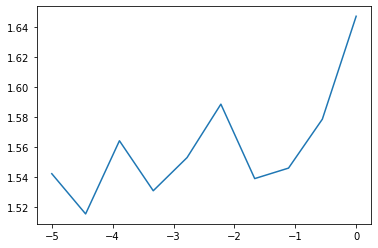

In [23]:
# Small rho tau: varying sig2_e
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = np.logspace(-5,0,N)*3*w2/(rho*100*tau**2)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.min([np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)]),[2]*rep],axis=0)) for k in range(N)]
plt.plot(np.linspace(-5,0,N),transition_m)

Something excitingly weird is going on
thnow=-42.53051542277205, thprev=[-43.64652522 -42.2318393  -42.28446857 -41.91344538 -41.33929199
 -41.06822794 -40.96187111 -42.87119033 -43.44646414 -42.82454946
 -40.95705734 -42.04758678 -43.22665281 -44.07565602 -43.00821878
 -41.75448772 -43.84001533 -43.43983194 -41.91012216 -43.27129028
 -41.6643928  -43.9099696  -44.00263564 -40.4941529  -41.075673
 -42.60958608 -42.12188895 -42.90233382 -42.06189919 -42.133816
 -41.18617187 -41.7520761  -42.12688259 -41.99514995 -42.85004657
 -40.89563007 -42.42610494 -42.66864036 -42.91463765 -42.56256993
 -44.68216103 -44.15795513 -43.305964   -43.74845801 -43.9879818
 -42.53946646 -43.51245374 -42.52831968 -42.01840338 -42.87476428
 -43.02257773 -41.02306873 -42.4723066  -43.1129435  -44.11809576
 -42.98445082 -42.4111731  -42.74212519 -43.30978115 -43.94940406
 -43.22339393 -44.56664491 -43.86703733 -40.84583263 -42.75947526
 -43.19496783 -42.41588499 -42.63166339 -42.86091843 -42.11230006
 -43.4805

C:\Users\courau\Anaconda3\lib\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Something excitingly weird is going on
thnow=-18.876635502440028, thprev=[-17.45139174 -18.55950492 -18.44552503 -18.83423586 -16.99593113
 -17.36440367 -18.17251745 -19.70463986 -19.08421471 -17.62696733
 -17.33345712 -18.20252841 -18.92238675 -19.34799455 -19.7747013
 -19.08402954 -18.37095627 -17.60707442 -20.47154485 -19.41184883
 -19.37148772 -18.31630123 -19.2402787  -19.96319804 -18.94164005
 -18.75677935 -19.35471872 -19.22526439 -18.92739885 -18.60683153
 -19.65286643 -20.10130218 -20.7060984  -18.75511623 -17.50579057
 -18.57718617 -20.48416923 -20.61946252 -18.51945028 -18.55393474
 -17.30238061 -18.81755527 -18.33476717 -18.10886284 -17.92941081
 -17.52996587 -17.98282111 -20.14904582 -19.72981992 -19.32624454
 -18.70163824 -18.81938385 -19.32128491 -18.75139983 -17.43362787
 -18.41102522 -19.04683013 -17.78714638 -21.0887393  -18.87167069
 -20.02766226 -19.12791848 -20.95439627 -18.22013251 -17.74538685
 -18.24391556 -19.48828324 -20.0926895  -19.25557106 -18.73359869
 -18

Something excitingly weird is going on
thnow=-44.55602836825697, thprev=[-45.1923227  -45.21154051 -44.74173823 -43.30796938 -42.95289644
 -43.0808711  -43.67173272 -43.97642752 -43.5570146  -44.48627053
 -43.57854458 -44.09000919 -43.60931292 -46.10384232 -44.25032388
 -43.4343736  -44.49242568 -44.58552541 -45.24026714 -45.70547603
 -45.67753095 -44.96740308 -44.79934043 -42.79451852 -43.7548557
 -44.54746958 -44.78436004 -45.04005831 -44.42071643 -45.02730947
 -44.18426066 -43.75093909 -45.18397318 -45.41571312 -45.25809938
 -44.24342804 -43.20437407 -44.653992   -45.66838452 -45.80920827
 -46.48766889 -46.57672085 -44.75367936 -44.17569064 -45.03218003
 -45.8541636  -44.44980923 -43.30360763 -44.9611973  -45.0163973
 -43.43315392 -44.42985593 -44.85857883 -44.84877816 -45.60193323
 -44.3638756  -42.77825933 -44.0132241  -45.01349433 -44.58595961
 -44.31239966 -45.0156468  -44.46253889 -43.96791188 -46.19202657
 -45.26671985 -44.36648554 -43.09878079 -43.17795347 -43.15293107
 -44.2

Something excitingly weird is going on
thnow=279.39066012584067, thprev=[280.58748269 278.51800661 280.19837538 279.95283498 279.85869037
 278.46529732 280.08381534 278.07997874 278.31511045 279.14369702
 279.91968705 279.41656296 278.77398903 280.0080706  278.15805608
 279.4668976  278.4418984  279.09906104 277.48794071 279.54613731
 278.79658627 277.89373219 278.65722055 278.2405689  278.45663284
 280.05962764 279.46368601 279.0835247  280.14596863 280.68529913
 279.93037797 280.7532263  279.58931299 281.77051786 280.00597033
 280.23126158 279.11283011 280.74837129 279.69750699 280.82708936
 281.37160384 279.62654968 278.89334057 277.61084592 277.53771369
 277.84113064 277.32954942 278.23590013 280.79216046 279.79207471
 278.42105447 281.74936374 279.56881385 280.02374402 280.9088046
 280.26587321 281.33666964 278.69013315 277.81580663 279.23678995
 280.00423616 279.21200355 278.51176599 278.52207512 278.55091412
 280.4195761  279.11353797 278.44855788 278.64981376 279.58515647
 278.

Something excitingly weird is going on
thnow=-21.67620111371732, thprev=[-22.82801297 -21.68791607 -21.12235007 -20.8089243  -21.78086346
 -23.25177224 -23.13960565 -24.12172828 -24.24750798 -22.15182141
 -21.60158131 -21.70273945 -22.59767225 -20.69143858 -22.20845417
 -21.32090982 -22.32190595 -22.1709235  -20.71440736 -22.62855713
 -22.78749062 -21.71061905 -22.16214644 -23.10691806 -24.30649233
 -22.7546905  -20.36122843 -20.61056176 -20.51249916 -20.19501412
 -20.85554971 -20.87274213 -21.01174578 -21.30410112 -21.92801931
 -19.38738309 -21.11432736 -21.06378148 -20.42880078 -20.95855003
 -20.4244892  -22.16437664 -22.27908203 -21.02174468 -21.11484199
 -20.16909565 -21.114761   -21.92145057 -21.61145383 -20.7022672
 -22.26932598 -22.27987846 -21.0423242  -20.01172165 -20.26884225
 -22.04543349 -19.95201978 -22.32438441 -20.17772881 -20.97499615
 -20.92810654 -21.47191942 -21.04483153 -22.08594285 -22.46925289
 -23.86357932 -22.81298662 -22.77600126 -22.30346618 -23.48105934
 -21.

Something excitingly weird is going on
thnow=-139.36018876922924, thprev=[-138.9986633  -140.4419499  -140.25975022 -140.57610891 -139.28912061
 -140.85870564 -141.57613586 -140.12060864 -138.52876874 -139.90690034
 -140.54578694 -137.68400309 -138.82241042 -139.92687939 -139.05115389
 -139.99207284 -139.33834152 -139.06636024 -137.87312778 -139.60329579
 -138.03610808 -137.87553399 -138.68530333 -140.64843974 -139.13784162
 -140.70192228 -139.98541994 -139.24716857 -137.7881282  -139.49926027
 -140.95048042 -141.04282896 -138.86021982 -139.63645085 -139.15651798
 -140.49505435 -139.15136035 -138.5315619  -139.87916916 -139.66516031
 -139.97577994 -138.01560193 -138.68661802 -136.94777448 -137.91995523
 -138.27177925 -140.29273987 -139.17866499 -139.09645693 -140.17732391
 -140.87281992 -140.34498579 -139.68624686 -138.99446249 -137.8527921
 -137.36889604 -139.08113853 -139.96830036 -140.95806175 -140.34335127
 -139.34308661 -140.35081864 -139.46583876 -139.25550903 -138.05153266
 -138

Something excitingly weird is going on
thnow=-201.46697429065637, thprev=[-201.91479989 -201.96209348 -201.63148686 -203.08681065 -200.71186307
 -201.69297416 -201.79510571 -202.05403462 -202.21818854 -200.35572339
 -201.29234408 -200.58333316 -202.9889141  -203.43201121 -202.25807102
 -200.54541081 -201.40860277 -200.99737528 -200.47448344 -199.63035944
 -199.84551064 -199.21317552 -200.50021053 -200.99721317 -202.26713517
 -202.44226849 -203.13968328 -203.61545661 -203.17348291 -201.23835276
 -201.99231565 -200.35623223 -201.84211482 -200.55039074 -202.47132893
 -201.3488607  -200.07221335 -201.61511335 -201.27902436 -201.43781445
 -200.36992728 -200.07514431 -201.95028797 -200.56840184 -200.76621356
 -202.05838447 -201.76904202 -201.52409622 -201.3231876  -200.13303035
 -201.23028863 -199.77067556 -201.73857617 -202.35185448 -202.41612421
 -201.22509751 -201.36908801 -199.58846636 -199.78651391 -200.69066678
 -200.64396561 -202.14711937 -202.11497832 -200.42344465 -200.4362682
 -201

Something excitingly weird is going on
thnow=106.63515125362639, thprev=[107.05309876 106.93234109 106.51252962 105.95527658 105.62210085
 107.57558345 107.37606487 107.01023126 109.02871716 107.44085238
 107.7000017  106.60789744 106.65619342 107.63043432 107.00246224
 107.02992396 106.05702636 107.21490296 107.16687423 108.00301563
 107.49972407 105.74788213 104.99271009 104.53894207 105.895312
 104.97985977 107.05949574 107.61828587 105.71474227 105.56606179
 106.11034659 103.82478914 106.07427584 106.07744289 107.8276627
 108.7372381  105.93784768 106.45707134 107.3697749  107.25682222
 107.49965719 106.62164056 104.36790733 106.68634381 106.44915248
 106.96606484 108.0813229  106.78700999 107.42952808 106.67675324
 107.14853134 108.60839709 107.79645203 107.2150065  106.76295355
 106.2029779  107.55889112 106.87064905 106.75172818 105.33419846
 106.38918322 106.42588132 107.81812319 105.99665705 106.34914135
 107.77593847 105.60491067 106.4156456  108.13275655 107.56426102
 106.53

Something excitingly weird is going on
thnow=-25.791312471619623, thprev=[-26.44626221 -26.1894681  -27.31322594 -26.16079031 -25.62942098
 -24.8984456  -25.49291544 -26.49888682 -26.38922743 -25.59815723
 -24.84506095 -25.14763774 -26.38951477 -26.02569737 -25.93296685
 -26.68874317 -25.77027978 -26.49359615 -25.79632097 -27.23020861
 -26.53744755 -28.2153131  -25.95803695 -26.14784101 -24.96183904
 -25.47909469 -26.89916392 -24.59488072 -25.57630002 -25.47729701
 -27.74103413 -24.78004007 -24.1447603  -25.15780235 -24.95752121
 -25.95726283 -24.75049161 -25.8626228  -26.2693723  -25.41585819
 -25.97453086 -25.06646176 -26.25990653 -25.23277959 -26.17254641
 -25.5885908  -25.85442154 -26.15801597 -25.84731949 -25.8842014
 -25.67209412 -25.64831354 -25.57455286 -24.04453837 -25.12210054
 -26.49845935 -26.04812844 -26.20393299 -25.61791496 -25.52852914
 -26.05906536 -25.0743365  -26.62593042 -24.95877339 -25.78133109
 -25.16358541 -26.54803347 -25.46684952 -25.32415744 -26.8777377
 -25.

Something excitingly weird is going on
thnow=-68.85938847395865, thprev=[-68.77010089 -68.67365042 -68.32090558 -69.14336375 -68.49916464
 -69.9626844  -67.46355322 -68.39957717 -67.71609613 -67.61685223
 -69.03552625 -69.97235282 -69.77485757 -67.51420024 -67.74703374
 -68.55979574 -69.37371662 -69.67454793 -70.0070493  -69.02614719
 -67.5723059  -70.93448599 -69.29604029 -70.02607318 -69.40386818
 -70.1212678  -69.59878158 -68.30815132 -69.42072056 -70.0618063
 -67.82104769 -67.22964779 -69.14651459 -68.2741081  -69.53873173
 -68.57339657 -69.80610239 -70.30861089 -69.69937962 -68.81950589
 -68.59763717 -70.31973102 -68.32388248 -68.024393   -69.2222725
 -69.2333539  -69.3334536  -68.81169383 -68.78548855 -69.16134979
 -67.91623921 -67.52466653 -68.73777555 -68.95939573 -69.75586187
 -70.895486   -69.33298186 -69.32218116 -67.57243225 -68.34240508
 -68.26882101 -68.86291843 -68.46627607 -67.72545413 -68.17847988
 -67.88788887 -70.60434094 -69.99284696 -69.90439227 -68.00239986
 -67.7

Something excitingly weird is going on
thnow=121.04162813923124, thprev=[122.11505602 120.04027648 121.01201014 120.20785722 119.6345293
 119.04768989 119.74822171 119.85427904 119.87847105 121.80942501
 121.45246765 121.08769294 121.13117717 118.97235821 119.50823294
 119.06648507 118.35056818 120.29902684 120.23609576 120.49815839
 119.82057167 120.53628422 119.47302609 120.08511607 121.46676712
 122.38916512 122.26944943 121.26840215 122.94425671 121.04508524
 122.08780655 123.71726168 121.15200783 121.4640422  122.30722105
 122.72251825 122.31661752 121.10497103 122.59549461 121.78469545
 120.57290381 120.72878952 120.67614498 119.60704056 121.02038251
 121.08817679 121.21168285 122.33754335 122.47222156 121.81494148
 121.83228136 118.9313594  122.6293317  121.50221435 121.51986128
 120.94679725 119.5971195  121.1801691  120.73262006 122.17100574
 122.05297569 121.94316555 122.27961803 121.22371961 118.90685
 120.30208607 120.29222293 121.7046621  120.95969165 121.1235638
 121.3762

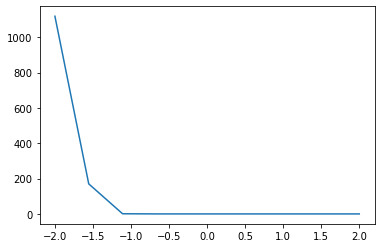

In [24]:
# Small rho tau: varying w2
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(-2,2,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e=sig2_e, w2 = w2[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-2,2,N),transition_m)

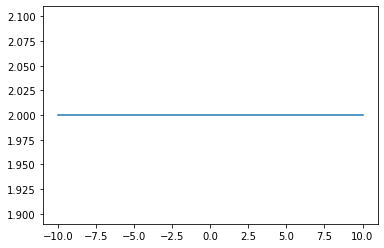

In [15]:
# Small rho tau: varying rho
tau    = 1000
N      = 10
sig2_e = 1
w2     = 10
rho    = np.linspace(-10,10,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.min([np.abs([GenerateTrajectory(sig2_e=sig2_e,tau=tau,rho = rho[k], Tmax=Tmax)[1][-1]**2 for i in range(rep)]),[2]*rep],axis=0)) for k in range(N)]
plt.plot(np.linspace(-10,10,N),transition_m)

## Same without a cue:

In [25]:
def GenerateTrajectory(x0=x0,Tmax=Tmax,tau=tau,nbsteps=nbsteps,w2=w2,Vgenetic=Vgenetic,rho=rho,sig2_e=sig2_e):
    """This function generates the trajectory of a population """
    x        = x0
    mprev    = x0[1] #We need as an initial condition the mother’s environment and sensitivity to it
    mstarprev= x0[1]
    th       = GenerateEnvironment(rho,sig2_e,nbsteps*Tmax,time=tau*(Tmax+1))
    thprev   = th[0:tau]
    varprev  = 1 #Here no cue from the previous generation

    listx = [[0,0,0]]*Tmax
    for t in range(Tmax):
        thnow   = th[(t+1)*tau:(t+2)*tau]
        meannow = np.mean(thnow)

        sigma2 = w2/tau + Vgenetic[0] + varprev*(mstarprev**2+Vgenetic[1]/h2) #the total variance in z after selection

        #Logfitness of the mean genotype of the population in environment th:
        r       = -1/2 * (np.log(sigma2*tau/w2)  +  tau/w2 * np.var(thnow) +
                    1/sigma2 * (x[0]-meannow)**2)

        #New values for the genotype: first we calculate for m, since it is quite complicated
        newgrad = (
            Vgenetic[1] * (2-h2) - (1-h2)*(1/h2-2)*mprev*(x[1] - mprev)
        ) * mstarprev * varprev/sigma2 * ((x[0]-meannow)**2/sigma2 - 1)
        mstarprev   = x[1] + newgrad/h2
        thprev  = thnow
        mprev   = x[1]
        newx    = (x[0]  -  Vgenetic[0]/sigma2 * (x[0]-meannow),
                    x[1] + newgrad)
        if abs(x[1]-newx[1])>10:
            print("Something excitingly weird is going on")
            print("thnow="+str(meannow)++", varprev="+str(varprev)+", sigma2="+str(sigma2)+", newgrad="+str(newgrad)+", x="+str(x)+", mprev="+str(mprev)+", mstarprev="+str(mstarprev))
        x       = newx
        listx[t]= [x[0],x[1],r,meannow]
    return np.transpose(listx)

Something excitingly weird is going on
thnow=-13.131704492987678, thprev=[-14.14752263 -13.87095858 -13.15410479 -14.16342444 -12.83403897
 -11.83194455 -11.65316366 -11.4967857  -12.89953458 -13.37600895
 -12.96931229 -13.30869044 -13.38035208 -13.67182048 -13.15636043
 -12.6029565  -12.49451261 -12.02962968 -11.90429075 -12.96918319
 -12.93316342 -13.76910351 -13.30649087 -13.59299389 -13.42324347
 -12.07885254 -11.90920864 -14.39306023 -14.43126709 -12.96659372
 -12.40060829 -13.28769936 -12.50753921 -12.88365969 -13.53699997
 -14.22843467 -13.46552269 -14.76948063 -12.65859514 -12.25790388
 -13.6379307  -13.09957446 -14.62998305 -13.8774905  -12.18909406
 -13.87391083 -13.05937566 -12.87166554 -12.77053673 -12.1718175
 -13.1949874  -13.46243605 -14.4345899  -12.53375502 -14.51205324
 -14.40222083 -12.62781581 -13.64423802 -13.72850092 -14.09279768
 -15.14412444 -12.26395096 -13.12349694 -14.16831823 -15.50949917
 -14.14119382 -12.62074982 -11.51192398 -11.50087105 -12.24263442
 -12

Text(0.5, 0, 'Generations')

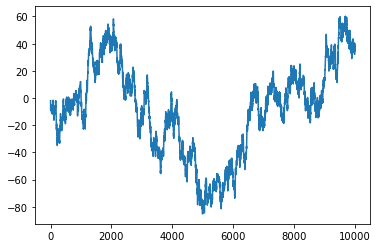

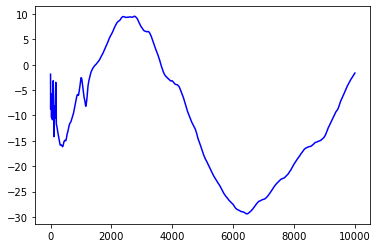

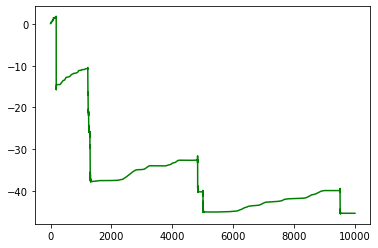

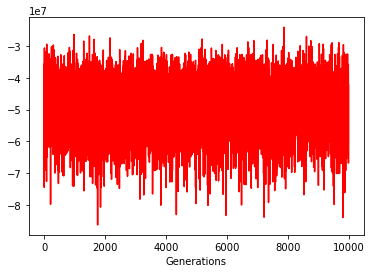

In [26]:
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * 0.01
Tmax   = 10000


listmu, listm, listr, listth = GenerateTrajectory(sig2_e = sig2_e,tau=tau,rho = rho,Tmax=Tmax,w2=w2)
plt.plot(listth)
plt.figure()
plt.plot(listmu,color="b")
plt.figure()
plt.plot(listm,color="g")
plt.figure()
plt.plot(listr,color="r")
plt.xlabel("Generations")

In [27]:
thnow=-173.36901597688316
varprev=1
sigma2=2222.574102460241
newgrad=-14.582954466134039
x=(-72.94553928149061, -55.38532986246406)
mprev=-55.38532986246406
mstarprev=-103.99517808291085
print((x[0]-meannow)**2/sigma2 - 1)

393.810549363224


In [28]:
# Large rho tau: varying sig2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = np.logspace(-5,20,N)*w2*rho/100
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
#transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
print(transition_m)
plt.plot(np.linspace(-5,20,N),transition_m)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [ ]:
# Large rho tau: varying w2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(-2,20,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e,w2=w2[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-2,20,N),transition_m)

In [ ]:
# Small rho tau: varying sig2_e
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = np.logspace(-10,10,N)*3*w2/(rho*100*tau**2)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-10,10,N),transition_m)

In [ ]:
# Small rho tau: varying w2
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(-2,2,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e=sig2_e, w2 = w2[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-2,2,N),transition_m)

In [ ]:
# Small rho tau: varying rho
tau    = 1000
N      = 10
sig2_e = 1
w2     = 10
rho    = np.logspace(-10,10,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e=sig2_e,tau=tau,rho = rho[k], Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-10,10,N),transition_m)

## Same, no transgenerationnal effect

In [29]:
def GenerateTrajectory(x0=x0,Tmax=Tmax,tau=tau,nbsteps=nbsteps,w2=w2,Vgenetic=Vgenetic,rho=rho,sig2_e=sig2_e):
    """This function generates the trajectory of a population """
    x        = x0
    th       = GenerateEnvironment(rho,sig2_e,nbsteps*Tmax,time=tau*(Tmax+1))
    thprev   = th[0:tau]

    listx = [[0,0,0]]*Tmax
    for t in range(Tmax):
        thnow   = th[(t+1)*tau:(t+2)*tau]
        meannow = np.mean(thnow)

        sigma2 = w2/tau + Vgenetic[0] + (x[1]**2+Vgenetic[1]) #the total variance in z after selection

        #New values for the genotype: first we calculate for m, since it is quite complicated
        newgrad = Vgenetic[1] * x[1]/sigma2 * ((x[0]-meannow)**2/sigma2 - 1)
        newx    = (x[0]  -  Vgenetic[0]/sigma2 * (x[0]-meannow),
                    x[1] + newgrad)
        thprev  = thnow
        if abs(x[1]-newx[1])>50:
            print("Something excitingly weird is going on")
            print("thnow="+str(meannow)+", sigma2="+str(sigma2)+", newgrad="+str(newgrad)+", x="+str(x))
            return np.transpose(listx)
        x       = newx
        listx[t]= [x[0],x[1],r,meannow]
    return np.transpose(listx)

Text(0.5, 0, 'Generations')

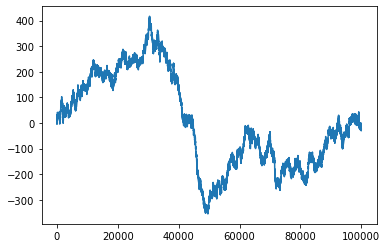

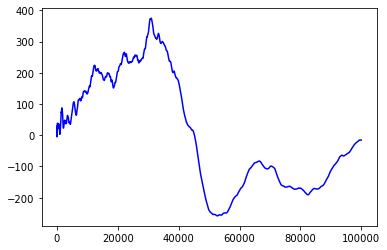

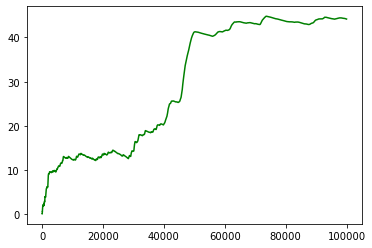

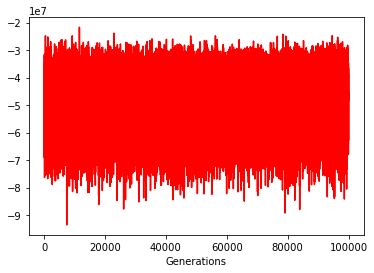

In [30]:
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * 0.01
Tmax   = 100000


listmu, listm, listr, listth = GenerateTrajectory(sig2_e = sig2_e,tau=tau,rho = rho,Tmax=Tmax,w2=w2)
plt.plot(listth)
plt.figure()
plt.plot(listmu,color="b")
plt.figure()
plt.plot(listm,color="g")
plt.figure()
plt.plot(listr,color="r")
plt.xlabel("Generations")

[13.502118244826113, 12.231859721152912, 12.760933298047014, 12.356885775746388, 12.731860040989153, 12.774997411191869, 13.174909548319585, 12.846085314983963, 12.04261934449385, 12.794340515315502]


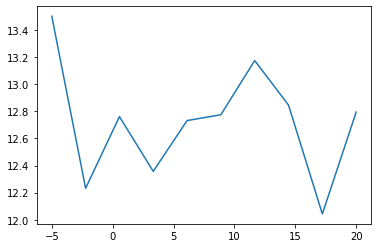

In [31]:
# Large rho tau: varying sig2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = np.logspace(-5,20,N)*w2*rho/100
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
#transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
print(transition_m)
plt.plot(np.linspace(-5,20,N),transition_m)

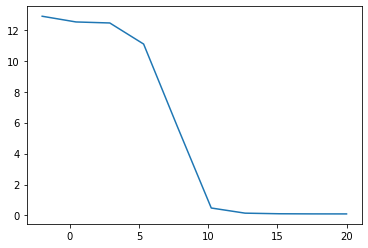

In [34]:
# Large rho tau: varying w2
tau    = 1000
rho    = 1000
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(5,10,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e,w2=w2[k],tau=tau,rho = rho,Tmax=Tmax)[1][-1] for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-2,20,N),transition_m)

In [33]:
# Small rho tau: varying sig2_e
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = np.logspace(-10,10,N)*3*w2/(rho*100*tau**2)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e = sig2_e[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-10,10,N),transition_m)

KeyboardInterrupt: 

In [ ]:
# Small rho tau: varying w2
tau    = 1000
rho    = 1e-6
N      = 10
sig2_e = 1
w2     = sig2_e/rho * np.logspace(-2,2,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e=sig2_e, w2 = w2[k],tau=tau,rho = rho, Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-2,2,N),transition_m)

In [ ]:
# Small rho tau: varying rho
tau    = 1000
N      = 10
sig2_e = 1
w2     = 10
rho    = np.logspace(-10,10,N)
rep    = 100
Tmax   = 10000

transition_m = [np.mean(np.abs([GenerateTrajectory(sig2_e=sig2_e,tau=tau,rho = rho[k], Tmax=Tmax)[1][-1]**2 for i in range(rep)])) for k in range(N)]
plt.plot(np.linspace(-10,10,N),transition_m)